# Function definitions

## Imports

In [20]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, cdist, squareform
import yaml
import glob
from pathlib import Path

## Data loading functions

In [2]:
def load_model_representations(dirpath, visual=True, ckpt_config_file=None, model_order=None):
    """
    Loads model representations from pickle files in the given directory.
    Optionally adds a 'model_name' key to each model's representation dict using a checkpoint config YAML.
    Optionally sorts the returned dict according to a provided model_order list.

    Args:
        dirpath (str or Path): Directory containing the pickle files.
        visual (bool): If True, loads visual representations; otherwise, loads text representations.
        ckpt_config_file (str or Path, optional): Path to a YAML file mapping checkpoint IDs to model names.
        model_order (list, optional): List of checkpoint IDs specifying the desired order.

    Returns:
        dict: Mapping from checkpoint names to representation dicts, each with an added 'model_name' key if config is given,
              and sorted according to model_order if provided.
    """
    rep_type = "visual" if visual else "text"
    representations = {}

    # Load checkpoint config mapping if provided
    ckpt_mapping = {}
    if ckpt_config_file is not None:
        with open(ckpt_config_file, "r") as f:
            ckpt_mapping = yaml.safe_load(f)

    for fname in os.listdir(dirpath):
        if fname.endswith(f"{rep_type}_representations.pkl"):
            ckpt_name = fname.split("-")[1]  # Assumes filename format: {dataset}-{ckpt}-{rep_type}_representations.pkl
            file_path = os.path.join(dirpath, fname)
            with open(file_path, "rb") as f:
                rep = pickle.load(f)
            # Add model_name if mapping is available
            if ckpt_mapping and ckpt_name in ckpt_mapping:
                rep["model_name"] = ckpt_mapping[ckpt_name].get("name", ckpt_name)
            representations[ckpt_name] = rep

    # Sort the dict if model_order is provided
    if model_order is not None:
        representations = {k: representations[k] for k in model_order if k in representations}

    return representations

In [3]:
def extract_layer_representations(
    representations,
    layer,
    templates=None,
    num_templates=None,
    model_order=None,
    exclude_models=None,
):
    """
    Extracts representation data (numpy arrays) for a specific layer from the loaded representations dict.
    For text representations, allows selection of specific templates by matching the whole list,
    or by matching the length of the templates list.

    Special handling:
        - If num_templates == 0: match templates == ["{}"]
        - If num_templates == 1: match list of length 1 that does NOT only have "{}" as its element

    Args:
        representations (dict): Mapping from model/checkpoint names to their loaded representation dicts.
        layer (str): The layer name to extract representations for.
        templates (list, optional): List of template strings to match exactly. If None, uses all or num_templates.
        num_templates (int, optional): Selects the entry whose templates list is as long as num_templates.
        model_order (list, optional): List of model names or IDs specifying the desired order.
        exclude_models (list, optional): List of model names or IDs to exclude from the result.

    Returns:
        dict: Mapping from model names to numpy arrays for the specified layer and templates.
    """
    # Build a mapping from both model_id and model_name to the output key
    id_to_key = {}
    name_to_key = {}
    temp_result = {}

    for model_id, model_data in representations.items():
        model_name = model_data.get("model_name", model_id)
        # Exclude models if requested (by id or name)
        if exclude_models is not None and (model_id in exclude_models or model_name in exclude_models):
            continue

        entries = [
            entry for entry in model_data["representations"]
            if entry["layer"] == layer
        ]
        # If text representations and template selection is requested
        if entries and "templates" in entries[0]:
            selected_entries = []
            if templates is not None:
                for entry in entries:
                    if entry["templates"] == templates:
                        selected_entries.append(entry["data"])
            elif num_templates is not None:
                if num_templates == 0:
                    for entry in entries:
                        if entry["templates"] == ["{}"]:
                            selected_entries.append(entry["data"])
                elif num_templates == 1:
                    for entry in entries:
                        if (
                            len(entry["templates"]) == 1
                            and entry["templates"] != ["{}"]
                        ):
                            selected_entries.append(entry["data"])
                else:
                    for entry in entries:
                        if len(entry["templates"]) == num_templates:
                            selected_entries.append(entry["data"])
            else:
                selected_entries = [entry["data"] for entry in entries]
            if len(selected_entries) > 1:
                import numpy as np
                rep_data = np.stack(selected_entries)
            elif len(selected_entries) == 1:
                rep_data = selected_entries[0]
            else:
                rep_data = None
        else:
            # Visual or no template selection
            layer_reps = [entry["data"] for entry in entries]
            if len(layer_reps) > 1:
                import numpy as np
                rep_data = np.stack(layer_reps)
            elif len(layer_reps) == 1:
                rep_data = layer_reps[0]
            else:
                rep_data = None

        temp_result[model_name] = rep_data
        id_to_key[model_id] = model_name
        name_to_key[model_name] = model_name

    # Apply model_order if provided (allow both model_id and model_name)
    if model_order is not None:
        ordered_result = {}
        for k in model_order:
            # Try model_name first, then model_id
            if k in temp_result:
                ordered_result[k] = temp_result[k]
            elif k in id_to_key and id_to_key[k] in temp_result:
                ordered_result[id_to_key[k]] = temp_result[id_to_key[k]]
            elif k in name_to_key and name_to_key[k] in temp_result:
                ordered_result[name_to_key[k]] = temp_result[name_to_key[k]]
        return ordered_result

    return temp_result

In [4]:
def extract_all_layer_representations(model_representations, model_name_or_id, num_templates=None):
    """
    Extracts a dict of all layer representations for a given model from the model_representations dict.
    Optionally filters text representations by number of templates.

    Args:
        model_representations (dict): Mapping from model names/IDs to their loaded representation dicts.
        model_name_or_id (str): The model name or ID to extract layers for.
        num_templates (int, optional): If set, only include entries with this number of templates (for text reps).

    Returns:
        dict: Mapping from layer name to numpy array (num_classes x dim) for that model.
              If present, "last_encoder_layer" and "visual_projection" are placed last in the dict.
    """
    if model_name_or_id not in model_representations:
        raise KeyError(f"Model '{model_name_or_id}' not found in model_representations.")

    rep_dict = model_representations[model_name_or_id]
    layer_dict = {}
    for entry in rep_dict["representations"]:
        layer = entry["layer"]
        # Filter by num_templates if requested and if "templates" field exists
        if num_templates is not None and "templates" in entry:
            if num_templates == 0 and entry["templates"] == ["{}"]:
                layer_dict[layer] = entry["data"]
            elif num_templates == 1 and len(entry["templates"]) == 1 and entry["templates"] != ["{}"]:
                layer_dict[layer] = entry["data"]
            elif len(entry["templates"]) == num_templates:
                layer_dict[layer] = entry["data"]
        else:
            layer_dict[layer] = entry["data"]

    # Move "last_encoder_layer" and "visual_projection" to the end if present
    special_layers = ["last_encoder_layer", "visual_projection"]
    if num_templates is not None:
        special_layers = ["last_encoder_layer", "text_projection"]
    ordered = {k: v for k, v in layer_dict.items() if k not in special_layers}
    for k in special_layers:
        if k in layer_dict:
            ordered[k] = layer_dict[k]
    return ordered

## Computation functions

In [5]:
def compute_rdm(reps, metric="correlation"):
    """Compute the Representational Dissimilarity Matrix (RDM) for a set of representations."""
    if reps.ndim == 1:
        reps = reps.reshape(-1, 1)
    return squareform(pdist(reps, metric=metric))

def compute_cross_rdm(reps1, reps2, metric="correlation"):
    """Compute cross-modal RDM (cdist) between two sets of representations."""
    if reps1.ndim == 1:
        reps1 = reps1.reshape(-1, 1)
    if reps2.ndim == 1:
        reps2 = reps2.reshape(-1, 1)
    return cdist(reps1, reps2, metric=metric)

def compute_rsa(rdm1, rdm2, metric="pearson"):
    """Compute the RSA score (correlation) between two RDMs."""
    idx = np.triu_indices_from(rdm1, k=1)
    v1 = rdm1[idx]
    v2 = rdm2[idx]
    if metric == "pearson":
        return np.corrcoef(v1, v2)[0, 1]
    elif metric == "spearman":
        from scipy.stats import spearmanr
        return spearmanr(v1, v2).correlation
    elif metric == "kendall":
        from scipy.stats import kendalltau
        return kendalltau(v1, v2).correlation
    else:
        raise ValueError(f"Unknown RSA metric: {metric}")

def compute_layerwise_rsa(reps1: dict, reps2: dict, rdm_metric="correlation", rsa_metric="pearson", layers1=None, layers2=None):
    """
    Compute a layer-wise RSA matrix between two sets of representations.
    reps1, reps2: dict[layer_name] -> numpy array (num_classes x dim)
    Returns: numpy array (len(layers1), len(layers2))
    """
    if layers1 is None:
        layers1 = list(reps1.keys())
    if layers2 is None:
        layers2 = list(reps2.keys())
    rsa_matrix = np.zeros((len(layers1), len(layers2)))
    for i, l1 in enumerate(layers1):
        for j, l2 in enumerate(layers2):
            rdm1 = compute_rdm(reps1[l1], metric=rdm_metric)
            rdm2 = compute_rdm(reps2[l2], metric=rdm_metric)
            rsa_matrix[i, j] = compute_rsa(rdm1, rdm2, metric=rsa_metric)
    return rsa_matrix

def compare_layerwise_rsa_matrices(rsa_matrix1, rsa_matrix2, metric="pearson"):
    """Compare two layer-wise RSA matrices by flattening their upper triangles and computing a similarity metric."""
    if rsa_matrix1.shape != rsa_matrix2.shape:
        raise ValueError("RSA matrices must have the same shape.")
    idx = np.triu_indices_from(rsa_matrix1, k=1)
    vec1 = rsa_matrix1[idx]
    vec2 = rsa_matrix2[idx]
    if metric == "pearson":
        return np.corrcoef(vec1, vec2)[0, 1]
    elif metric == "spearman":
        from scipy.stats import spearmanr
        return spearmanr(vec1, vec2).correlation
    elif metric == "kendall":
        from scipy.stats import kendalltau
        return kendalltau(vec1, vec2).correlation
    else:
        raise ValueError(f"Unknown metric: {metric}")

## Plotting functions

In [6]:
def plot_rdms(
    representations,
    classnames=None,
    metric="correlation",
    dataset_name=None,
    layer=None,
    representations2=None,
    layer2=None,
    n_cols=4,
    cmap="viridis",
):
    """
    Plot RDMs for one or more models. If representations2 is given, plot cross-modal RDMs.
    """
    multimodal = representations2 is not None
    n_models = len(representations)
    n_cols = min(n_cols, n_models)
    n_rows = (n_models + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = np.array(axes).reshape(-1)

    for idx, (model_name, reps) in enumerate(representations.items()):
        ax = axes[idx]
        if multimodal and model_name in representations2:
            reps2 = representations2[model_name]
            rdm = compute_cross_rdm(reps, reps2, metric=metric)
        else:
            rdm = compute_rdm(reps, metric=metric)
        sns.heatmap(
            rdm,
            ax=ax,
            cmap=cmap,
            cbar=True,
            xticklabels=classnames if classnames is not None else True,
            yticklabels=classnames if classnames is not None else True,
        )
        ax.set_title(model_name)
    for i in range(n_models, len(axes)):
        fig.delaxes(axes[i])
    fig_title = "Multimodal RDMs" if multimodal else "RDMs"
    if dataset_name:
        fig_title += f" | Dataset: {dataset_name}"
    if layer:
        fig_title += f" | Layer: {layer}"
    if multimodal and layer2:
        fig_title += f" vs {layer2}"
    fig.suptitle(fig_title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [7]:
def plot_rsa_matrix(
    rsa_matrix,
    x_labels,
    y_labels,
    title="RSA Matrix",
    ax=None,
    cmap="coolwarm",
    annot=True,
):
    """Plot an RSA matrix (e.g., layer-wise RSA)."""
    if ax is None:
        plt.figure(figsize=(8, 6))
        ax = plt.gca()
    sns.heatmap(rsa_matrix, annot=annot, fmt=".2f", cmap=cmap, xticklabels=x_labels, yticklabels=y_labels, ax=ax)
    ax.invert_yaxis()
    ax.set_xlabel("Layers/Models 2")
    ax.set_ylabel("Layers/Models 1")
    ax.set_title(title)
    plt.tight_layout()
    if ax is None:
        plt.show()

In [8]:
def plot_layerwise_rsa_multiple_models(
    model_representations: dict,
    model_ids: list,
    rdm_metric: str = "correlation",
    rsa_metric: str = "pearson",
    layers1: list = None,
    layers2: list = None,
    figsize_per_plot=(6, 5),
    cmap="coolwarm",
    annot: bool = False,
    num_templates: int = None,
    n_cols: int = 4,
    ckpts_config_file: str = None,
):
    """
    Plot layer-wise RSA for multiple models, each subplot being a model.
    """
    n_models = len(model_ids)
    n_cols = min(n_cols, n_models)
    n_rows = (n_models + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize_per_plot[0]*n_cols, figsize_per_plot[1]*n_rows))
    axes = np.array(axes).reshape(-1)

    ckpt_mapping = {}
    if ckpts_config_file is not None:
        with open(ckpts_config_file, "r") as f:
            ckpt_mapping = yaml.safe_load(f)

    for idx, model_id in enumerate(model_ids):
        model_name = model_id
        if model_id in ckpt_mapping and "name" in ckpt_mapping[model_id]:
            model_name = ckpt_mapping[model_id]["name"]
        reps_per_layer = extract_all_layer_representations(model_representations, model_id, num_templates=num_templates)
        rsa_matrix = compute_layerwise_rsa(
            reps1=reps_per_layer,
            reps2=reps_per_layer,
            rdm_metric=rdm_metric,
            rsa_metric=rsa_metric,
            layers1=layers1,
            layers2=layers2,
        )
        ax = axes[idx]
        plot_rsa_matrix(
            rsa_matrix,
            x_labels=layers2 if layers2 else list(reps_per_layer.keys()),
            y_labels=layers1 if layers1 else list(reps_per_layer.keys()),
            title=f"Model: {model_name}",
            ax=ax,
            cmap=cmap,
            annot=annot,
        )
    for i in range(n_models, len(axes)):
        fig.delaxes(axes[i])
    plt.tight_layout()
    plt.show()

In [9]:
def plot_rsa_matrix_similarity(rsa_matrix1, rsa_matrix2, metric="pearson", model_names=("Model 1", "Model 2")):
    """Plot the similarity between two layer-wise RSA matrices."""
    score = compare_layerwise_rsa_matrices(rsa_matrix1, rsa_matrix2, metric=metric)
    plt.figure(figsize=(5, 3))
    plt.bar([0], [score], width=0.5, color="skyblue")
    plt.ylim(-1, 1)
    plt.ylabel(f"{metric.capitalize()} correlation")
    plt.title(f"Layer-wise RSA similarity\n{model_names[0]} vs {model_names[1]}")
    plt.xticks([0], [f"{model_names[0]} vs {model_names[1]}"])
    plt.tight_layout()
    plt.show()

### Old

In [10]:
def plot_rdms_(
    representations,
    visual=True,
    metric="correlation",
    dataset_name=None,
    classnames=None,
    layer=None,
    representations2=None,
    layer2=None,
):
    """
    Plots Representational Dissimilarity Matrices (RDMs) for each model.
    Optionally, if a second dict of representations is provided, plots cross-modal RDMs.

    Args:
        representations (dict): Mapping from checkpoint names to numpy arrays (modality 1).
        visual (bool): If True, labels as visual; otherwise, as text.
        metric (str): Distance metric to use for RDM computation (default: 'correlation').
        dataset_name (str, optional): Name of the dataset to display in the title.
        classnames (list, optional): List of class names for axis tick labels.
        layer (str, optional): Name of the layer to display in the title.
        representations2 (dict, optional): Mapping from checkpoint names to numpy arrays (modality 2).
        layer2 (str, optional): Name of the second layer (for cross-modal RDMs).
    """
    rep_type = "Visual" if visual else "Text"
    multimodal = representations2 is not None

    n_models = len(representations)
    n_cols = 7 if n_models > 7 else n_models
    n_rows = (n_models + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = np.array(axes).reshape(-1)

    # Set the figure title with dataset, layer, and rep_type
    if multimodal:
        fig_title = f"Multimodal RDMs"
    else:
        fig_title = f"{rep_type} RDMs"
    if dataset_name:
        fig_title += f" | Dataset: {dataset_name}"
    if layer:
        fig_title += f" | Layer: {layer}"
    if multimodal and layer2:
        fig_title += f" vs {layer2}"
    fig.suptitle(fig_title, fontsize=16)

    if n_models == 1:
        axes = [axes]

    for idx, (ckpt, reps) in enumerate(representations.items()):
        ax = axes[idx]
        if multimodal and representations2 is not None and ckpt in representations2:
            reps2 = representations2[ckpt]
            # Compute cross-modal RDM (cdist)
            rdm = cdist(reps, reps2, metric=metric)
            sns.heatmap(
                rdm,
                ax=ax,
                cmap="viridis",
                cbar=True,
                xticklabels=classnames if classnames is not None else True,
                yticklabels=classnames if classnames is not None else True,
            )
        else:
            # Unimodal RDM
            rdm = squareform(pdist(reps, metric=metric))
            sns.heatmap(
                rdm,
                ax=ax,
                cmap="viridis",
                cbar=True,
                xticklabels=classnames if classnames is not None else True,
                yticklabels=classnames if classnames is not None else True,
            )
        # Use model_name if available, else ckpt
        model_name = None
        if isinstance(representations[ckpt], dict) and "model_name" in representations[ckpt]:
            model_name = representations[ckpt]["model_name"]
        ax.set_title(model_name if model_name else ckpt)

    # Hide any unused subplots
    for i in range(len(representations), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [11]:
def plot_rsa(
    representations,
    representations2=None,
    rdm_metrics=["correlation"],
    rsa_metrics=["pearson"],
    dataset_name=None,
    classnames=None,
    layer=None,
    layer2=None,
):
    """
    Plots RSA (Representational Similarity Analysis) matrices between models.
    Supports unimodal and cross-modal RSA. Plots all combinations of RDM and RSA metrics.

    Args:
        representations (dict): Mapping from model names to numpy arrays (modality 1).
        representations2 (dict, optional): Mapping from model names to numpy arrays (modality 2).
        rdm_metrics (list): List of RDM metrics (e.g., ["correlation", "euclidean"]).
        rsa_metrics (list): List of RSA metrics (e.g., ["pearson", "spearman"]).
        dataset_name (str, optional): Name of the dataset to display in the title.
        classnames (list, optional): List of class names for axis tick labels.
        layer (str, optional): Name of the layer to display in the title.
        layer2 (str, optional): Name of the second layer (for cross-modal RSA).
    """
    def get_rdm(rep, metric):
        if rep.ndim == 1:
            rep = rep.reshape(-1, 1)
        return squareform(pdist(rep, metric=metric))

    def get_cross_rdm(rep1, rep2, metric):
        if rep1.ndim == 1:
            rep1 = rep1.reshape(-1, 1)
        if rep2.ndim == 1:
            rep2 = rep2.reshape(-1, 1)
        return cdist(rep1, rep2, metric=metric)

    def rsa_score(rdm1, rdm2, metric):
        # Flatten upper triangle (excluding diagonal)
        if rdm1.shape != rdm2.shape:
            raise ValueError("RDMs must have the same shape for RSA.")
        idx = np.triu_indices_from(rdm1, k=1)
        v1 = rdm1[idx]
        v2 = rdm2[idx]
        if metric == "pearson":
            return np.corrcoef(v1, v2)[0, 1]
        elif metric == "spearman":
            from scipy.stats import spearmanr
            return spearmanr(v1, v2).correlation
        elif metric == "kendall":
            from scipy.stats import kendalltau
            return kendalltau(v1, v2).correlation
        else:
            raise ValueError(f"Unknown RSA metric: {metric}")

    model_names = list(representations.keys())
    if representations2 is not None:
        model_names2 = list(representations2.keys())
    else:
        model_names2 = model_names

    n_rdm = len(rdm_metrics)
    n_rsa = len(rsa_metrics)
    # fig, axes = plt.subplots(n_rdm, n_rsa, figsize=(3.5 * len(model_names2), 2.5 * len(model_names)), squeeze=False)
    fig, axes = plt.subplots(n_rdm, n_rsa, figsize=(8* n_rsa, 7 * n_rdm), squeeze=False)

    for i, rdm_metric in enumerate(rdm_metrics):
        # Compute RDMs for all models
        rdms1 = {name: get_rdm(representations[name], rdm_metric) for name in model_names}
        if representations2 is not None:
            rdms2 = {name: get_rdm(representations2[name], rdm_metric) for name in model_names2}
        else:
            rdms2 = rdms1

        for j, rsa_metric in enumerate(rsa_metrics):
            rsa_matrix = np.zeros((len(model_names), len(model_names2)))
            for m1, name1 in enumerate(model_names):
                for m2, name2 in enumerate(model_names2):
                    try:
                        rsa_matrix[m1, m2] = rsa_score(rdms1[name1], rdms2[name2], rsa_metric)
                    except Exception:
                        rsa_matrix[m1, m2] = np.nan
            ax = axes[i, j]
            sns.heatmap(
                rsa_matrix,
                ax=ax,
                # annot=True,
                # fmt=".2f",
                cmap="coolwarm",
                xticklabels=model_names2,
                yticklabels=model_names,
                cbar=True,
                annot_kws={"fontsize":8}
            )
            title = f"RDM: {rdm_metric}, RSA: {rsa_metric}"
            ax.set_title(title)
            ax.set_xlabel(layer2 if layer2 else "Model 2")
            ax.set_ylabel(layer if layer else "Model 1")
            # Rotate x labels for readability
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
            ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)

    # Figure title
    fig_title = "RSA Matrices"
    if dataset_name:
        fig_title += f" | Dataset: {dataset_name}"
    if layer:
        fig_title += f" | Layer: {layer}"
    if representations2 is not None and layer2:
        fig_title += f" vs {layer2}"
    fig.suptitle(fig_title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [12]:
def plot_layerwise_rsa(
    reps1: dict,
    reps2: dict,
    rdm_metric: str = "correlation",
    rsa_metric: str = "pearson",
    layers1: list = None,
    layers2: list = None,
    title: str = "Layer-wise RSA",
    xlabel: str = "Layers (Set 2)",
    ylabel: str = "Layers (Set 1)",
    figsize=(10, 8),
    cmap="coolwarm",
    annot: bool = True,
    ax=None,  # NEW: pass an axis to plot into
    vmin=None,  # NEW: minimum value for colormap
    vmax=None,  # NEW: maximum value for colormap
):
    """
    Plot a layer-wise RSA matrix between two sets of representations.
    reps1, reps2: dict[layer_name] -> numpy array (num_classes x dim)
    layers1, layers2: lists of layer names to compare (default: all keys in reps1/reps2)
    vmin, vmax: set the color scale range for the heatmap
    """
    if layers1 is None:
        layers1 = list(reps1.keys())
    if layers2 is None:
        layers2 = list(reps2.keys())

    rsa_matrix = np.zeros((len(layers1), len(layers2)))

    for i, l1 in enumerate(layers1):
        for j, l2 in enumerate(layers2):
            rdm1 = compute_rdm(reps1[l1], metric=rdm_metric)
            rdm2 = compute_rdm(reps2[l2], metric=rdm_metric)
            rsa_matrix[i, j] = compute_rsa(rdm1, rdm2, metric=rsa_metric)

    if ax is None:
        plt.figure(figsize=figsize)
        ax = plt.gca()
    sns.heatmap(
        rsa_matrix, annot=annot, fmt=".2f", cmap=cmap,
        xticklabels=layers2, yticklabels=layers1, ax=ax,
        vmin=vmin, vmax=vmax
    )
    ax.invert_yaxis()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title + f"\nRDM: {rdm_metric}, RSA: {rsa_metric}")
    plt.tight_layout()
    if ax is None:
        plt.show()

In [13]:
def plot_layerwise_rsa_multiple_models(
    model_representations: dict,
    model_ids: list,
    rdm_metric: str = "correlation",
    rsa_metric: str = "pearson",
    layers1: list = None,
    layers2: list = None,
    figsize_per_plot=(6, 5),
    cmap="coolwarm",
    annot: bool = False,
    ckpts_config_file: str = None,
    num_templates: int = None,
    global_vmin_vmax: bool = False,  # control global color scale
    clip_only: bool = False,         # NEW: only select models with CLIP in their name
):
    """
    Plot layer-wise RSA for multiple models, each subplot being a model.
    If global_vmin_vmax is True, all plots share the same vmin/vmax based on all matrices.
    If clip_only is True, only models with 'CLIP' in their name are plotted.
    """
    # Filter model_ids if clip_only is set
    if clip_only:
        model_ids = [mid for mid in model_ids if "clip" in model_representations[mid]["model_name"].lower()]

    n_models = len(model_ids)
    n_cols = min(n_models, 5)
    n_rows = (n_models + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize_per_plot[0]*n_cols, figsize_per_plot[1]*n_rows))
    axes = np.array(axes).reshape(-1)

    if ckpts_config_file is not None:
        with open(ckpts_config_file, "r") as f:
            ckpt_mapping = yaml.safe_load(f)

    # Compute all RSA matrices first if global_vmin_vmax is requested
    rsa_matrices = []
    for model_id in model_ids:
        reps_per_layer = extract_all_layer_representations(model_representations, model_id, num_templates=num_templates)
        if layers1 is None:
            l1 = list(reps_per_layer.keys())
        else:
            l1 = layers1
        if layers2 is None:
            l2 = list(reps_per_layer.keys())
        else:
            l2 = layers2
        rsa_matrix = np.zeros((len(l1), len(l2)))
        for i, l1n in enumerate(l1):
            for j, l2n in enumerate(l2):
                rdm1 = compute_rdm(reps_per_layer[l1n], metric=rdm_metric)
                rdm2 = compute_rdm(reps_per_layer[l2n], metric=rdm_metric)
                rsa_matrix[i, j] = compute_rsa(rdm1, rdm2, metric=rsa_metric)
        rsa_matrices.append(rsa_matrix)

    vmin, vmax = None, None
    if global_vmin_vmax and rsa_matrices:
        vmin = min(mat.min() for mat in rsa_matrices)
        vmax = max(mat.max() for mat in rsa_matrices)

    for idx, model_id in enumerate(model_ids):
        model_name = model_id
        if ckpts_config_file is not None and model_id in ckpt_mapping and "name" in ckpt_mapping[model_id]:
            model_name = ckpt_mapping[model_id]["name"]
        reps_per_layer = extract_all_layer_representations(model_representations, model_id, num_templates=num_templates)
        ax = axes[idx]
        plot_layerwise_rsa(
            reps1=reps_per_layer,
            reps2=reps_per_layer,
            rdm_metric=rdm_metric,
            rsa_metric=rsa_metric,
            layers1=layers1,
            layers2=layers2,
            title=f"Model: {model_name}",
            cmap=cmap,
            annot=annot,
            ax=ax,
            xlabel="Layers",
            ylabel="Layers",
            figsize=figsize_per_plot,
            vmin=vmin,
            vmax=vmax,
        )
    # Hide unused axes
    for i in range(n_models, len(axes)):
        fig.delaxes(axes[i])
    plt.tight_layout()
    plt.show()

In [14]:
def compare_layerwise_rsa_matrices(rsa_matrix1, rsa_matrix2, metric="pearson"):
    """
    Compare two layer-wise RSA matrices by flattening their upper triangles and computing a similarity metric.

    Args:
        rsa_matrix1 (np.ndarray): First layer-wise RSA matrix (square, e.g., n_layers x n_layers).
        rsa_matrix2 (np.ndarray): Second layer-wise RSA matrix (same shape as rsa_matrix1).
        metric (str): Similarity metric to use ("pearson", "spearman", "kendall").

    Returns:
        float: Similarity score between the two matrices.
    """
    if rsa_matrix1.shape != rsa_matrix2.shape:
        raise ValueError("RSA matrices must have the same shape.")

    idx = np.triu_indices_from(rsa_matrix1, k=1)
    vec1 = rsa_matrix1[idx]
    vec2 = rsa_matrix2[idx]

    if metric == "pearson":
        return np.corrcoef(vec1, vec2)[0, 1]
    elif metric == "spearman":
        from scipy.stats import spearmanr
        return spearmanr(vec1, vec2).correlation
    elif metric == "kendall":
        from scipy.stats import kendalltau
        return kendalltau(vec1, vec2).correlation
    else:
        raise ValueError(f"Unknown metric: {metric}")

In [15]:
import matplotlib.pyplot as plt

def plot_rsa_matrix_similarity(rsa_matrix1, rsa_matrix2, metric="pearson", model_names=("Model 1", "Model 2")):
    """
    Plot the similarity between two layer-wise RSA matrices.

    Args:
        rsa_matrix1 (np.ndarray): First layer-wise RSA matrix.
        rsa_matrix2 (np.ndarray): Second layer-wise RSA matrix.
        metric (str): Similarity metric ("pearson", "spearman", "kendall").
        model_names (tuple): Names of the models being compared.
    """
    score = compare_layerwise_rsa_matrices(rsa_matrix1, rsa_matrix2, metric=metric)
    plt.figure(figsize=(5, 3))
    plt.bar([0], [score], width=0.5, color="skyblue")
    plt.ylim(-1, 1)
    plt.ylabel(f"{metric.capitalize()} correlation")
    plt.title(f"Layer-wise RSA similarity\n{model_names[0]} vs {model_names[1]}")
    plt.xticks([0], [f"{model_names[0]} vs {model_names[1]}"])
    plt.tight_layout()
    plt.show()

In [16]:
def compare_layerwise_rsa_across_models(
    model_representations: dict,
    model_ids: list = None,
    layers: list = None,
    rdm_metric: str = "correlation",
    rsa_metric: str = "pearson",
    comparison_metric: str = "pearson",
    num_templates: int = None,
):
    """
    Compute a matrix of similarity scores between models, where each entry is the similarity
    between the layer-wise RSA matrices of two models.

    Args:
        model_representations (dict): Mapping from model names/IDs to their loaded representation dicts.
        model_ids (list, optional): List of model names/IDs to compare. If None, use all keys.
        layers (list, optional): List of layers to use for layer-wise RSA. If None, use all layers.
        rdm_metric (str): Metric for RDM computation.
        rsa_metric (str): Metric for layer-wise RSA computation.
        comparison_metric (str): Metric for comparing layer-wise RSA matrices.
        num_templates (int, optional): For text models, filter by number of templates.

    Returns:
        np.ndarray: (n_models, n_models) matrix of similarity scores.
        list: List of model names/IDs in the order used.
    """
    if model_ids is None:
        model_ids = list(model_representations.keys())
    n_models = len(model_ids)
    # Compute layer-wise RSA matrices for all models
    layerwise_rsa_matrices = []
    for model_id in model_ids:
        reps_per_layer = extract_all_layer_representations(model_representations, model_id, num_templates=num_templates)
        if layers is not None:
            reps_per_layer = {k: v for k, v in reps_per_layer.items() if k in layers}
        rsa_matrix = compute_layerwise_rsa(
            reps1=reps_per_layer,
            reps2=reps_per_layer,
            rdm_metric=rdm_metric,
            rsa_metric=rsa_metric,
            layers1=layers,
            layers2=layers,
        )
        layerwise_rsa_matrices.append(rsa_matrix)
    # Compute similarity matrix
    similarity_matrix = np.zeros((n_models, n_models))
    for i in range(n_models):
        for j in range(n_models):
            similarity_matrix[i, j] = compare_layerwise_rsa_matrices(
                layerwise_rsa_matrices[i],
                layerwise_rsa_matrices[j],
                metric=comparison_metric,
            )
    return similarity_matrix, model_ids

# Data loading

In [31]:
reps_dir = Path("../../data/representations/CIFAR10/full_dataset_aug_mlm")
ckpts_config_file = Path("../../configs/checkpoints/model_id_mapping.yaml")
model_order = [ # full_dataset_aug
    "3burj4np", # CLIP
    "7m9tx2jf", # CLIP + ITM
    "95ddsmmz", # CLIP + SimCLR
    "ng70n4a4", # CLIP + SimCLR + ITM
    "tibwkymx", # CLIP + SimCLR + MLM + ITM
    "txva2y48", # CLIP + SimCLR + MLM
    "khb9ltyn", # CLIP + MLM + ITM
    "shf56cne", # CLIP + MLM
    "gtp8w6c4", # SimCLR + MLM
    "xpbl8wfc", # SimCLR + ITM
    "p99godxb", # SimCLR
    "bj2tw5qt", # SimCLR + ITM + MLM
    "mkqp8hhx", # ITM + MLM
]
visual_representations = load_model_representations(reps_dir, visual=True, ckpt_config_file=ckpts_config_file, model_order=model_order)
text_representations = load_model_representations(reps_dir, visual=False, ckpt_config_file=ckpts_config_file, model_order=model_order)

# Get the first item of the visual_representations dict
first_key, first_value = next(iter(text_representations.items()))
classnames = first_value["class_names"]
dataset_name = first_value["dataset"]

# Plotting

## RDM

### Visual: last encoder layer

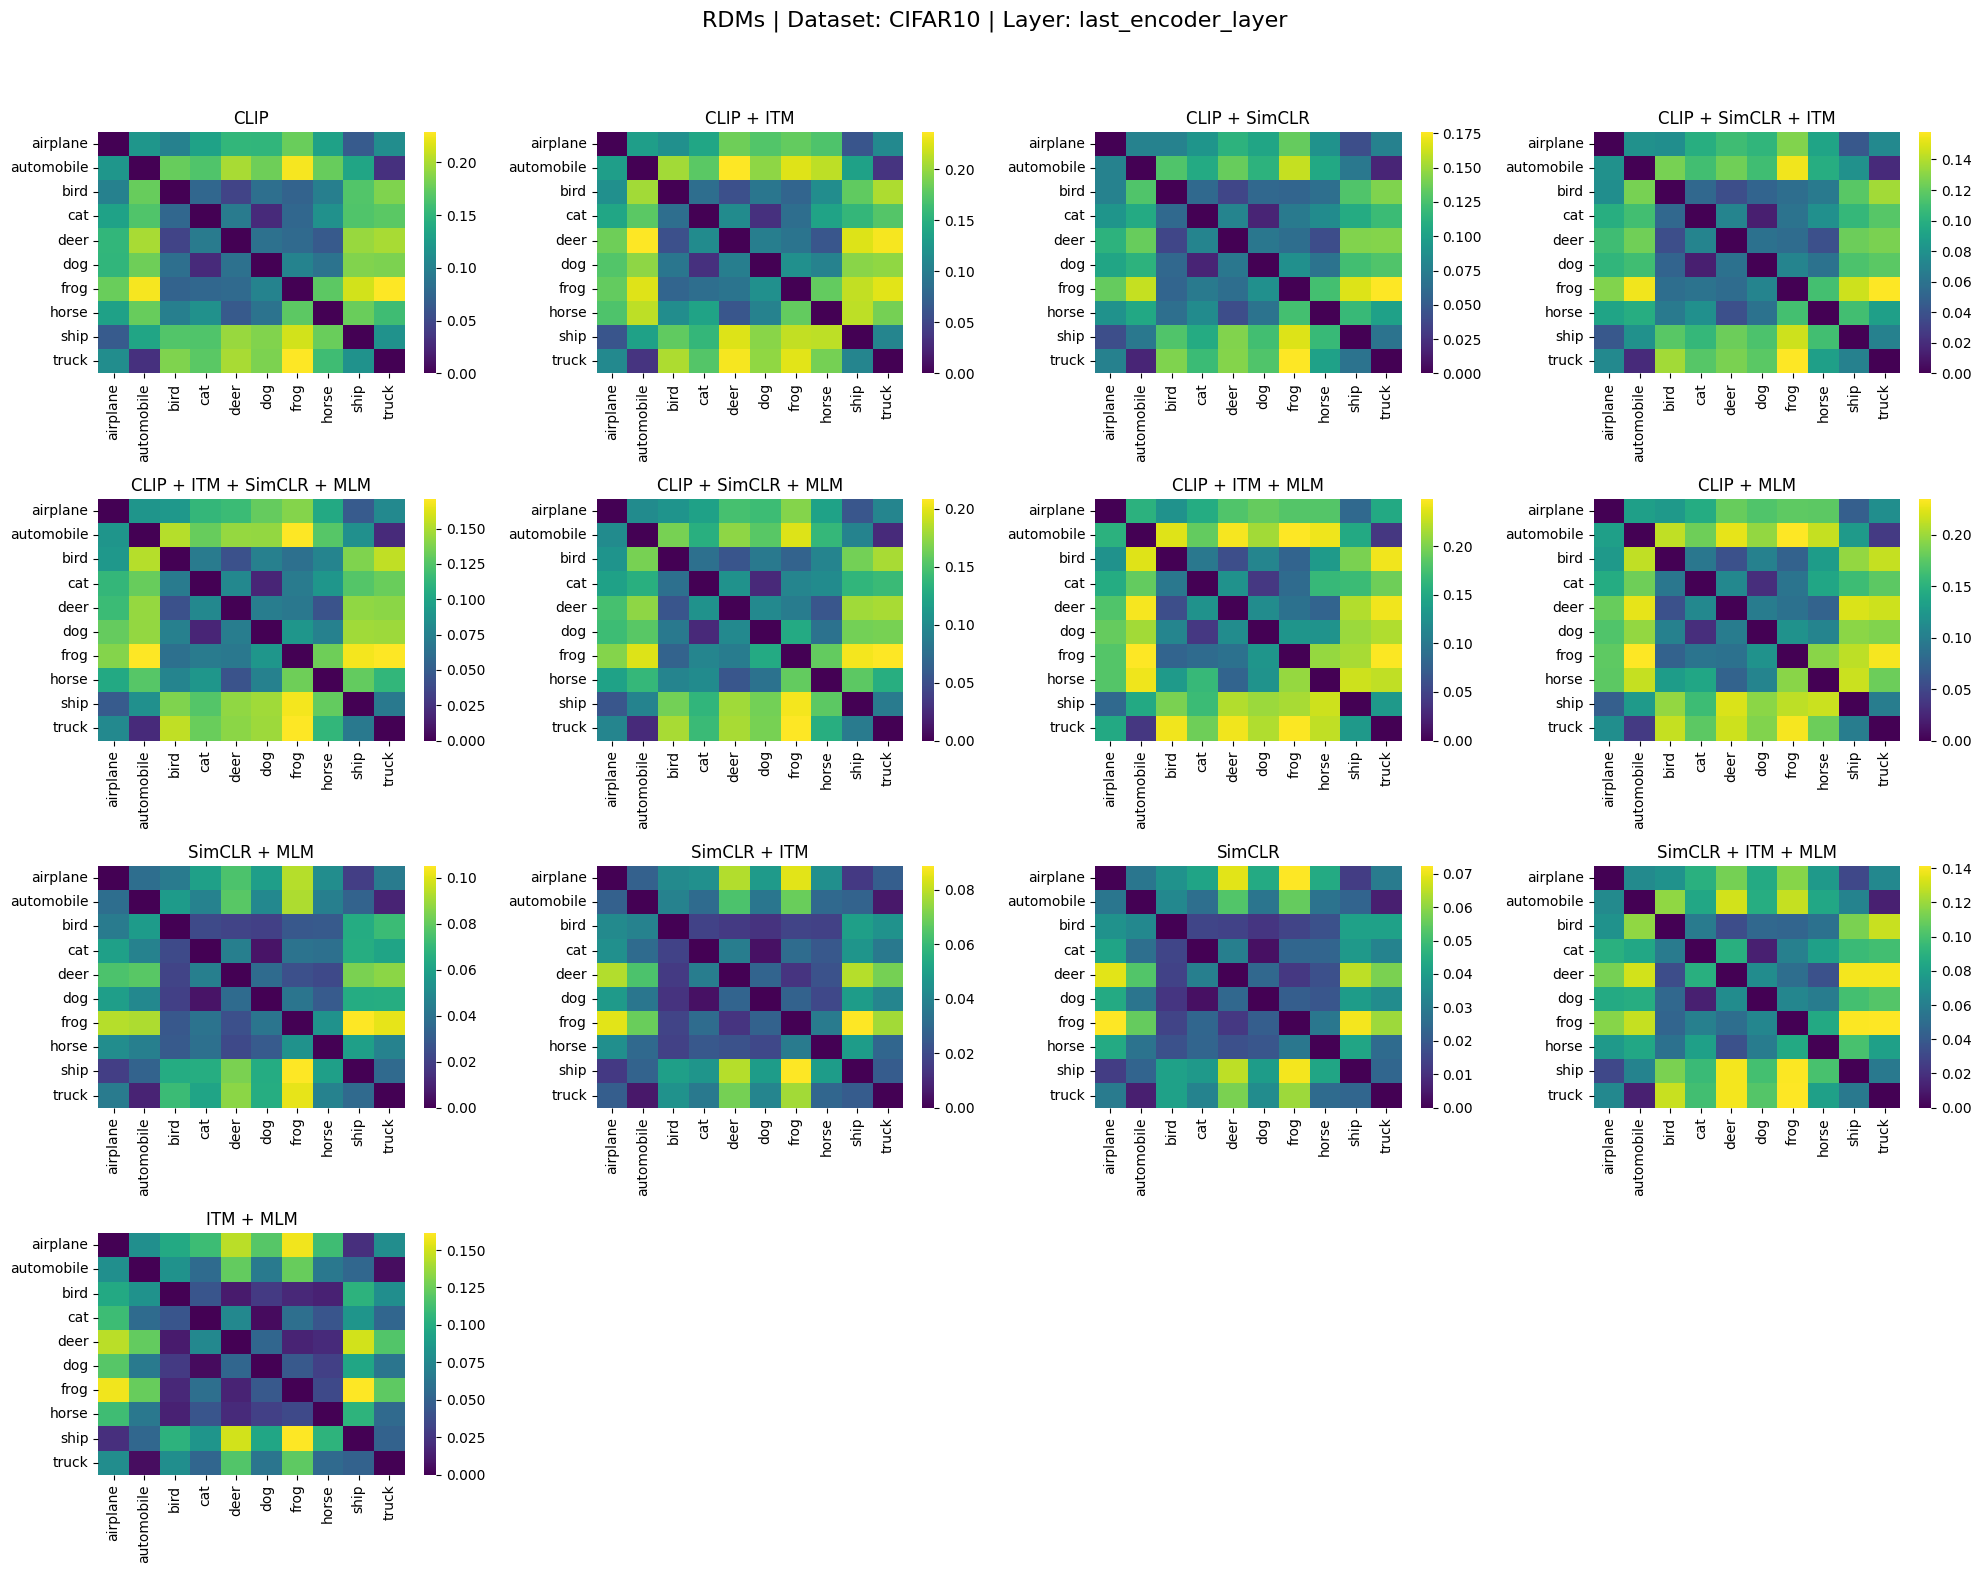

In [37]:
# vision_layer = "visual_projection"
vision_layer = "last_encoder_layer"

visual_representations_data = extract_layer_representations(visual_representations, vision_layer)

plot_rdms(visual_representations_data, metric="correlation",
          dataset_name=dataset_name, classnames=classnames, layer=vision_layer)

### Visual: visual projection layer

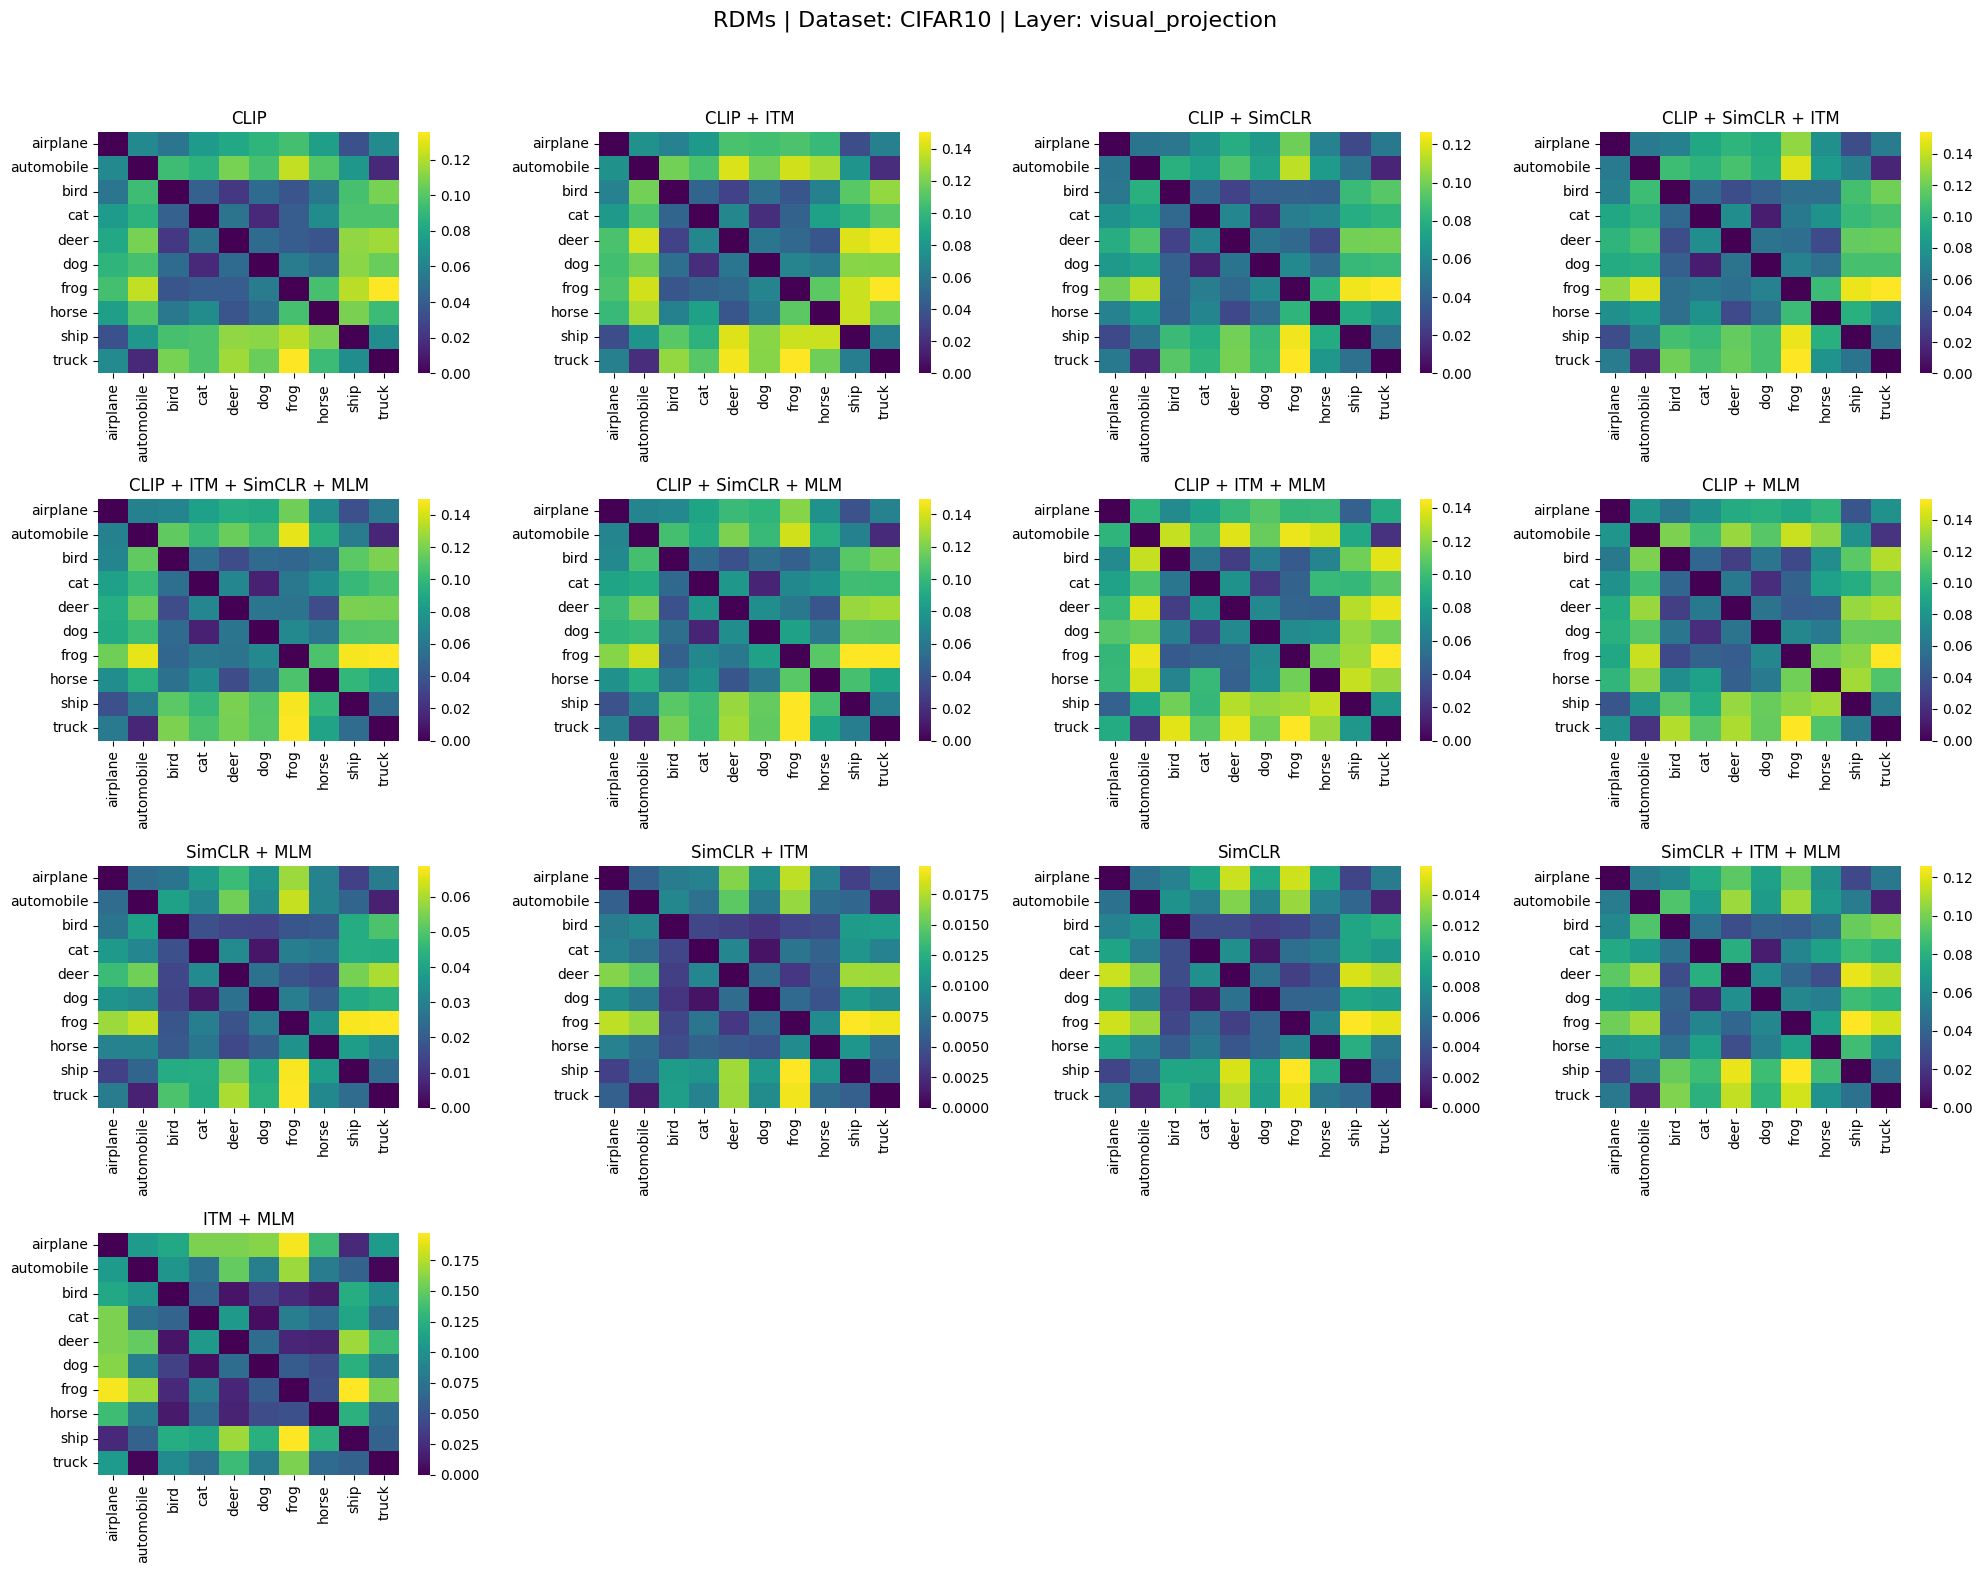

In [42]:
vision_layer = "visual_projection"
# vision_layer = "last_encoder_layer"

visual_representations_data = extract_layer_representations(visual_representations, vision_layer)

plot_rdms(visual_representations_data, metric="correlation",
          dataset_name=dataset_name, classnames=classnames, layer=vision_layer)

### Text: last encoder layer

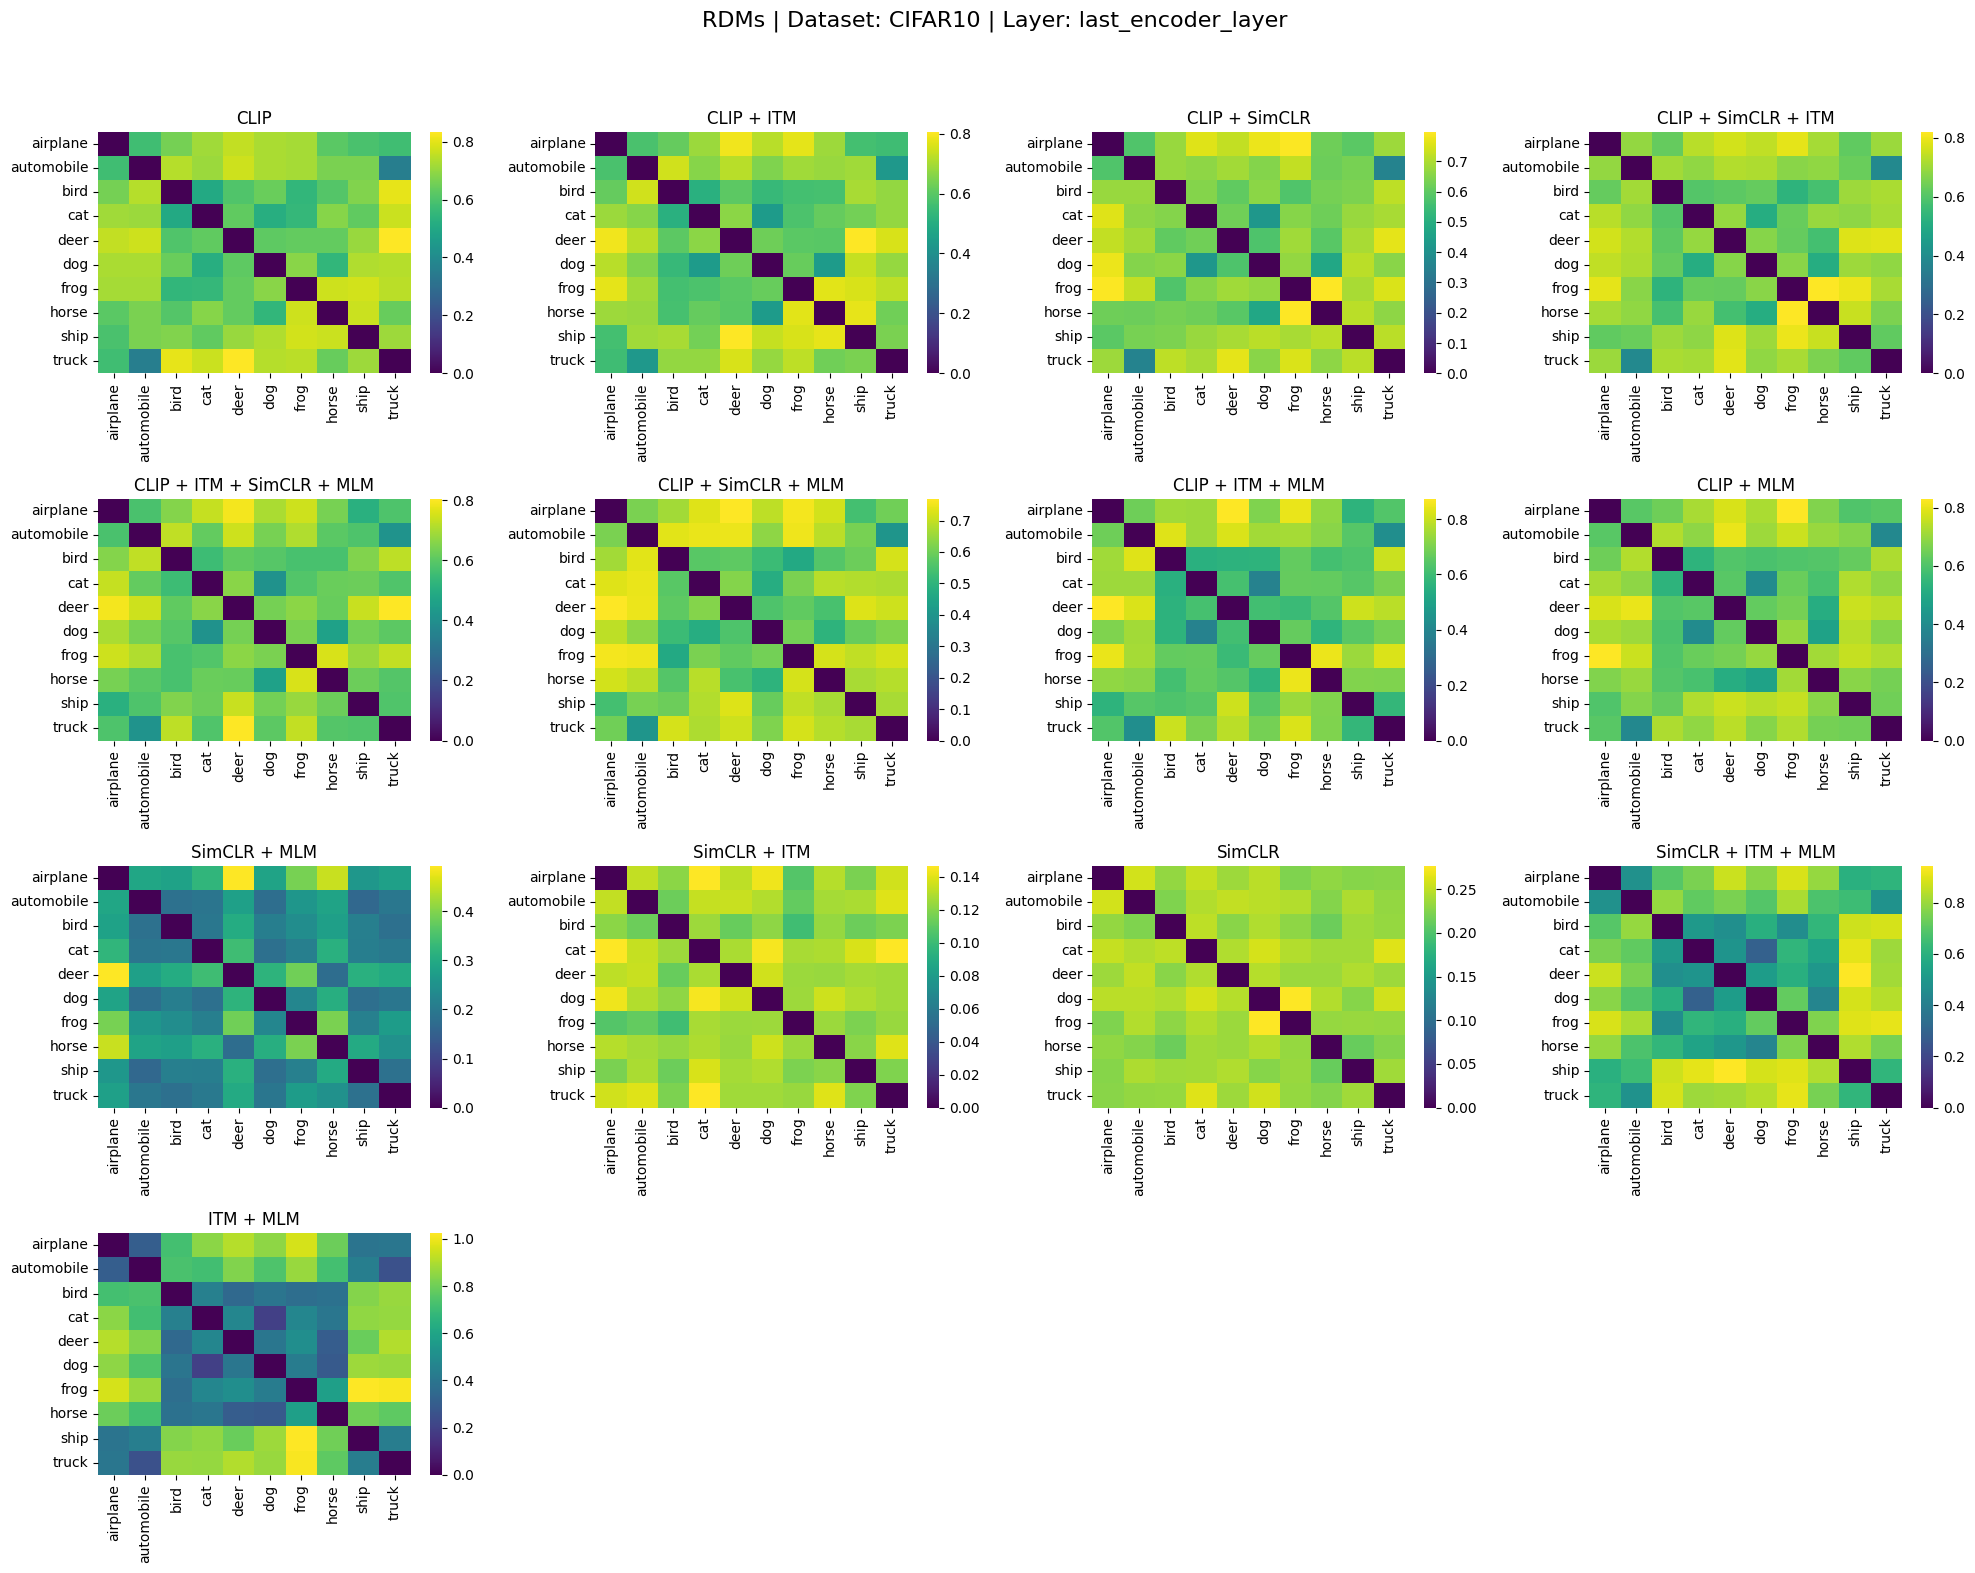

In [38]:
text_layer = "last_encoder_layer"
num_templates = 1

text_representations_data = extract_layer_representations(text_representations, layer=text_layer, num_templates=num_templates)

plot_rdms(text_representations_data, metric="correlation",
          dataset_name=dataset_name, classnames=classnames, layer=text_layer)

### Text: text projection layer

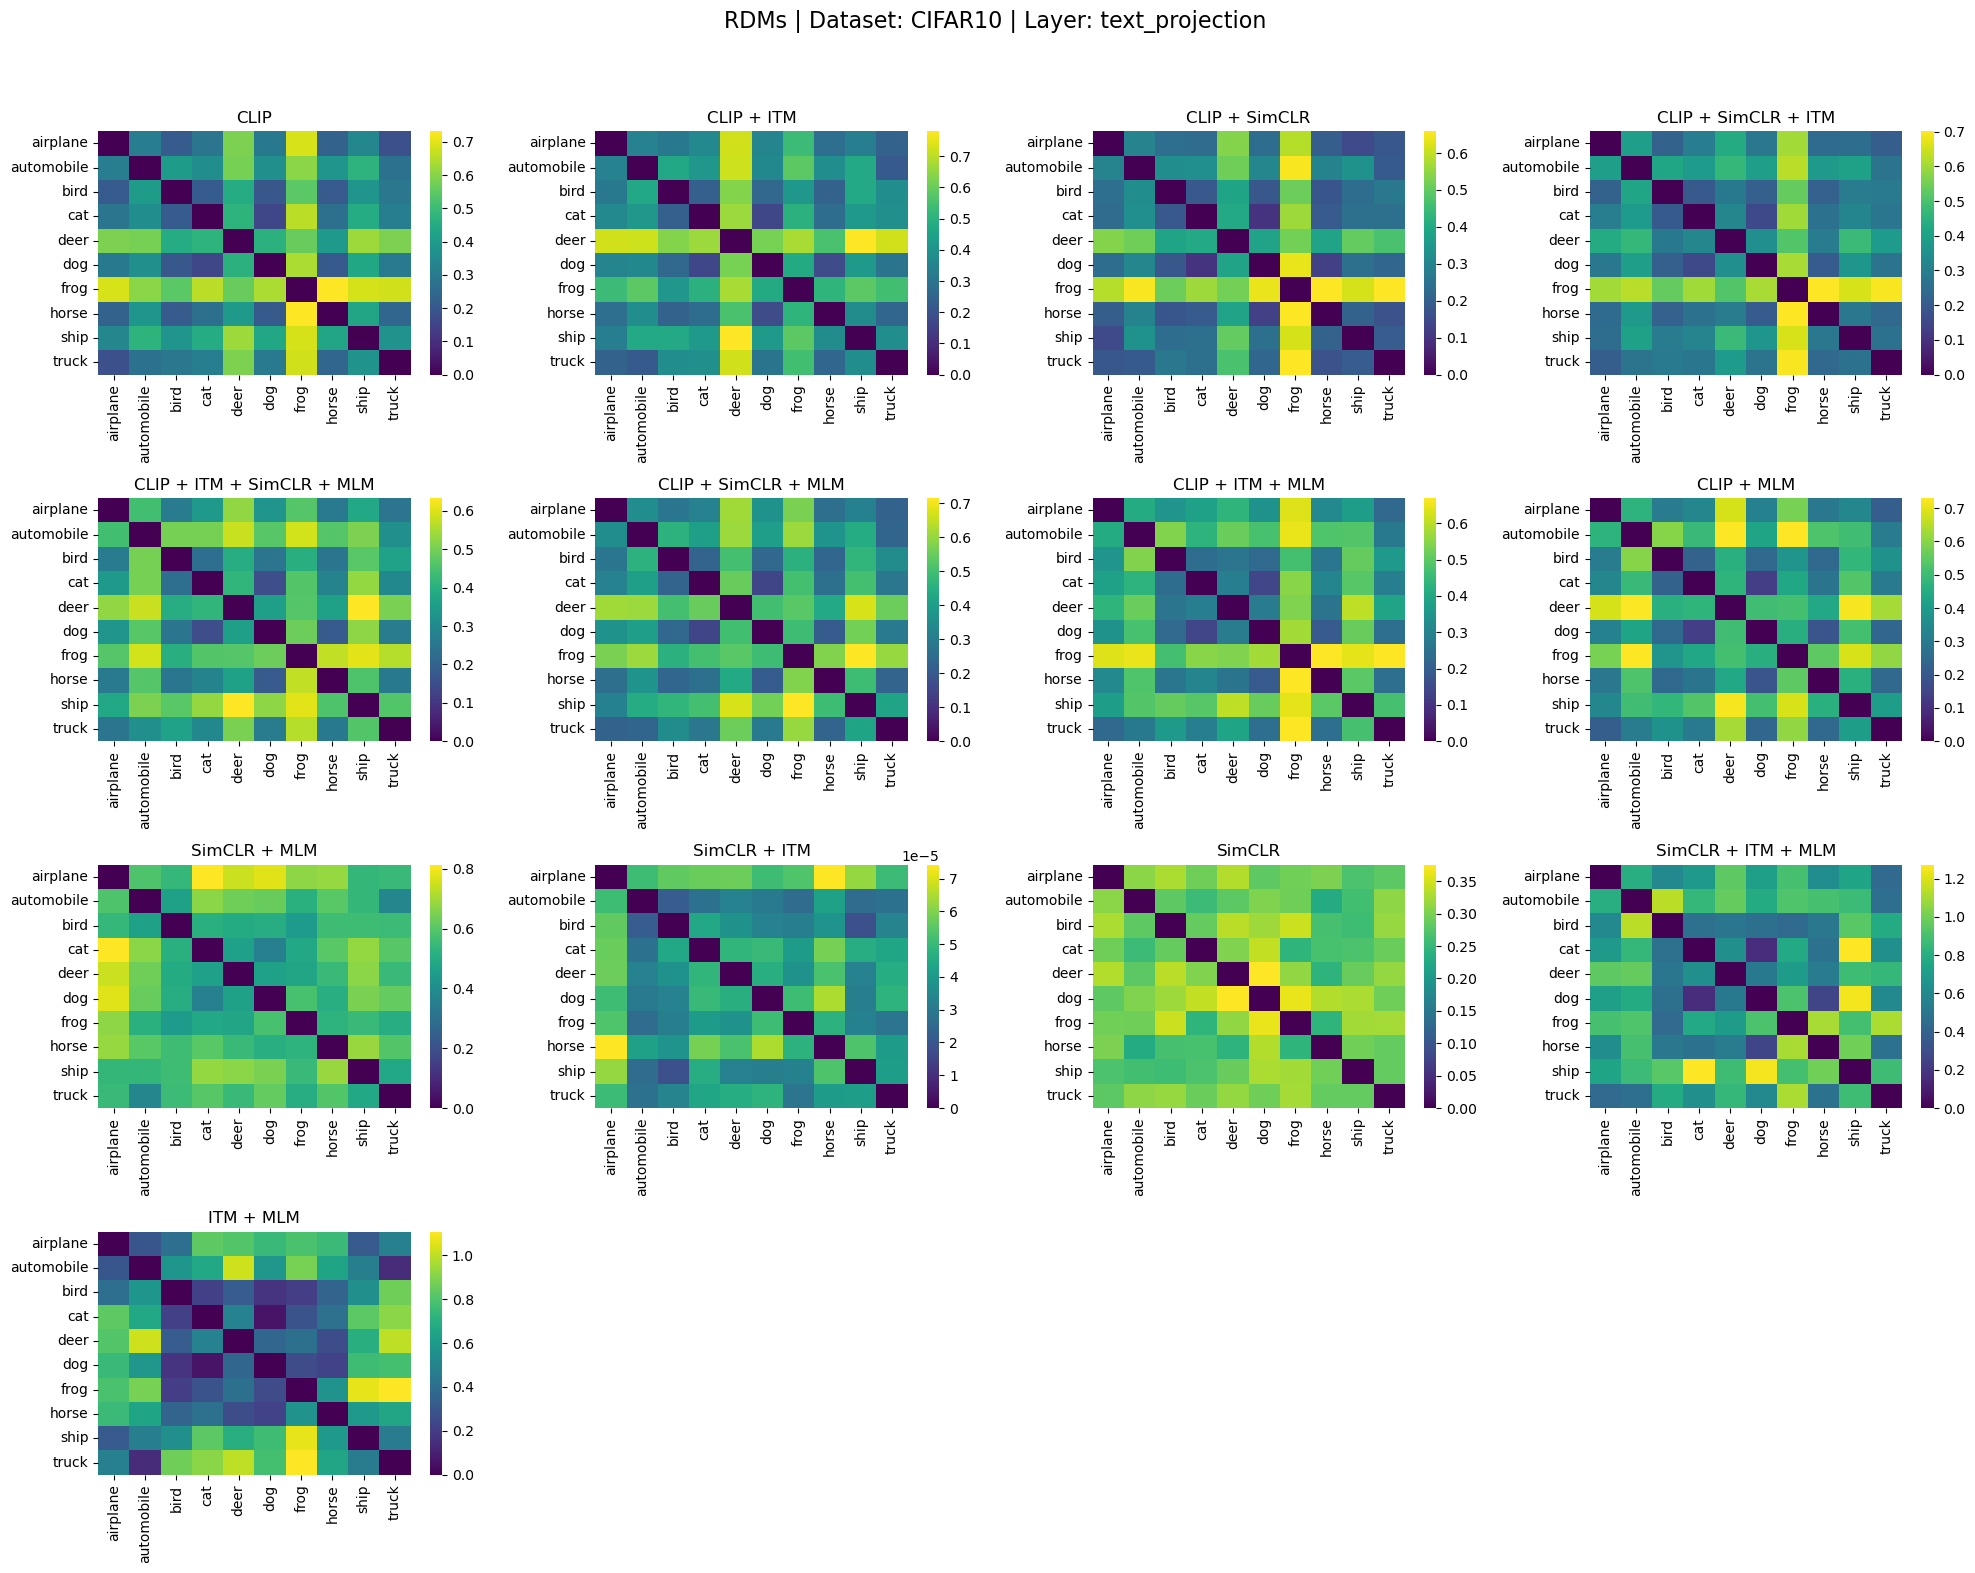

In [28]:
text_layer = "text_projection"
num_templates = 0

text_representations_data = extract_layer_representations(text_representations, layer=text_layer, num_templates=num_templates)

plot_rdms(text_representations_data, metric="correlation",
          dataset_name=dataset_name, classnames=classnames, layer=text_layer)

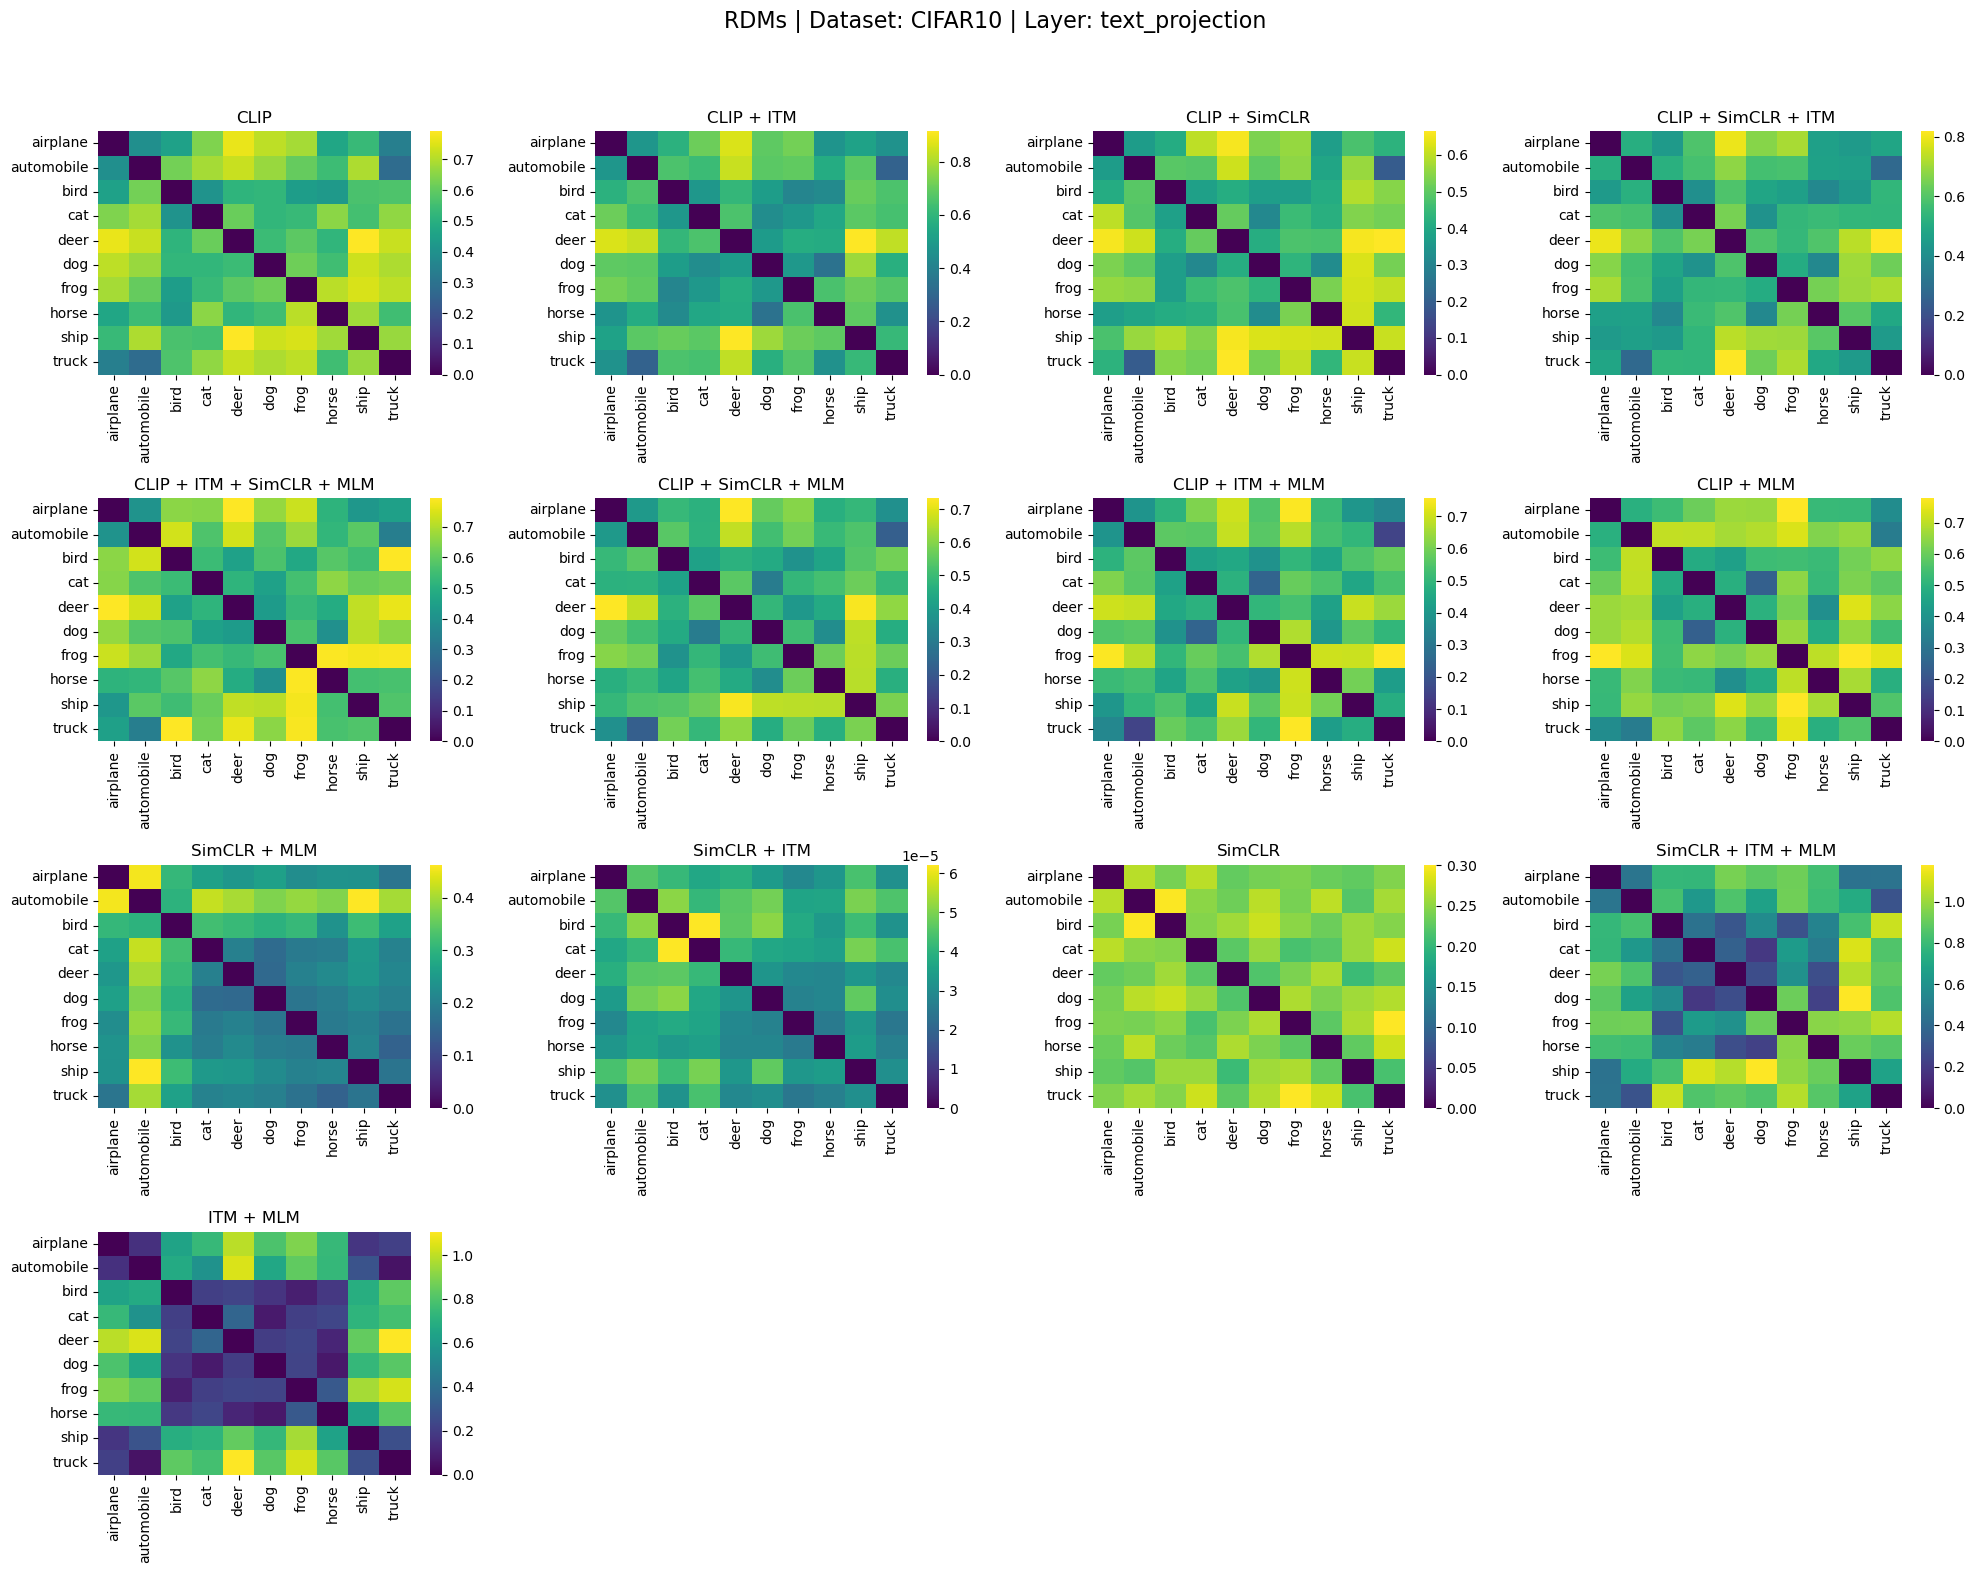

In [29]:
text_layer = "text_projection"
num_templates = 1

text_representations_data = extract_layer_representations(text_representations, layer=text_layer, num_templates=num_templates)

plot_rdms(text_representations_data, metric="correlation",
          dataset_name=dataset_name, classnames=classnames, layer=text_layer)

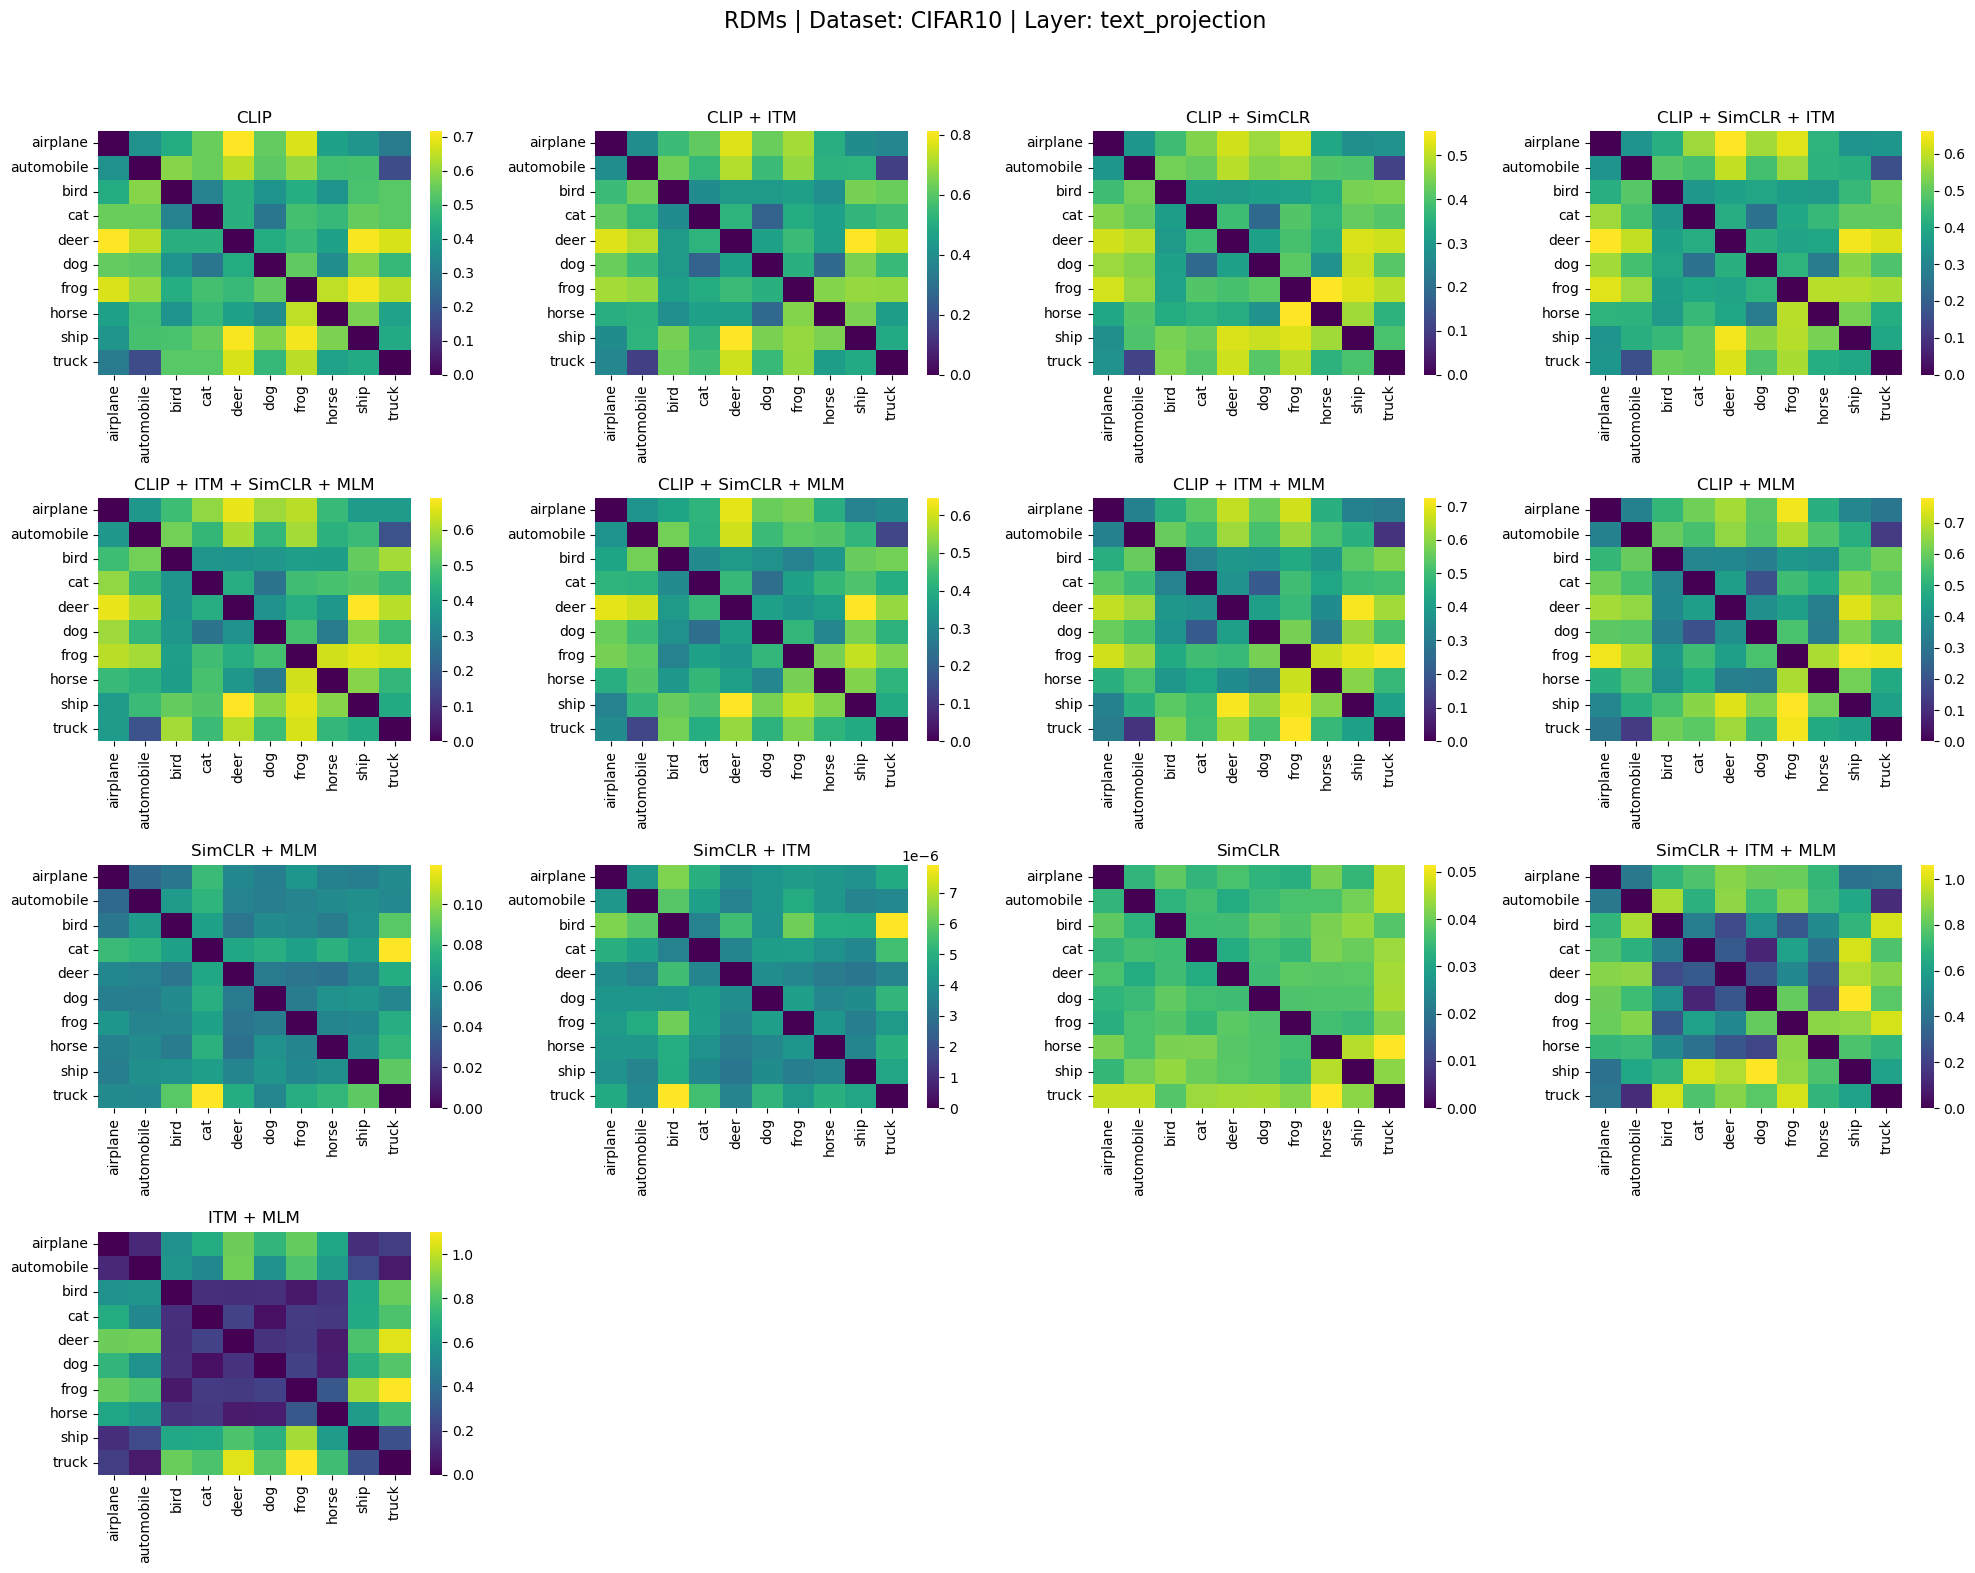

In [30]:
text_layer = "text_projection"
num_templates = 9

text_representations_data = extract_layer_representations(text_representations, layer=text_layer, num_templates=num_templates)

plot_rdms(text_representations_data, metric="correlation",
          dataset_name=dataset_name, classnames=classnames, layer=text_layer)

### Visual & Text: last encoder layer

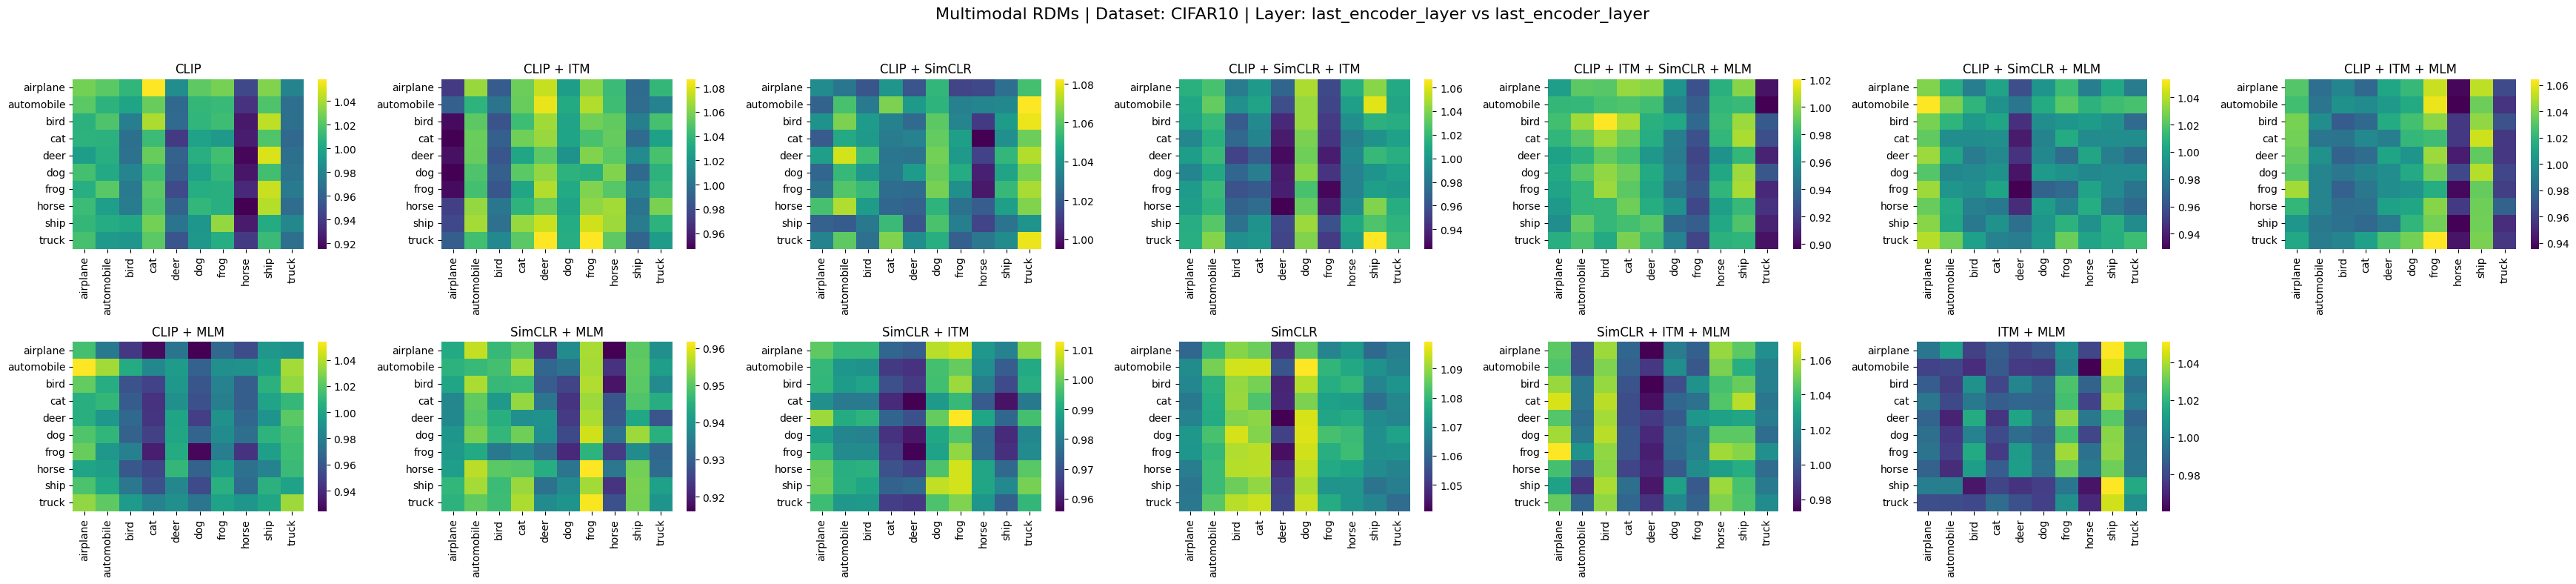

In [88]:
vision_layer = "last_encoder_layer"
text_layer = "last_encoder_layer"
num_templates = 1

visual_representations_data = extract_layer_representations(visual_representations, vision_layer)
text_representations_data = extract_layer_representations(text_representations, layer=text_layer, num_templates=num_templates)

plot_rdms(visual_representations_data, representations2=text_representations_data, metric="correlation",
          dataset_name=dataset_name, classnames=classnames, layer=vision_layer, layer2=text_layer
          )

### Visual & Text: projection layer

In [42]:
text_representations

{'3burj4np': {'dataset': 'CIFAR10',
  'model': '3burj4np',
  'class_names': ['airplane',
   'automobile',
   'bird',
   'cat',
   'deer',
   'dog',
   'frog',
   'horse',
   'ship',
   'truck'],
  'representations': [{'modality': 'text',
    'layer': 'text_projection',
    'templates': ['{}'],
    'data': array([[-0.18444593, -4.1971936 ,  0.4350224 , ..., -0.11488366,
             0.04297112, -0.55725986],
           [-0.17353919, -2.5458887 , -0.10753851, ..., -0.00722754,
             0.4122421 ,  0.4272802 ],
           [ 1.5176101 , -2.7835772 ,  0.8642198 , ..., -0.38685885,
             0.96316296,  0.1202345 ],
           ...,
           [ 0.3133119 , -2.4949312 ,  0.4208277 , ..., -0.61346394,
             0.03362072, -0.49586704],
           [-0.823829  , -1.4622263 ,  0.31852955, ..., -0.6193323 ,
             0.27171147, -0.09510045],
           [-0.48142585, -4.150473  ,  0.20283005, ...,  0.2011725 ,
             0.10299525, -0.9592819 ]], dtype=float32),
    'embedding_d

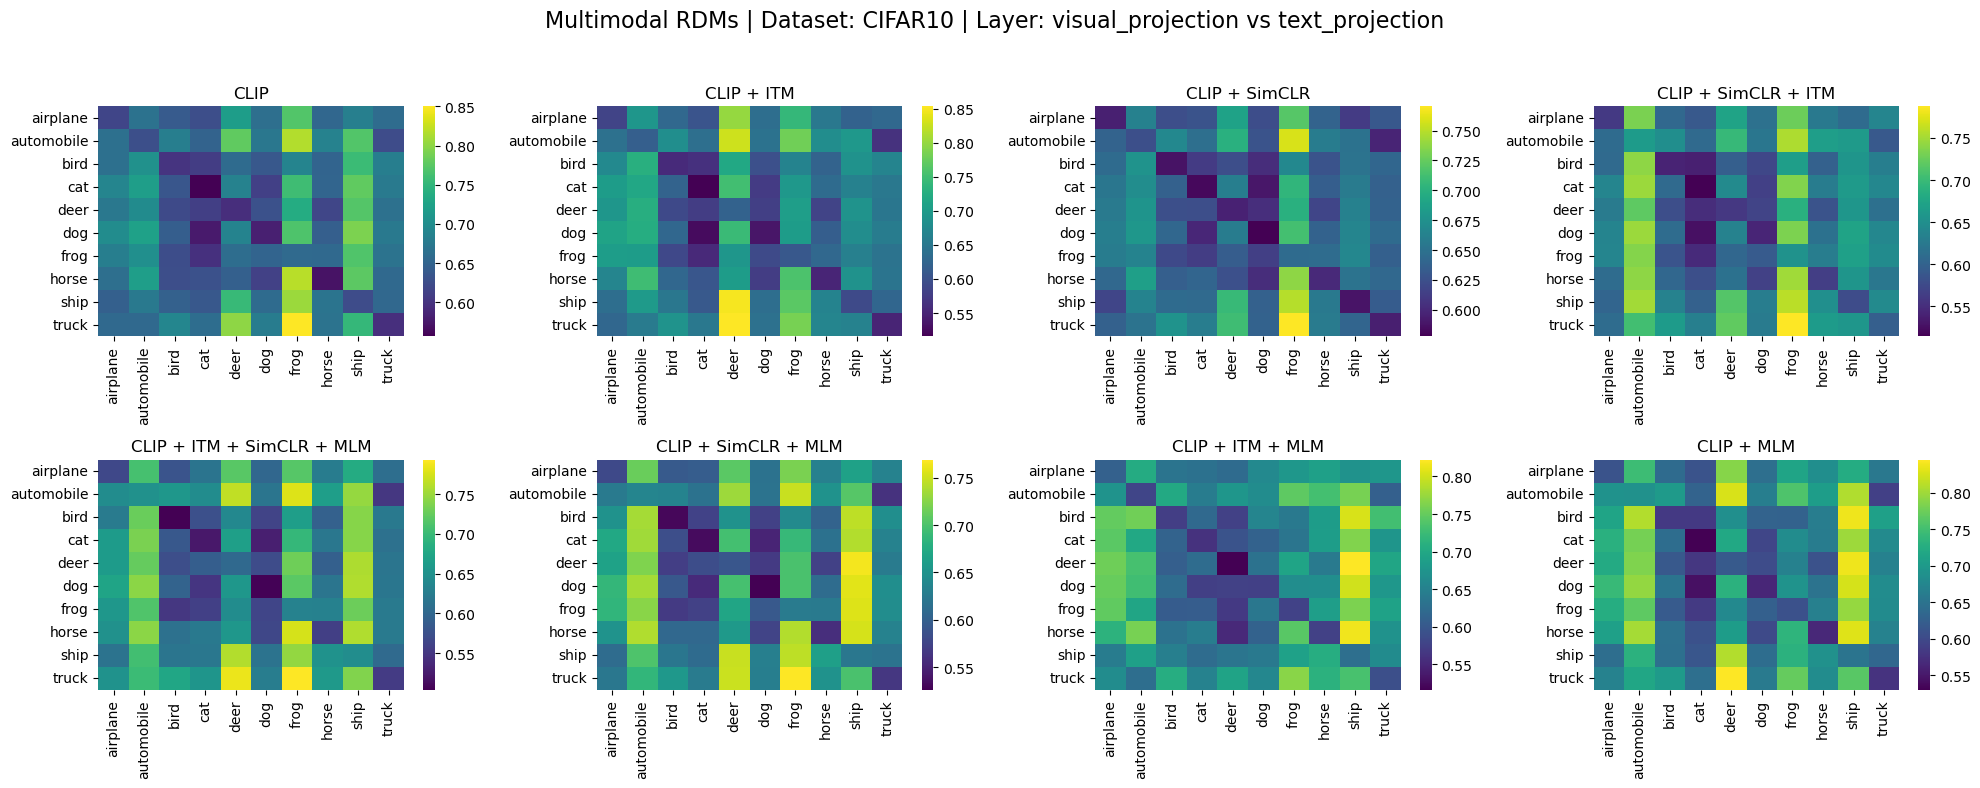

In [35]:
vision_layer = "visual_projection"
text_layer = "text_projection"
num_templates = 0
exclude_models = ["SimCLR + MLM", "SimCLR + ITM", "SimCLR", "SimCLR + ITM + MLM", "ITM + MLM"]

visual_representations_data = extract_layer_representations(visual_representations, vision_layer, exclude_models=exclude_models)
text_representations_data = extract_layer_representations(text_representations, layer=text_layer, num_templates=num_templates, exclude_models=exclude_models)

plot_rdms(visual_representations_data, representations2=text_representations_data, metric="cosine",
          dataset_name=dataset_name, classnames=classnames, layer=vision_layer, layer2=text_layer
          )

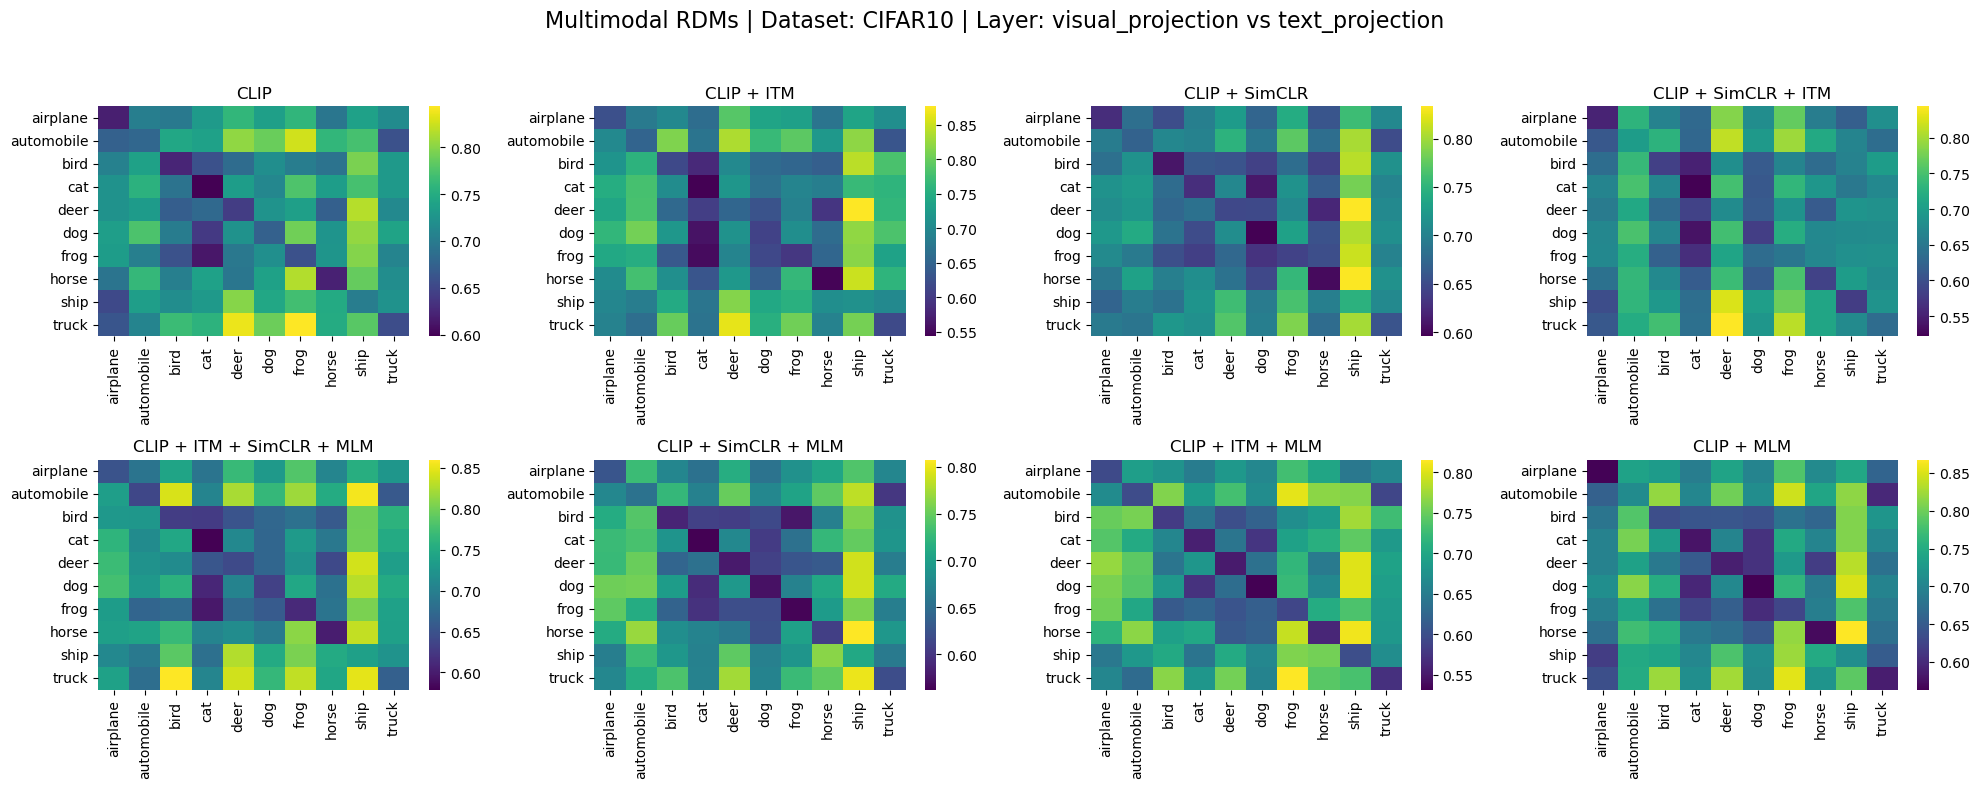

In [36]:
vision_layer = "visual_projection"
text_layer = "text_projection"
num_templates = 1
exclude_models = ["SimCLR + MLM", "SimCLR + ITM", "SimCLR", "SimCLR + ITM + MLM", "ITM + MLM"]

visual_representations_data = extract_layer_representations(visual_representations, vision_layer, exclude_models=exclude_models)
text_representations_data = extract_layer_representations(text_representations, layer=text_layer, num_templates=num_templates, exclude_models=exclude_models)

plot_rdms(visual_representations_data, representations2=text_representations_data, metric="cosine",
          dataset_name=dataset_name, classnames=classnames, layer=vision_layer, layer2=text_layer
          )

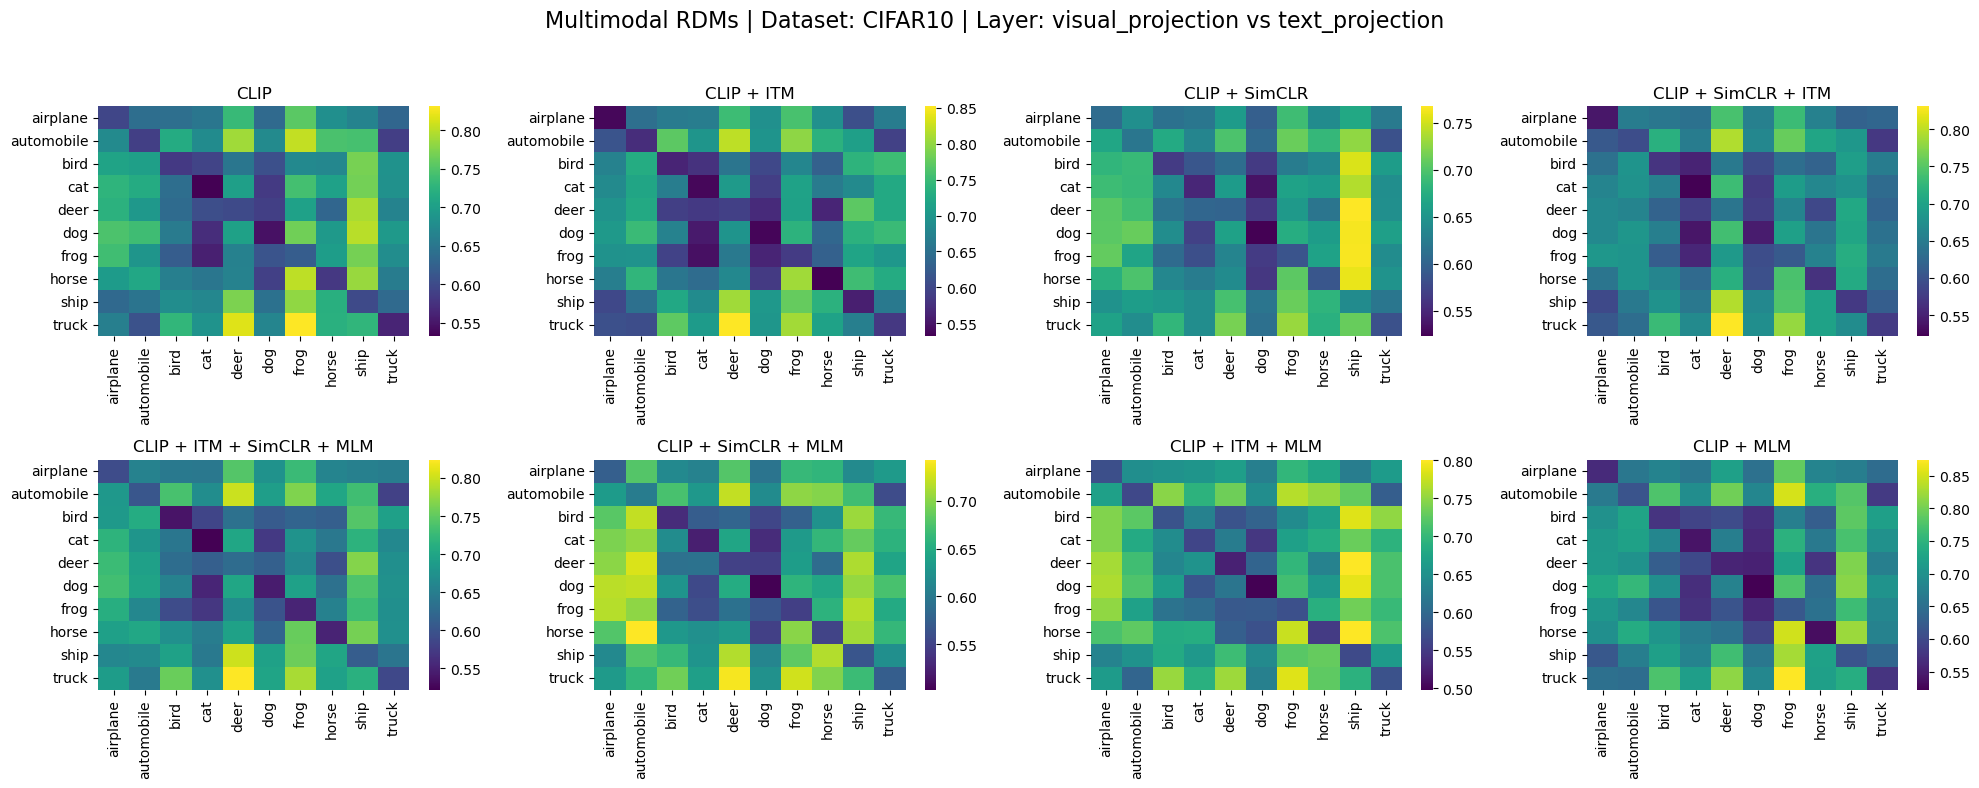

In [37]:
vision_layer = "visual_projection"
text_layer = "text_projection"
num_templates = 9
exclude_models = ["SimCLR + MLM", "SimCLR + ITM", "SimCLR", "SimCLR + ITM + MLM", "ITM + MLM"]

visual_representations_data = extract_layer_representations(visual_representations, vision_layer, exclude_models=exclude_models)
text_representations_data = extract_layer_representations(text_representations, layer=text_layer, num_templates=num_templates, exclude_models=exclude_models)

plot_rdms(visual_representations_data, representations2=text_representations_data, metric="cosine",
          dataset_name=dataset_name, classnames=classnames, layer=vision_layer, layer2=text_layer
          )

In [48]:
def plot_rdms_by_layer_and_templates(
    representations,
    layer,
    classnames=None,
    metric="correlation",
    dataset_name=None,
    representations2=None,
    layer2=None,
    cmap="viridis",
    clip_only=False,  # only plot models with 'CLIP' in their name
):
    """
    Plot RDMs (or cross-modal RDMs) for each model, grouped by num_templates (len(templates)).
    Each row: different num_templates. Each column: a model.
    If representations2 are visual representations, they do not have different templates,
    so only one representation per model is used for cross-modal RDMs.
    Args:
        representations (dict): {model_id: { ..., "representations": [ ... ] }}
        layer (str): Layer to select.
        classnames (list, optional): Class names for axis ticks.
        metric (str): Distance metric for RDM computation.
        dataset_name (str, optional): Dataset name for the plot title.
        representations2 (dict, optional): For cross-modal RDMs, same format as representations.
        layer2 (str, optional): Layer to select from representations2.
        cmap (str): Colormap for heatmaps.
        clip_only (bool): If True, only plot models with 'CLIP' in their name.
    """
    # Gather all model names and ids
    model_ids = list(representations.keys())
    model_names = [representations[mid].get("model_name", mid) for mid in model_ids]

    # Filter for CLIP models if requested
    if clip_only:
        filtered = [(mid, mname) for mid, mname in zip(model_ids, model_names) if "clip" in mname.lower()]
        if not filtered:
            print("No models with 'CLIP' in their name found.")
            return
        model_ids, model_names = zip(*filtered)
        model_ids, model_names = list(model_ids), list(model_names)

    # For each model, collect all entries for the given layer, grouped by num_templates
    rep_map = {}  # (num_templates, model_name) -> data
    num_templates_set = set()
    for mid, mdata in representations.items():
        mname = mdata.get("model_name", mid)
        if mname not in model_names:
            continue
        for entry in mdata["representations"]:
            if entry["layer"] == layer:
                if entry.get("templates", ["{}"]) == ["{}"]:
                    ntemp = 0
                else:
                    ntemp = len(entry.get("templates", []))
                num_templates_set.add(ntemp)
                rep_map[(ntemp, mname)] = entry["data"]

    num_templates_list = sorted(num_templates_set)

    # If cross-modal, build mapping for representations2 (visual: only one per model/layer)
    if representations2 is not None and layer2 is not None:
        rep2_map = {}
        for mid, mdata in representations2.items():
            mname = mdata.get("model_name", mid)
            if mname not in model_names:
                continue
            for entry in mdata["representations"]:
                if entry["layer"] == layer2:
                    rep2_map[mname] = entry["data"]
    else:
        rep2_map = None

    n_rows = len(num_templates_list)
    n_cols = len(model_names)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), squeeze=False)

    rdm_map = {}  # (ntemp, mname) -> rdm
    # Compute vmin/vmax for each column (model) for normalization
    col_vmin = [np.inf] * n_cols
    col_vmax = [-np.inf] * n_cols
    for j, mname in enumerate(model_names):
        for i, ntemp in enumerate(num_templates_list):
            key = (ntemp, mname)
            if key not in rep_map:
                continue
            reps = rep_map[key]
            if rep2_map is not None and mname in rep2_map:
                reps2 = rep2_map[mname]
                rdm = cdist(reps, reps2, metric=metric)
            else:
                rdm = squareform(pdist(reps, metric=metric))
            rdm_map[key] = rdm  # Save for later
            col_vmin[j] = min(col_vmin[j], np.nanmin(rdm))
            col_vmax[j] = max(col_vmax[j], np.nanmax(rdm))

    for i, ntemp in enumerate(num_templates_list):
        for j, mname in enumerate(model_names):
            ax = axes[i, j]
            key = (ntemp, mname)
            if key not in rep_map:
                ax.axis('off')
                continue
            rdm = rdm_map[key]
            sns.heatmap(
                rdm,
                ax=ax,
                cmap=cmap,
                cbar=True,
                vmin=col_vmin[j],
                vmax=col_vmax[j],
                xticklabels=classnames if classnames is not None else True,
                yticklabels=classnames if classnames is not None else True,
            )
            title = f"{mname}"
            if rep2_map is not None:
                title += " (cross-modal)"
            ax.set_title(title)
            if j == 0:
                ax.set_ylabel(f"num_templates={ntemp}")

    # Hide unused axes
    for i in range(n_rows):
        for j in range(n_cols):
            if (num_templates_list[i], model_names[j]) not in rep_map:
                axes[i, j].axis('off')

    fig_title = "Multimodal RDMs" if rep2_map is not None else "RDMs"
    if dataset_name:
        fig_title += f" | Dataset: {dataset_name}"
    fig_title += f" | Layer: {layer}"
    if rep2_map is not None and layer2:
        fig_title += f" vs {layer2}"
    fig.suptitle(fig_title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

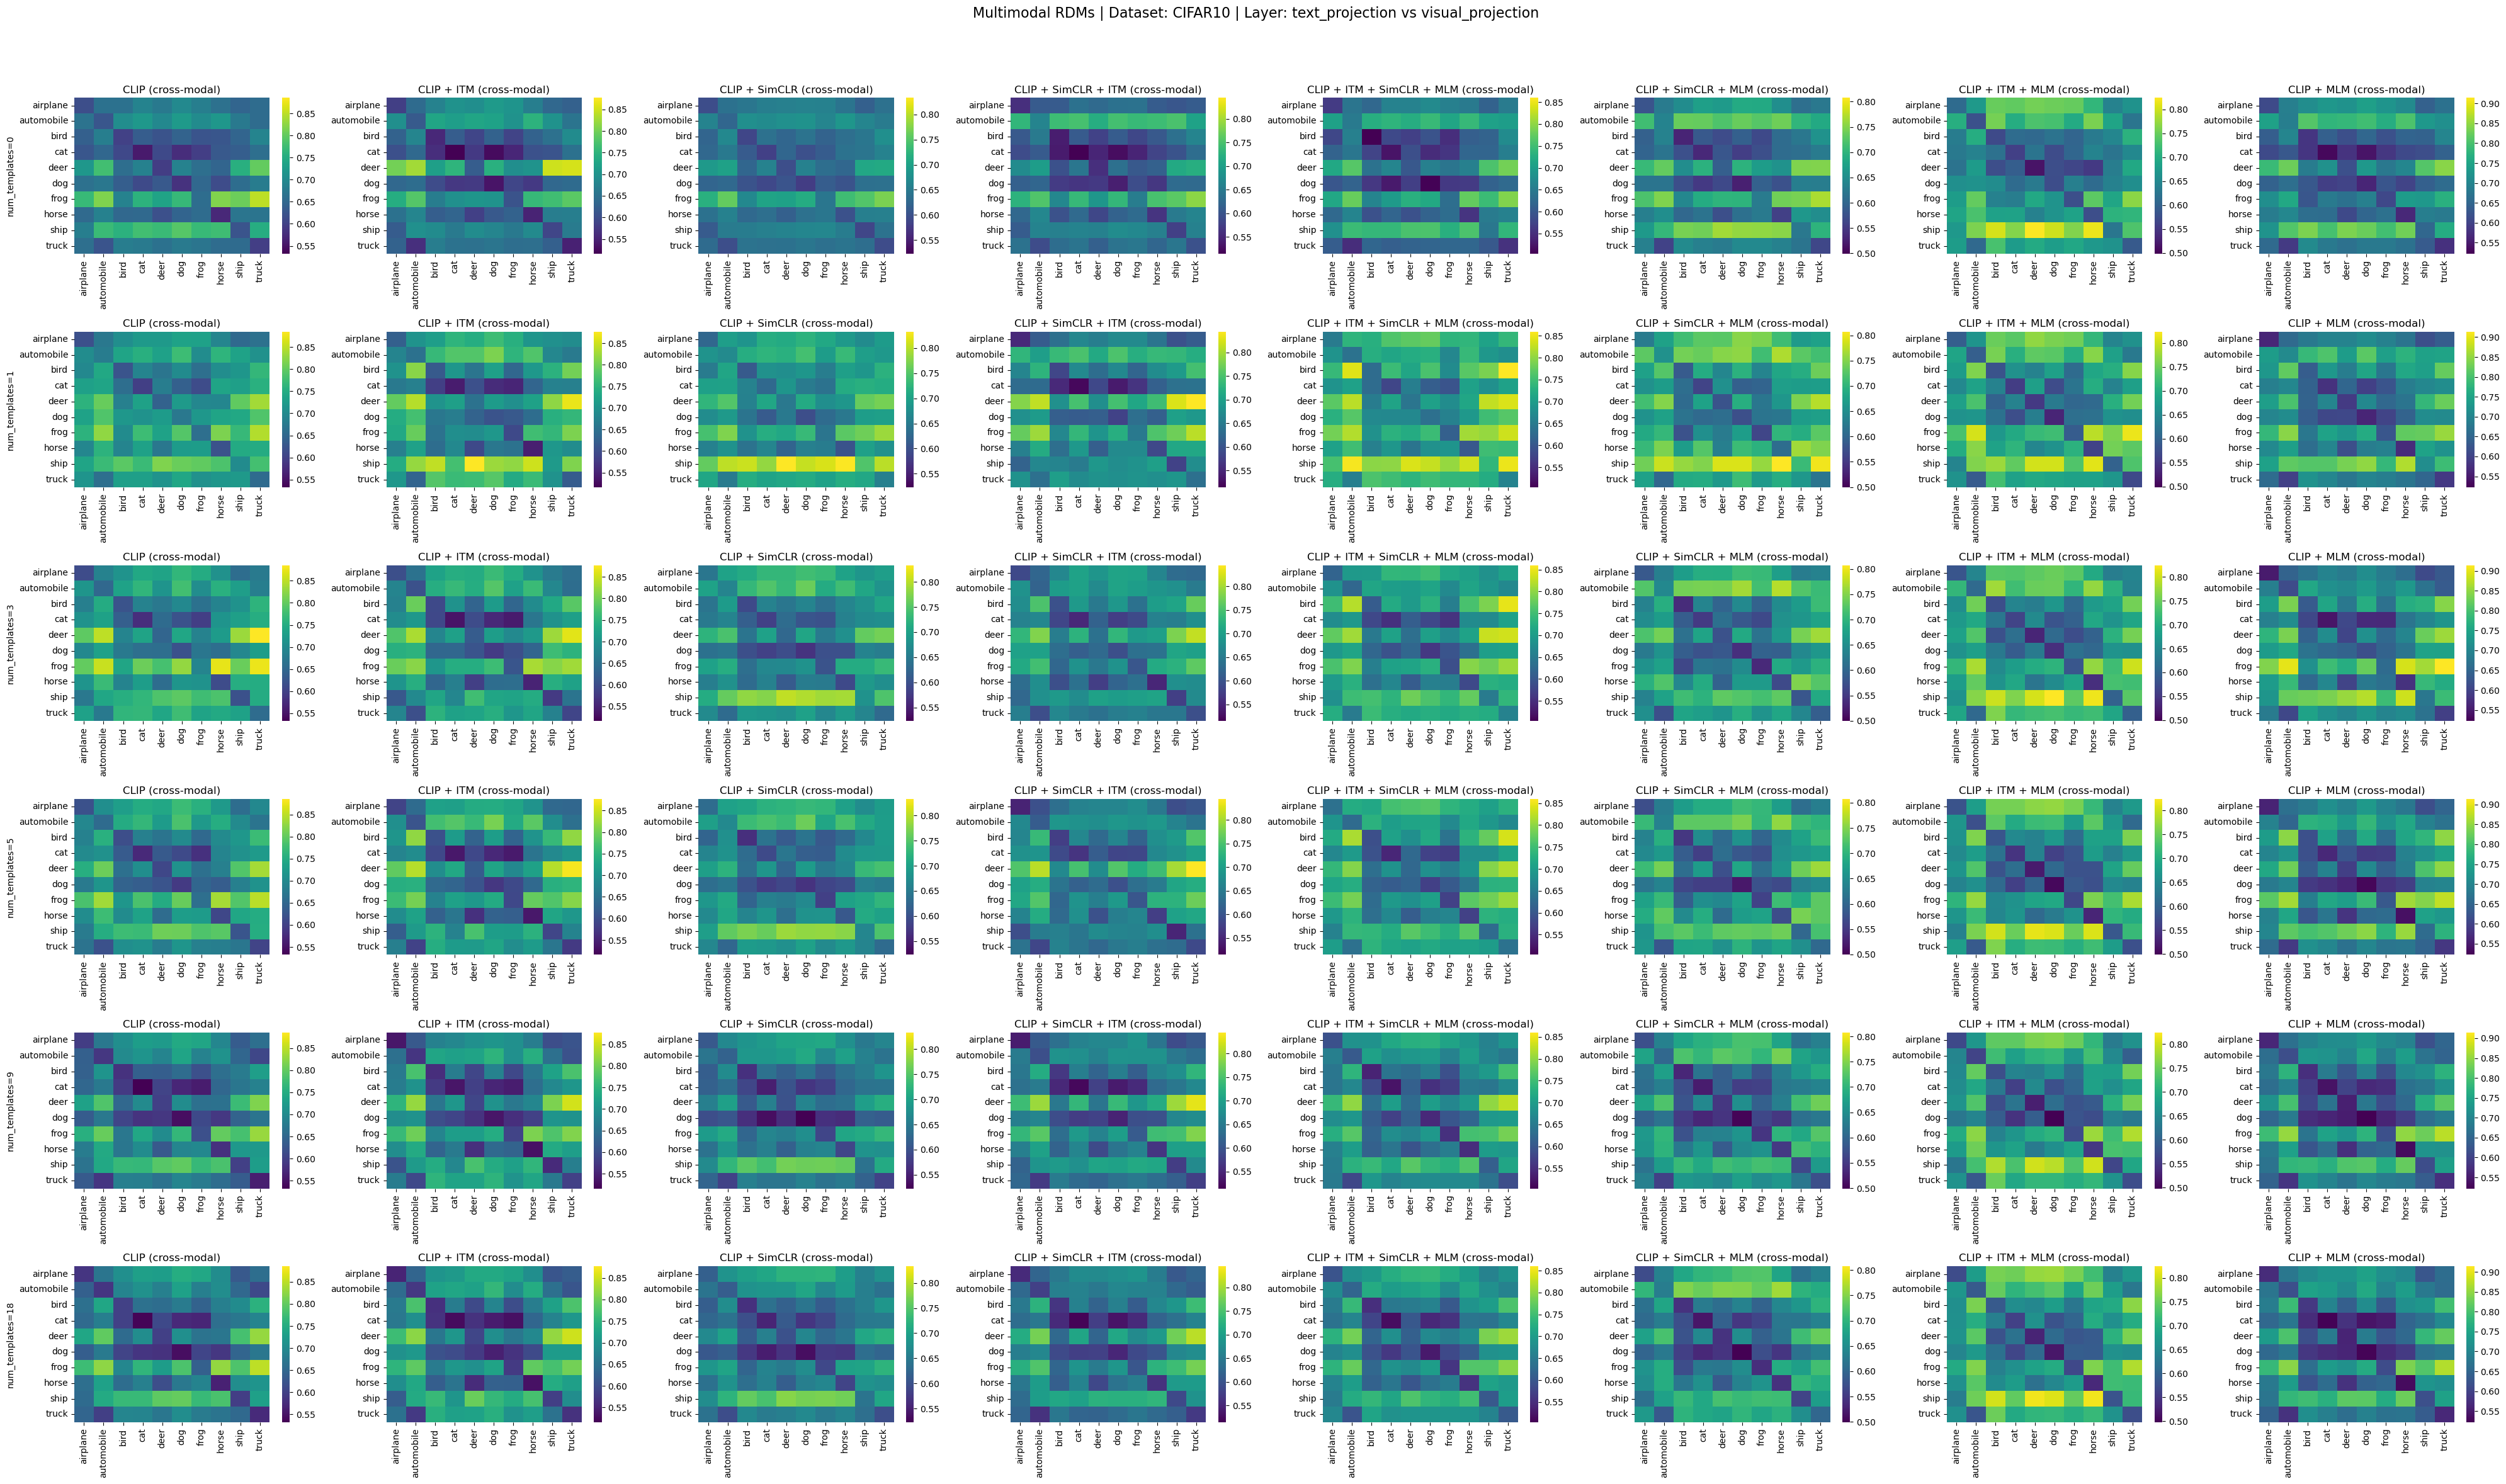

In [49]:
plot_rdms_by_layer_and_templates(
    representations=text_representations,
    layer="text_projection",
    representations2=visual_representations,
    layer2="visual_projection",
    classnames=classnames,
    dataset_name=dataset_name,
    metric="cosine",
    clip_only=True,
)

## RSA

### Visual: last encoder layer

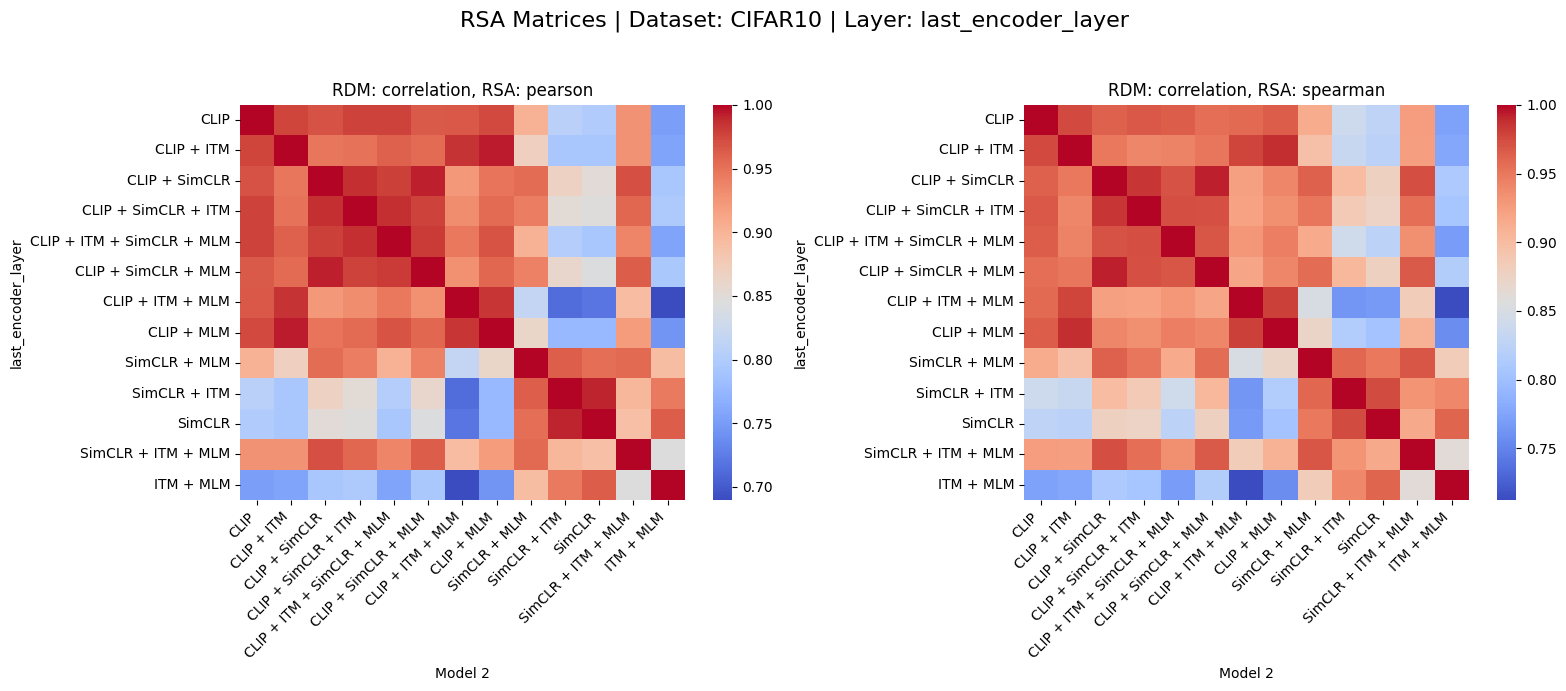

In [54]:
# vision_layer = "visual_projection"
vision_layer = "last_encoder_layer"

visual_representations_data = extract_layer_representations(visual_representations, vision_layer)

plot_rsa(visual_representations_data, rdm_metrics=["correlation"],
          rsa_metrics=["pearson", "spearman"],
          dataset_name=dataset_name, classnames=classnames, layer=vision_layer)

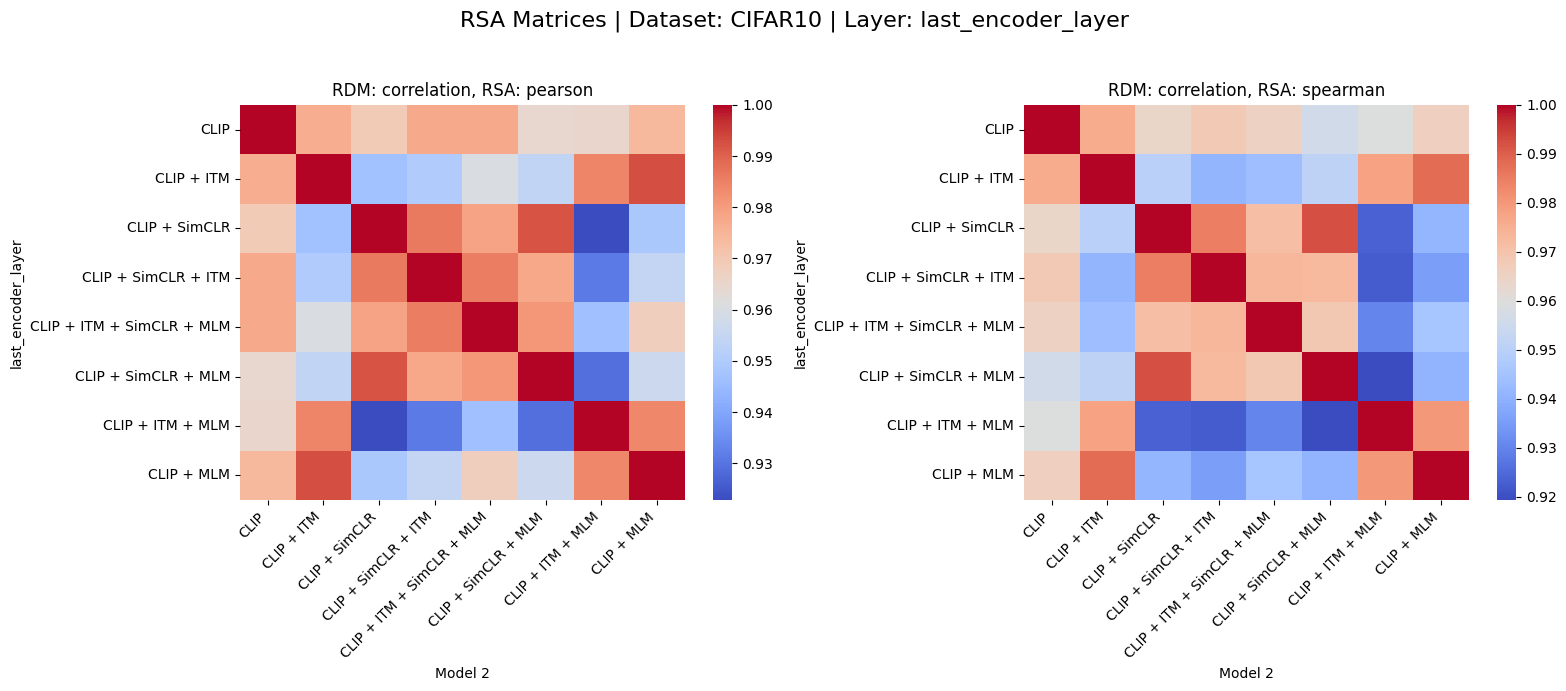

In [64]:
# vision_layer = "visual_projection"
vision_layer = "last_encoder_layer"
model_order = [ # full_dataset_aug
    "3burj4np", # CLIP
    "7m9tx2jf", # CLIP + ITM
    "95ddsmmz", # CLIP + SimCLR
    "ng70n4a4", # CLIP + SimCLR + ITM
    "tibwkymx", # CLIP + SimCLR + MLM + ITM
    "txva2y48", # CLIP + SimCLR + MLM
    "khb9ltyn", # CLIP + MLM + ITM
    "shf56cne", # CLIP + MLM
    ## below models are excluded
    "gtp8w6c4", # SimCLR + MLM
    "xpbl8wfc", # SimCLR + ITM
    "p99godxb", # SimCLR
    "bj2tw5qt", # SimCLR + ITM + MLM
    "mkqp8hhx", # ITM + MLM
]
exclude_models = [
    "gtp8w6c4", # SimCLR + MLM
    "xpbl8wfc", # SimCLR + ITM
    "p99godxb", # SimCLR
    "bj2tw5qt", # SimCLR + ITM + MLM
    "mkqp8hhx", # ITM + MLM
]

visual_representations_data = extract_layer_representations(visual_representations, vision_layer, model_order=model_order, exclude_models=exclude_models)

plot_rsa(visual_representations_data, rdm_metrics=["correlation"],
          rsa_metrics=["pearson", "spearman"],
          dataset_name=dataset_name, classnames=classnames, layer=vision_layer)

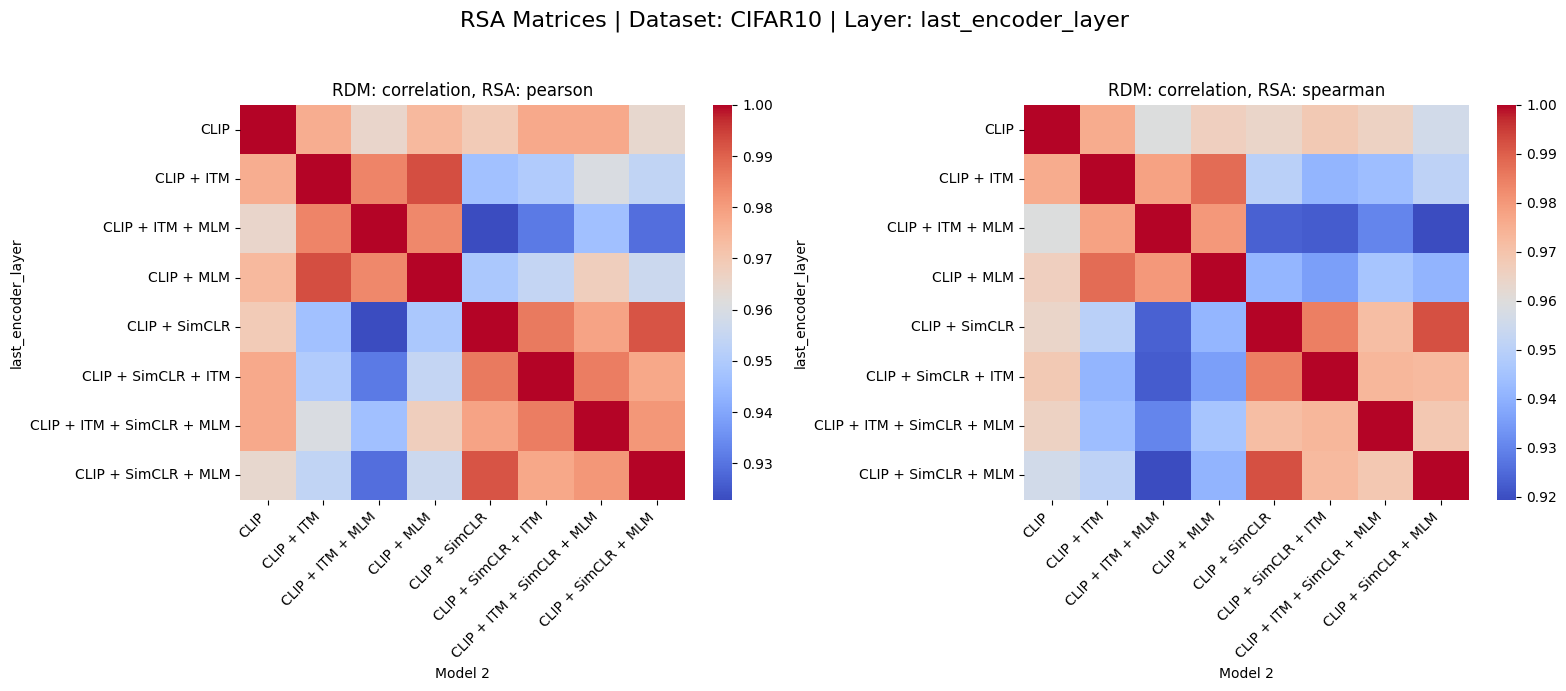

In [44]:
# vision_layer = "visual_projection"
vision_layer = "last_encoder_layer"
model_order = [ # full_dataset_aug
    "3burj4np", # CLIP
    "7m9tx2jf", # CLIP + ITM
    "khb9ltyn", # CLIP + MLM + ITM
    "shf56cne", # CLIP + MLM
    "95ddsmmz", # CLIP + SimCLR
    "ng70n4a4", # CLIP + SimCLR + ITM
    "tibwkymx", # CLIP + SimCLR + MLM + ITM
    "txva2y48", # CLIP + SimCLR + MLM    
    ## below models are excluded
    "gtp8w6c4", # SimCLR + MLM
    "xpbl8wfc", # SimCLR + ITM
    "p99godxb", # SimCLR
    "bj2tw5qt", # SimCLR + ITM + MLM
    "mkqp8hhx", # ITM + MLM
]
exclude_models = [
    "gtp8w6c4", # SimCLR + MLM
    "xpbl8wfc", # SimCLR + ITM
    "p99godxb", # SimCLR
    "bj2tw5qt", # SimCLR + ITM + MLM
    "mkqp8hhx", # ITM + MLM
]

visual_representations_data = extract_layer_representations(visual_representations, vision_layer, model_order=model_order, exclude_models=exclude_models)

plot_rsa(visual_representations_data, rdm_metrics=["correlation"],
          rsa_metrics=["pearson", "spearman"],
          dataset_name=dataset_name, classnames=classnames, layer=vision_layer)

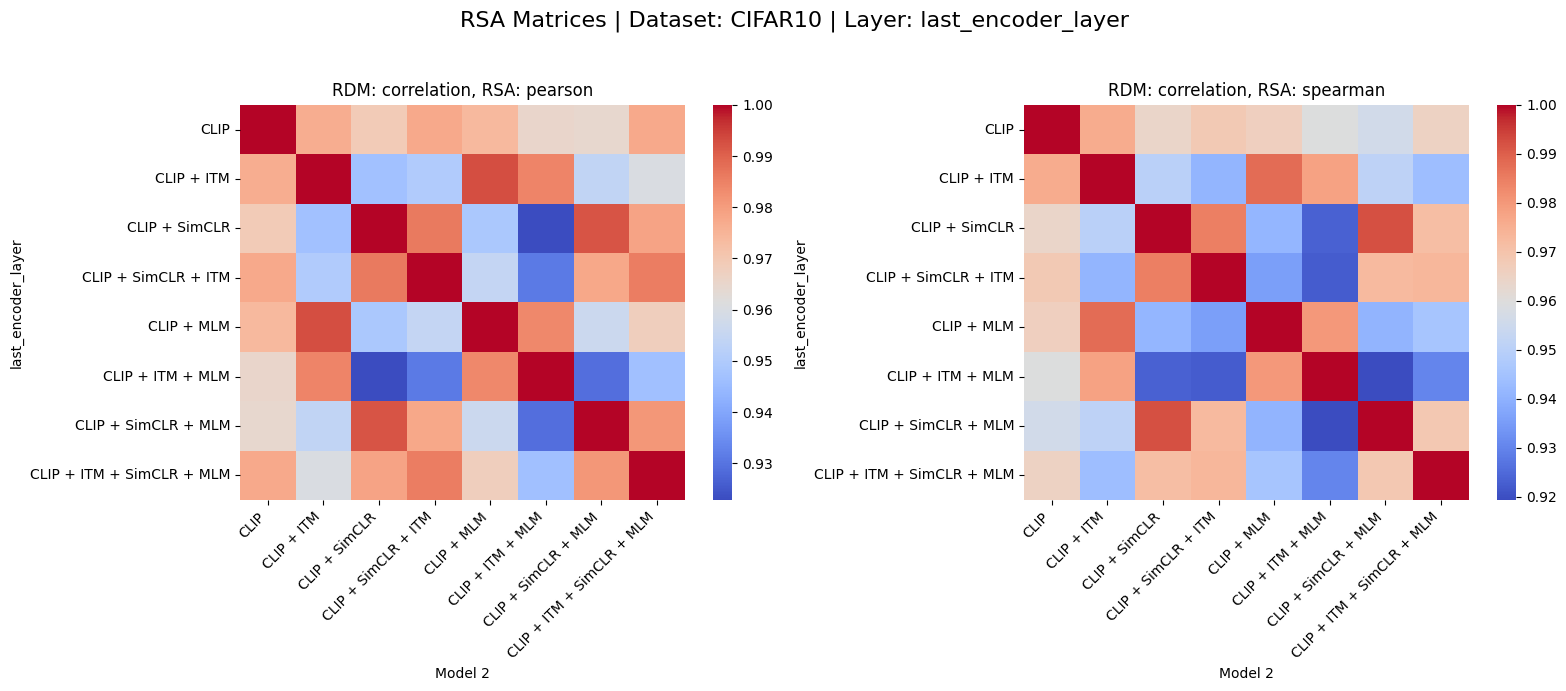

In [45]:
# vision_layer = "visual_projection"
vision_layer = "last_encoder_layer"
model_order = [ # full_dataset_aug
    "3burj4np", # CLIP
    "7m9tx2jf", # CLIP + ITM  
    "95ddsmmz", # CLIP + SimCLR
    "ng70n4a4", # CLIP + SimCLR + ITM  
    "shf56cne", # CLIP + MLM
    "khb9ltyn", # CLIP + MLM + ITM
    "txva2y48", # CLIP + SimCLR + MLM   
    "tibwkymx", # CLIP + SimCLR + MLM + ITM 
    ## below models are excluded
    "gtp8w6c4", # SimCLR + MLM
    "xpbl8wfc", # SimCLR + ITM
    "p99godxb", # SimCLR
    "bj2tw5qt", # SimCLR + ITM + MLM
    "mkqp8hhx", # ITM + MLM
]
exclude_models = [
    "gtp8w6c4", # SimCLR + MLM
    "xpbl8wfc", # SimCLR + ITM
    "p99godxb", # SimCLR
    "bj2tw5qt", # SimCLR + ITM + MLM
    "mkqp8hhx", # ITM + MLM
]

visual_representations_data = extract_layer_representations(visual_representations, vision_layer, model_order=model_order, exclude_models=exclude_models)

plot_rsa(visual_representations_data, rdm_metrics=["correlation"],
          rsa_metrics=["pearson", "spearman"],
          dataset_name=dataset_name, classnames=classnames, layer=vision_layer)

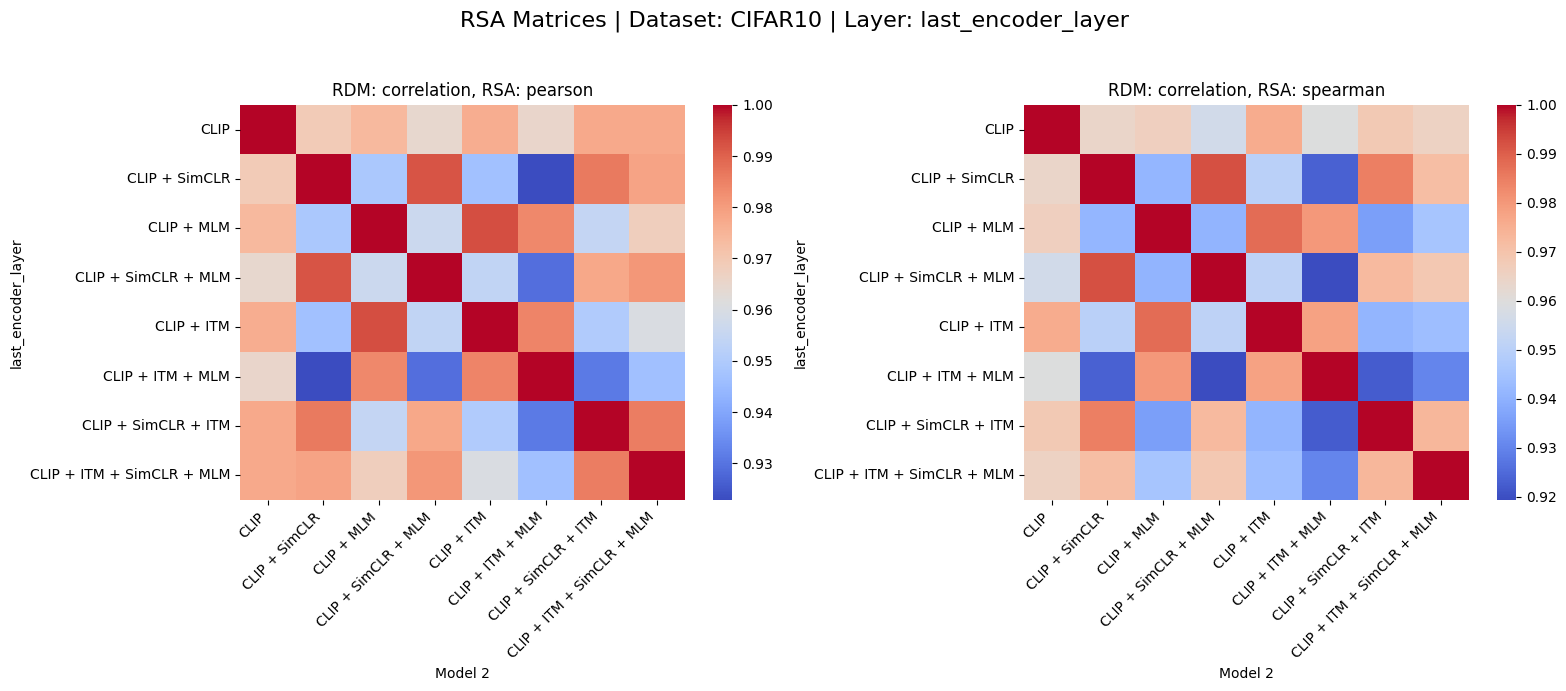

In [46]:
# vision_layer = "visual_projection"
vision_layer = "last_encoder_layer"
model_order = [ # full_dataset_aug
    "3burj4np", # CLIP
    "95ddsmmz", # CLIP + SimCLR  
    "shf56cne", # CLIP + MLM
    "txva2y48", # CLIP + SimCLR + MLM   
    "7m9tx2jf", # CLIP + ITM
    "khb9ltyn", # CLIP + MLM + ITM
    "ng70n4a4", # CLIP + SimCLR + ITM
    "tibwkymx", # CLIP + SimCLR + MLM + ITM 
    ## below models are excluded
    "gtp8w6c4", # SimCLR + MLM
    "xpbl8wfc", # SimCLR + ITM
    "p99godxb", # SimCLR
    "bj2tw5qt", # SimCLR + ITM + MLM
    "mkqp8hhx", # ITM + MLM
]
exclude_models = [
    "gtp8w6c4", # SimCLR + MLM
    "xpbl8wfc", # SimCLR + ITM
    "p99godxb", # SimCLR
    "bj2tw5qt", # SimCLR + ITM + MLM
    "mkqp8hhx", # ITM + MLM
]

visual_representations_data = extract_layer_representations(visual_representations, vision_layer, model_order=model_order, exclude_models=exclude_models)

plot_rsa(visual_representations_data, rdm_metrics=["correlation"],
          rsa_metrics=["pearson", "spearman"],
          dataset_name=dataset_name, classnames=classnames, layer=vision_layer)

### Visual: projection layer

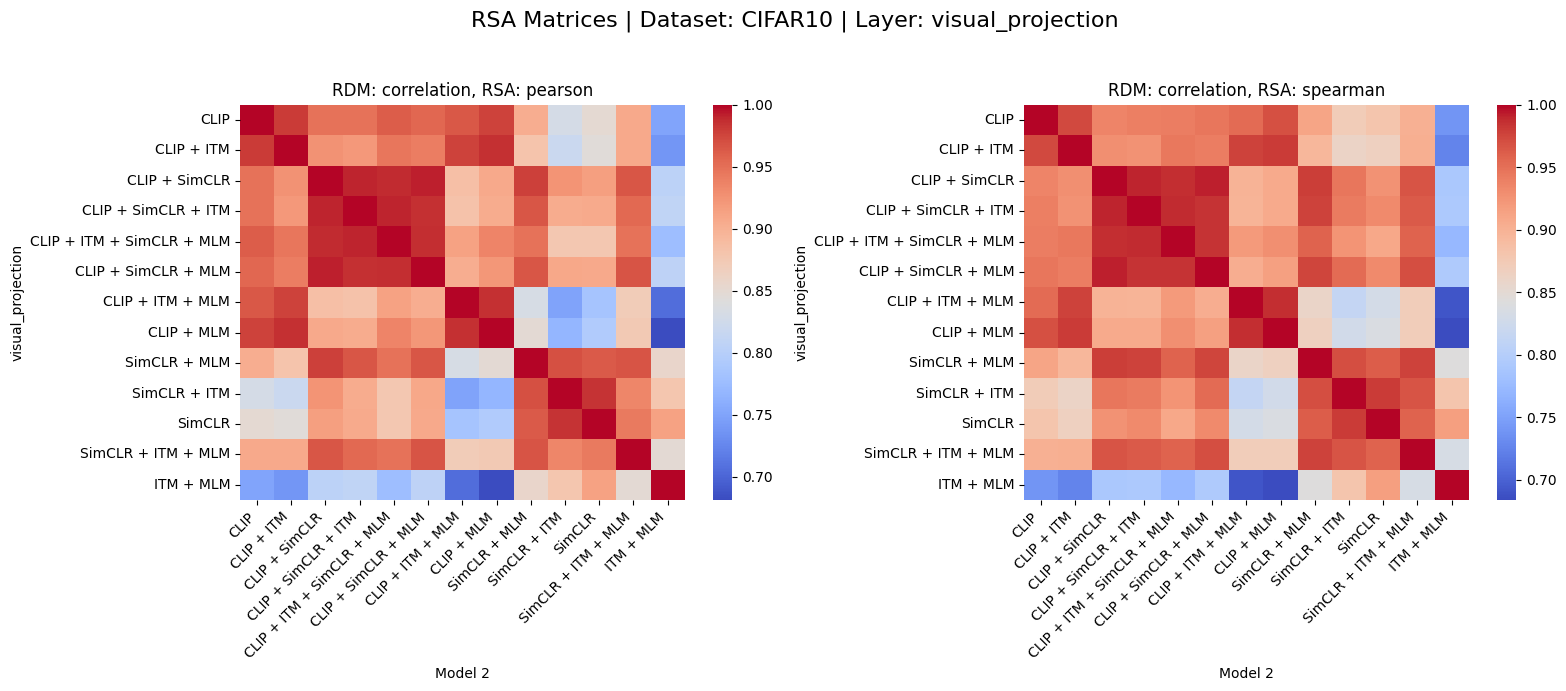

In [55]:
vision_layer = "visual_projection"

visual_representations_data = extract_layer_representations(visual_representations, vision_layer)

plot_rsa(visual_representations_data, rdm_metrics=["correlation"],
          rsa_metrics=["pearson", "spearman"],
          dataset_name=dataset_name, classnames=classnames, layer=vision_layer)

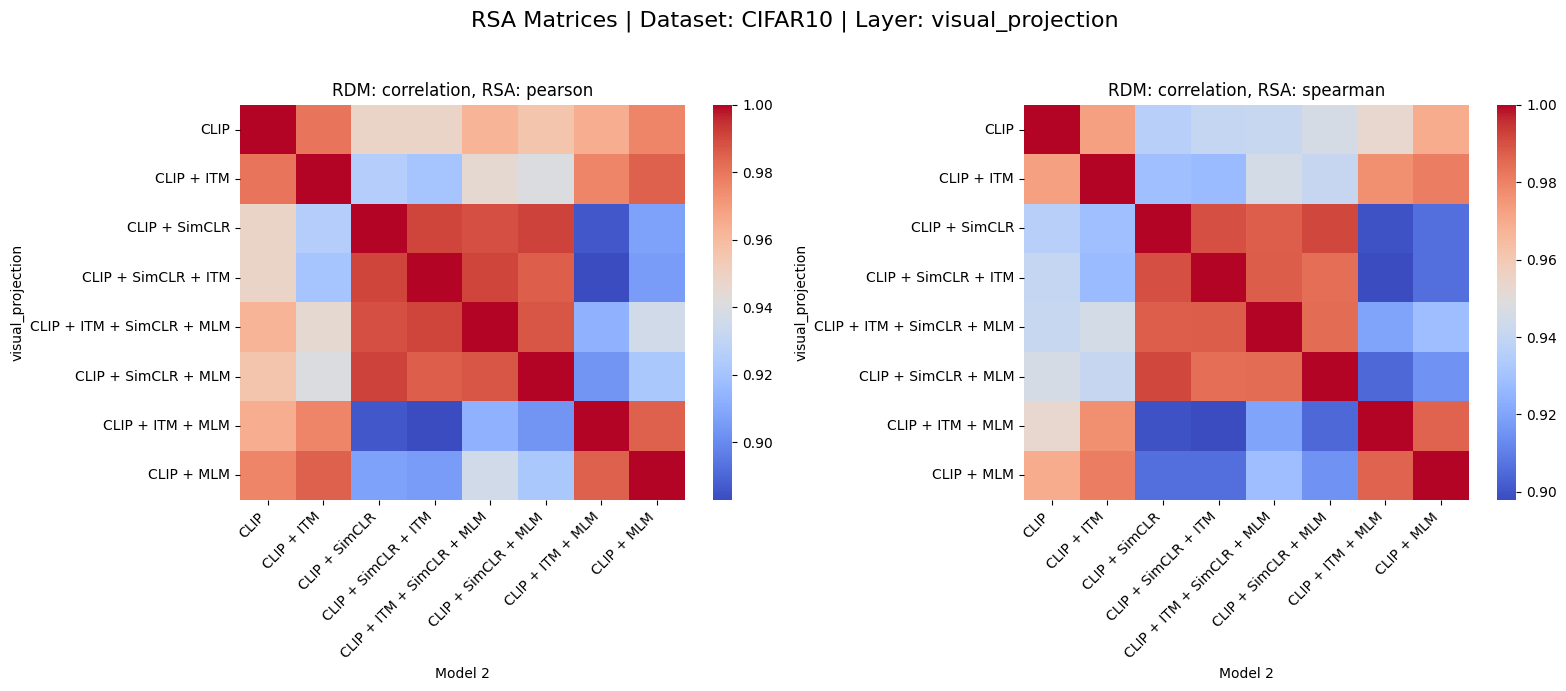

In [65]:
vision_layer = "visual_projection"
model_order = [ # full_dataset_aug
    "3burj4np", # CLIP
    "7m9tx2jf", # CLIP + ITM
    "95ddsmmz", # CLIP + SimCLR
    "ng70n4a4", # CLIP + SimCLR + ITM
    "tibwkymx", # CLIP + SimCLR + MLM + ITM
    "txva2y48", # CLIP + SimCLR + MLM
    "khb9ltyn", # CLIP + MLM + ITM
    "shf56cne", # CLIP + MLM
    ## below models are excluded
    "gtp8w6c4", # SimCLR + MLM
    "xpbl8wfc", # SimCLR + ITM
    "p99godxb", # SimCLR
    "bj2tw5qt", # SimCLR + ITM + MLM
    "mkqp8hhx", # ITM + MLM
]
exclude_models = [
    "gtp8w6c4", # SimCLR + MLM
    "xpbl8wfc", # SimCLR + ITM
    "p99godxb", # SimCLR
    "bj2tw5qt", # SimCLR + ITM + MLM
    "mkqp8hhx", # ITM + MLM
]

visual_representations_data = extract_layer_representations(visual_representations, vision_layer, model_order=model_order, exclude_models=exclude_models)

plot_rsa(visual_representations_data, rdm_metrics=["correlation"],
          rsa_metrics=["pearson", "spearman"],
          dataset_name=dataset_name, classnames=classnames, layer=vision_layer)

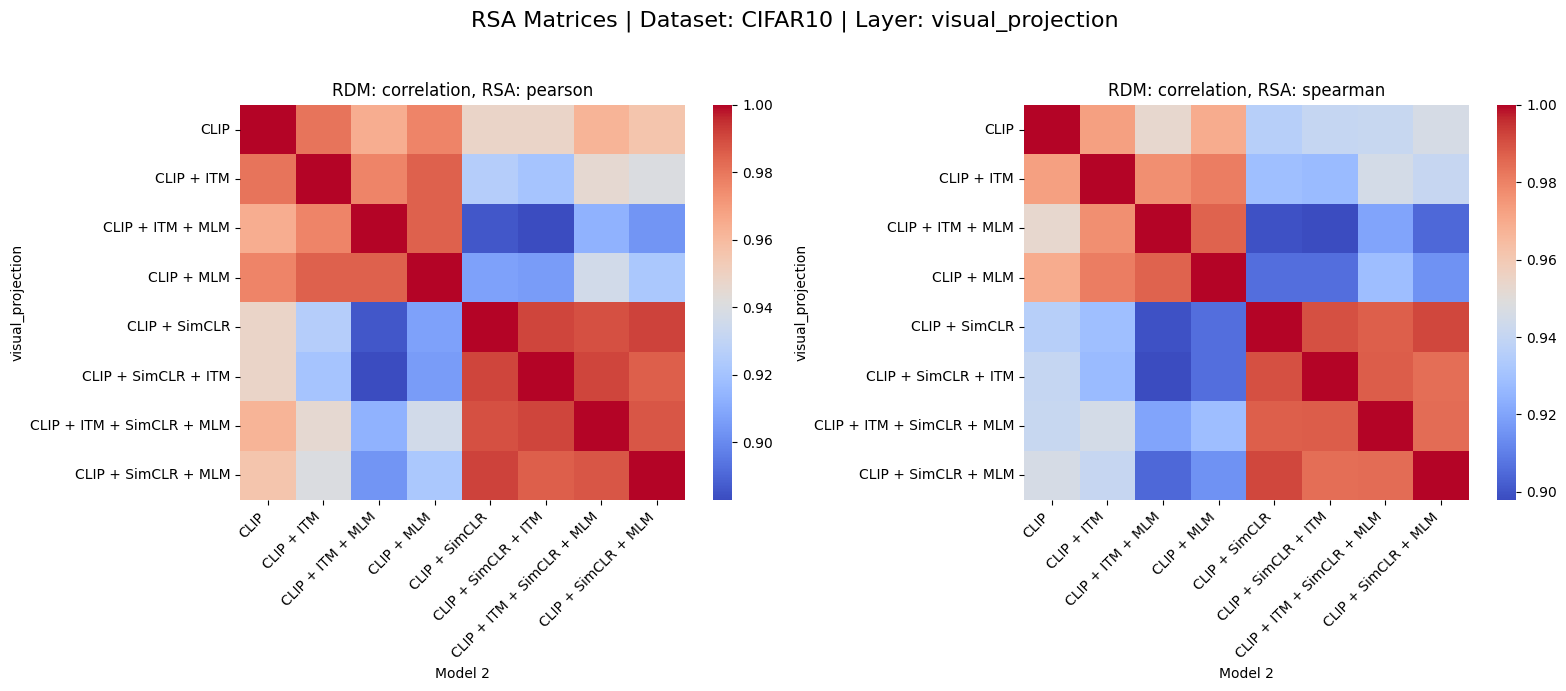

In [47]:
vision_layer = "visual_projection"
# vision_layer = "last_encoder_layer"
model_order = [ # full_dataset_aug
    "3burj4np", # CLIP
    "7m9tx2jf", # CLIP + ITM
    "khb9ltyn", # CLIP + MLM + ITM
    "shf56cne", # CLIP + MLM
    "95ddsmmz", # CLIP + SimCLR
    "ng70n4a4", # CLIP + SimCLR + ITM
    "tibwkymx", # CLIP + SimCLR + MLM + ITM
    "txva2y48", # CLIP + SimCLR + MLM    
    ## below models are excluded
    "gtp8w6c4", # SimCLR + MLM
    "xpbl8wfc", # SimCLR + ITM
    "p99godxb", # SimCLR
    "bj2tw5qt", # SimCLR + ITM + MLM
    "mkqp8hhx", # ITM + MLM
]
exclude_models = [
    "gtp8w6c4", # SimCLR + MLM
    "xpbl8wfc", # SimCLR + ITM
    "p99godxb", # SimCLR
    "bj2tw5qt", # SimCLR + ITM + MLM
    "mkqp8hhx", # ITM + MLM
]

visual_representations_data = extract_layer_representations(visual_representations, vision_layer, model_order=model_order, exclude_models=exclude_models)

plot_rsa(visual_representations_data, rdm_metrics=["correlation"],
          rsa_metrics=["pearson", "spearman"],
          dataset_name=dataset_name, classnames=classnames, layer=vision_layer)

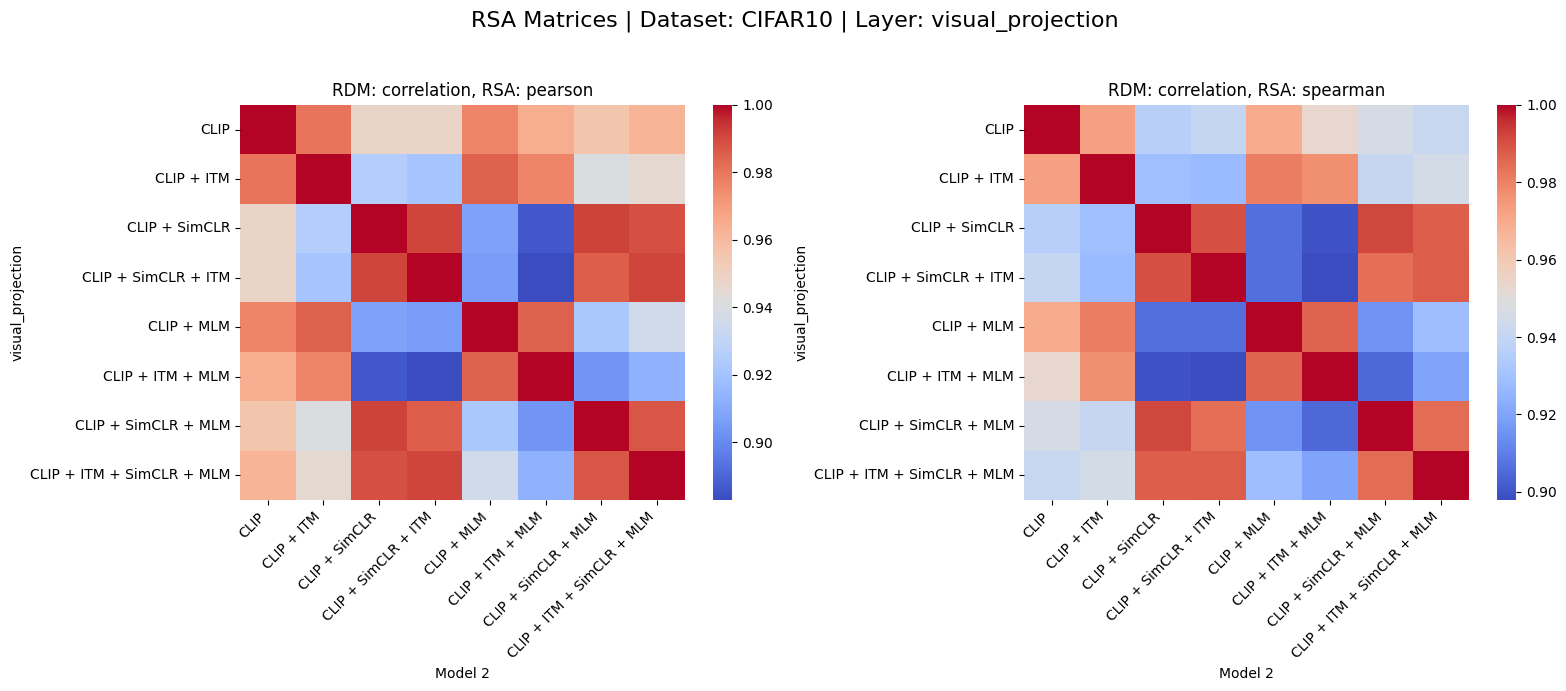

In [48]:
vision_layer = "visual_projection"
# vision_layer = "last_encoder_layer"
model_order = [ # full_dataset_aug
    "3burj4np", # CLIP
    "7m9tx2jf", # CLIP + ITM  
    "95ddsmmz", # CLIP + SimCLR
    "ng70n4a4", # CLIP + SimCLR + ITM  
    "shf56cne", # CLIP + MLM
    "khb9ltyn", # CLIP + MLM + ITM
    "txva2y48", # CLIP + SimCLR + MLM   
    "tibwkymx", # CLIP + SimCLR + MLM + ITM 
    ## below models are excluded
    "gtp8w6c4", # SimCLR + MLM
    "xpbl8wfc", # SimCLR + ITM
    "p99godxb", # SimCLR
    "bj2tw5qt", # SimCLR + ITM + MLM
    "mkqp8hhx", # ITM + MLM
]
exclude_models = [
    "gtp8w6c4", # SimCLR + MLM
    "xpbl8wfc", # SimCLR + ITM
    "p99godxb", # SimCLR
    "bj2tw5qt", # SimCLR + ITM + MLM
    "mkqp8hhx", # ITM + MLM
]

visual_representations_data = extract_layer_representations(visual_representations, vision_layer, model_order=model_order, exclude_models=exclude_models)

plot_rsa(visual_representations_data, rdm_metrics=["correlation"],
          rsa_metrics=["pearson", "spearman"],
          dataset_name=dataset_name, classnames=classnames, layer=vision_layer)

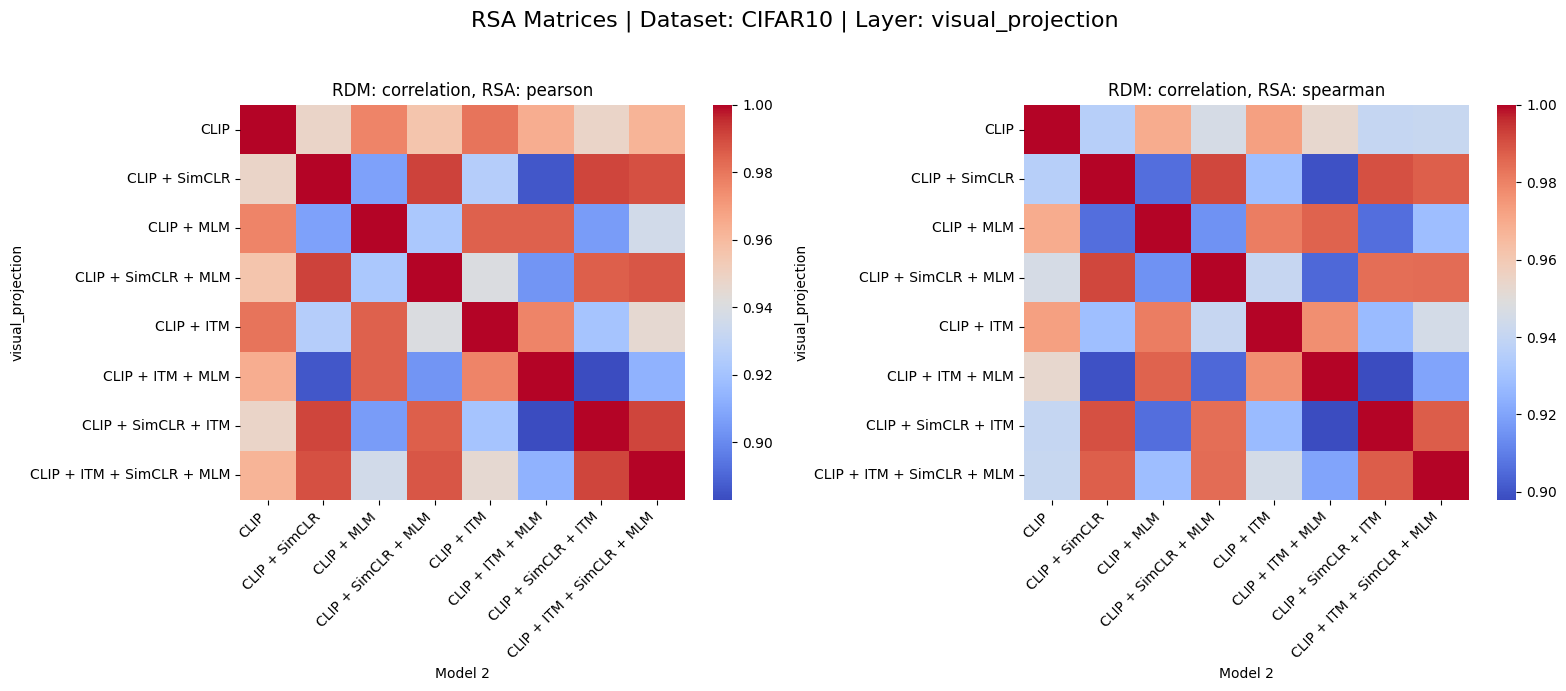

In [49]:
vision_layer = "visual_projection"
# vision_layer = "last_encoder_layer"
model_order = [ # full_dataset_aug
    "3burj4np", # CLIP
    "95ddsmmz", # CLIP + SimCLR  
    "shf56cne", # CLIP + MLM
    "txva2y48", # CLIP + SimCLR + MLM   
    "7m9tx2jf", # CLIP + ITM
    "khb9ltyn", # CLIP + MLM + ITM
    "ng70n4a4", # CLIP + SimCLR + ITM
    "tibwkymx", # CLIP + SimCLR + MLM + ITM 
    ## below models are excluded
    "gtp8w6c4", # SimCLR + MLM
    "xpbl8wfc", # SimCLR + ITM
    "p99godxb", # SimCLR
    "bj2tw5qt", # SimCLR + ITM + MLM
    "mkqp8hhx", # ITM + MLM
]
exclude_models = [
    "gtp8w6c4", # SimCLR + MLM
    "xpbl8wfc", # SimCLR + ITM
    "p99godxb", # SimCLR
    "bj2tw5qt", # SimCLR + ITM + MLM
    "mkqp8hhx", # ITM + MLM
]

visual_representations_data = extract_layer_representations(visual_representations, vision_layer, model_order=model_order, exclude_models=exclude_models)

plot_rsa(visual_representations_data, rdm_metrics=["correlation"],
          rsa_metrics=["pearson", "spearman"],
          dataset_name=dataset_name, classnames=classnames, layer=vision_layer)

### Text: projection layer

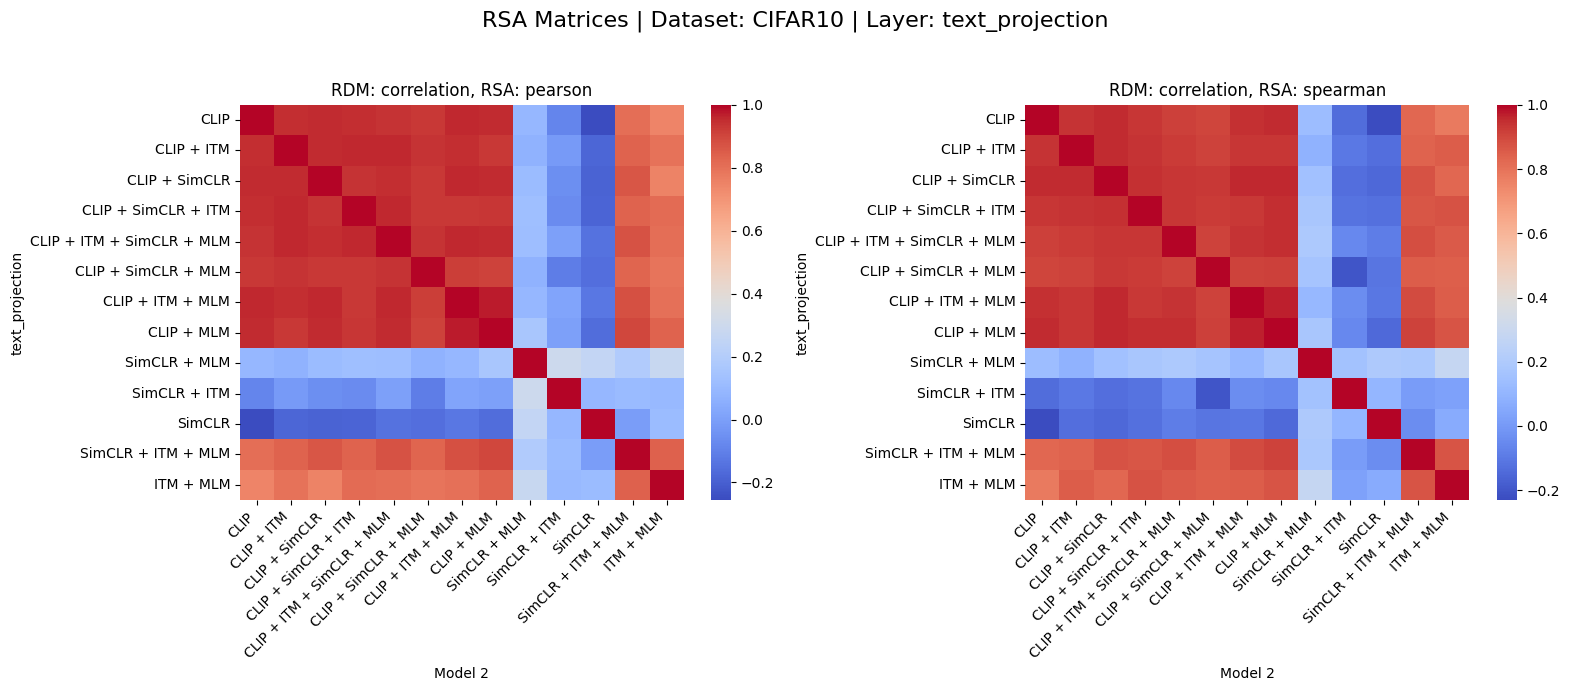

In [57]:
text_layer = "text_projection"
num_templates = 9

text_representations_data = extract_layer_representations(text_representations, layer=text_layer, num_templates=num_templates)

plot_rsa(text_representations_data, rdm_metrics=["correlation"],
          rsa_metrics=["pearson", "spearman"],
          dataset_name=dataset_name, classnames=classnames, layer=text_layer)

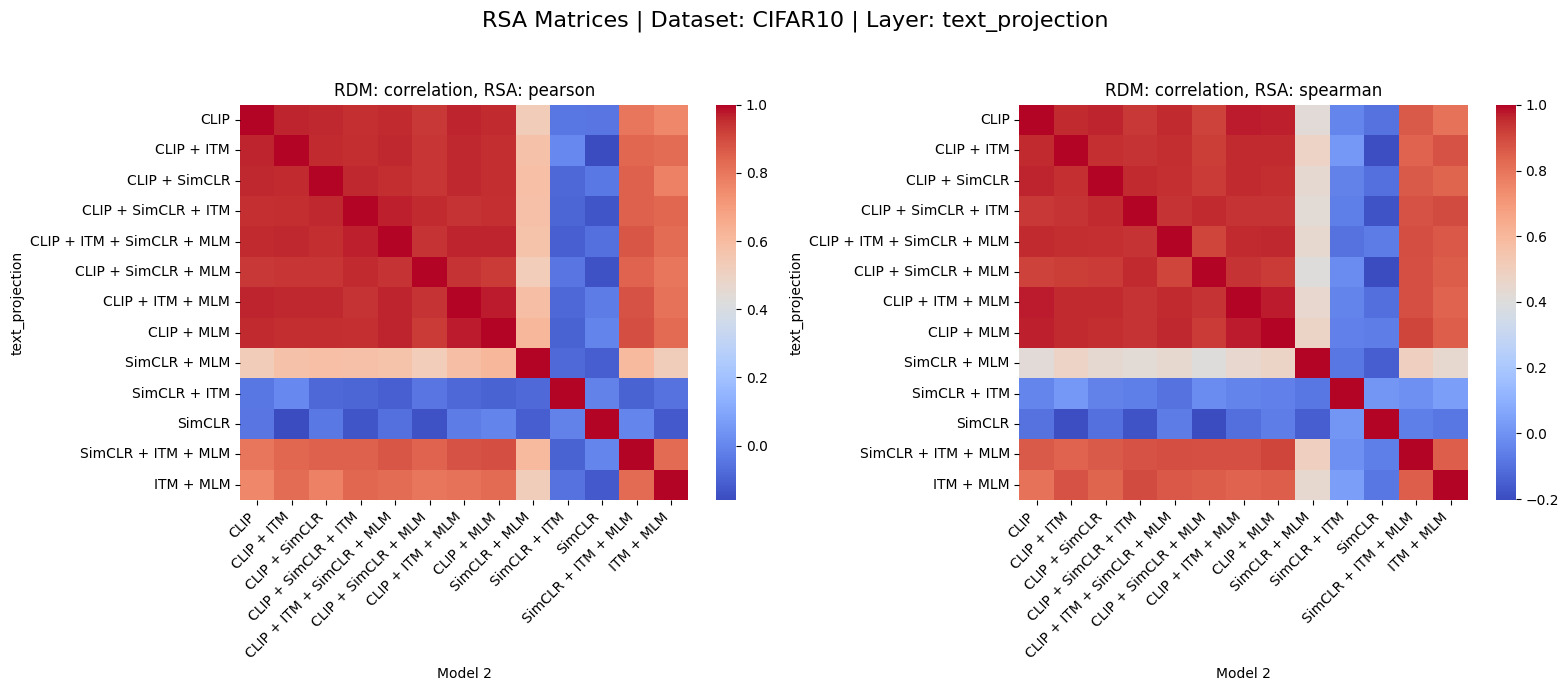

In [59]:
text_layer = "text_projection"
num_templates = 18

text_representations_data = extract_layer_representations(text_representations, layer=text_layer, num_templates=num_templates)

plot_rsa(text_representations_data, rdm_metrics=["correlation"],
          rsa_metrics=["pearson", "spearman"],
          dataset_name=dataset_name, classnames=classnames, layer=text_layer)

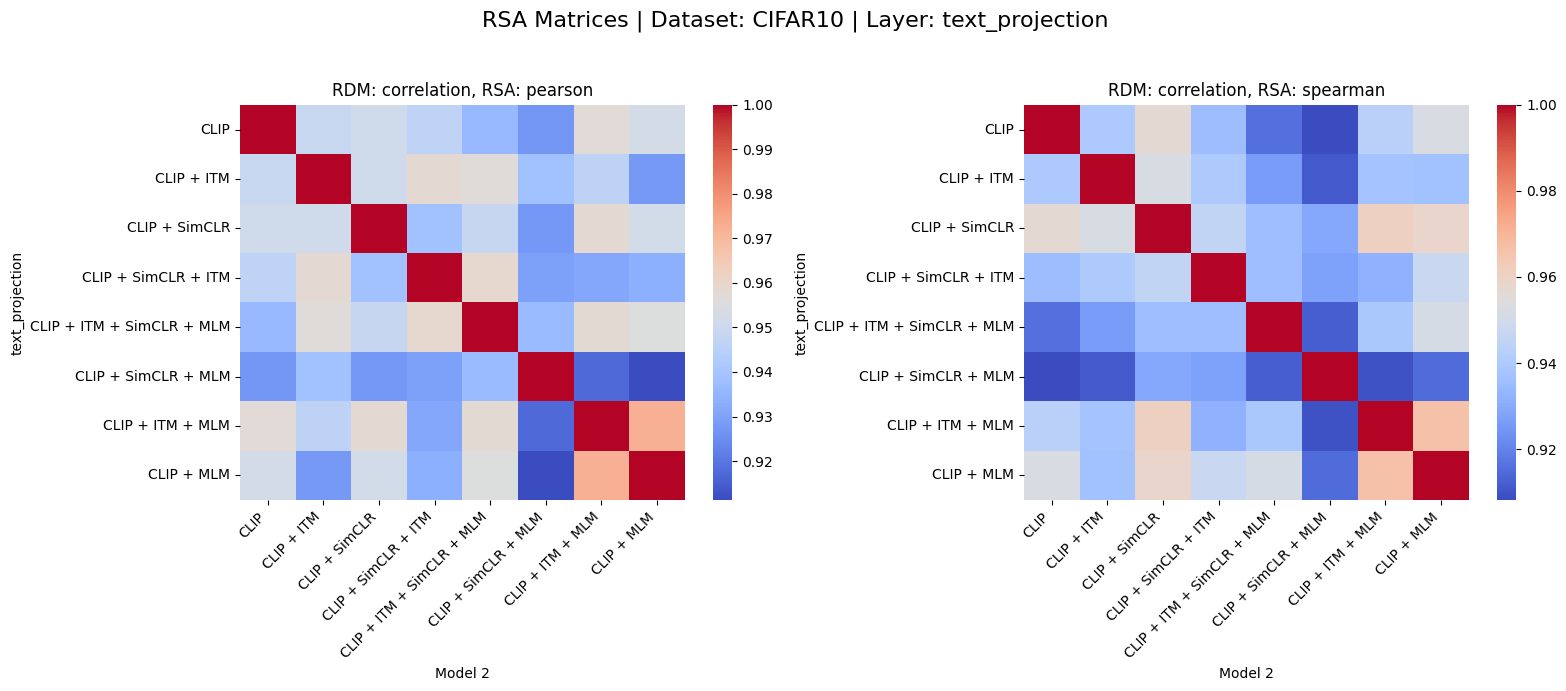

In [38]:
text_layer = "text_projection"
num_templates = 9

model_order = [ # full_dataset_aug
    "3burj4np", # CLIP
    "7m9tx2jf", # CLIP + ITM
    "95ddsmmz", # CLIP + SimCLR
    "ng70n4a4", # CLIP + SimCLR + ITM
    "tibwkymx", # CLIP + SimCLR + MLM + ITM
    "txva2y48", # CLIP + SimCLR + MLM
    "khb9ltyn", # CLIP + MLM + ITM
    "shf56cne", # CLIP + MLM
    ## below models are excluded
    "gtp8w6c4", # SimCLR + MLM
    "xpbl8wfc", # SimCLR + ITM
    "p99godxb", # SimCLR
    "bj2tw5qt", # SimCLR + ITM + MLM
    "mkqp8hhx", # ITM + MLM
]
exclude_models = [
    "gtp8w6c4", # SimCLR + MLM
    "xpbl8wfc", # SimCLR + ITM
    "p99godxb", # SimCLR
    "bj2tw5qt", # SimCLR + ITM + MLM
    "mkqp8hhx", # ITM + MLM
]

text_representations_data = extract_layer_representations(text_representations, layer=text_layer, num_templates=num_templates, model_order=model_order, exclude_models=exclude_models)

plot_rsa(text_representations_data, rdm_metrics=["correlation"],
          rsa_metrics=["pearson", "spearman"],
          dataset_name=dataset_name, classnames=classnames, layer=text_layer)

### Visual & Text: projection layer

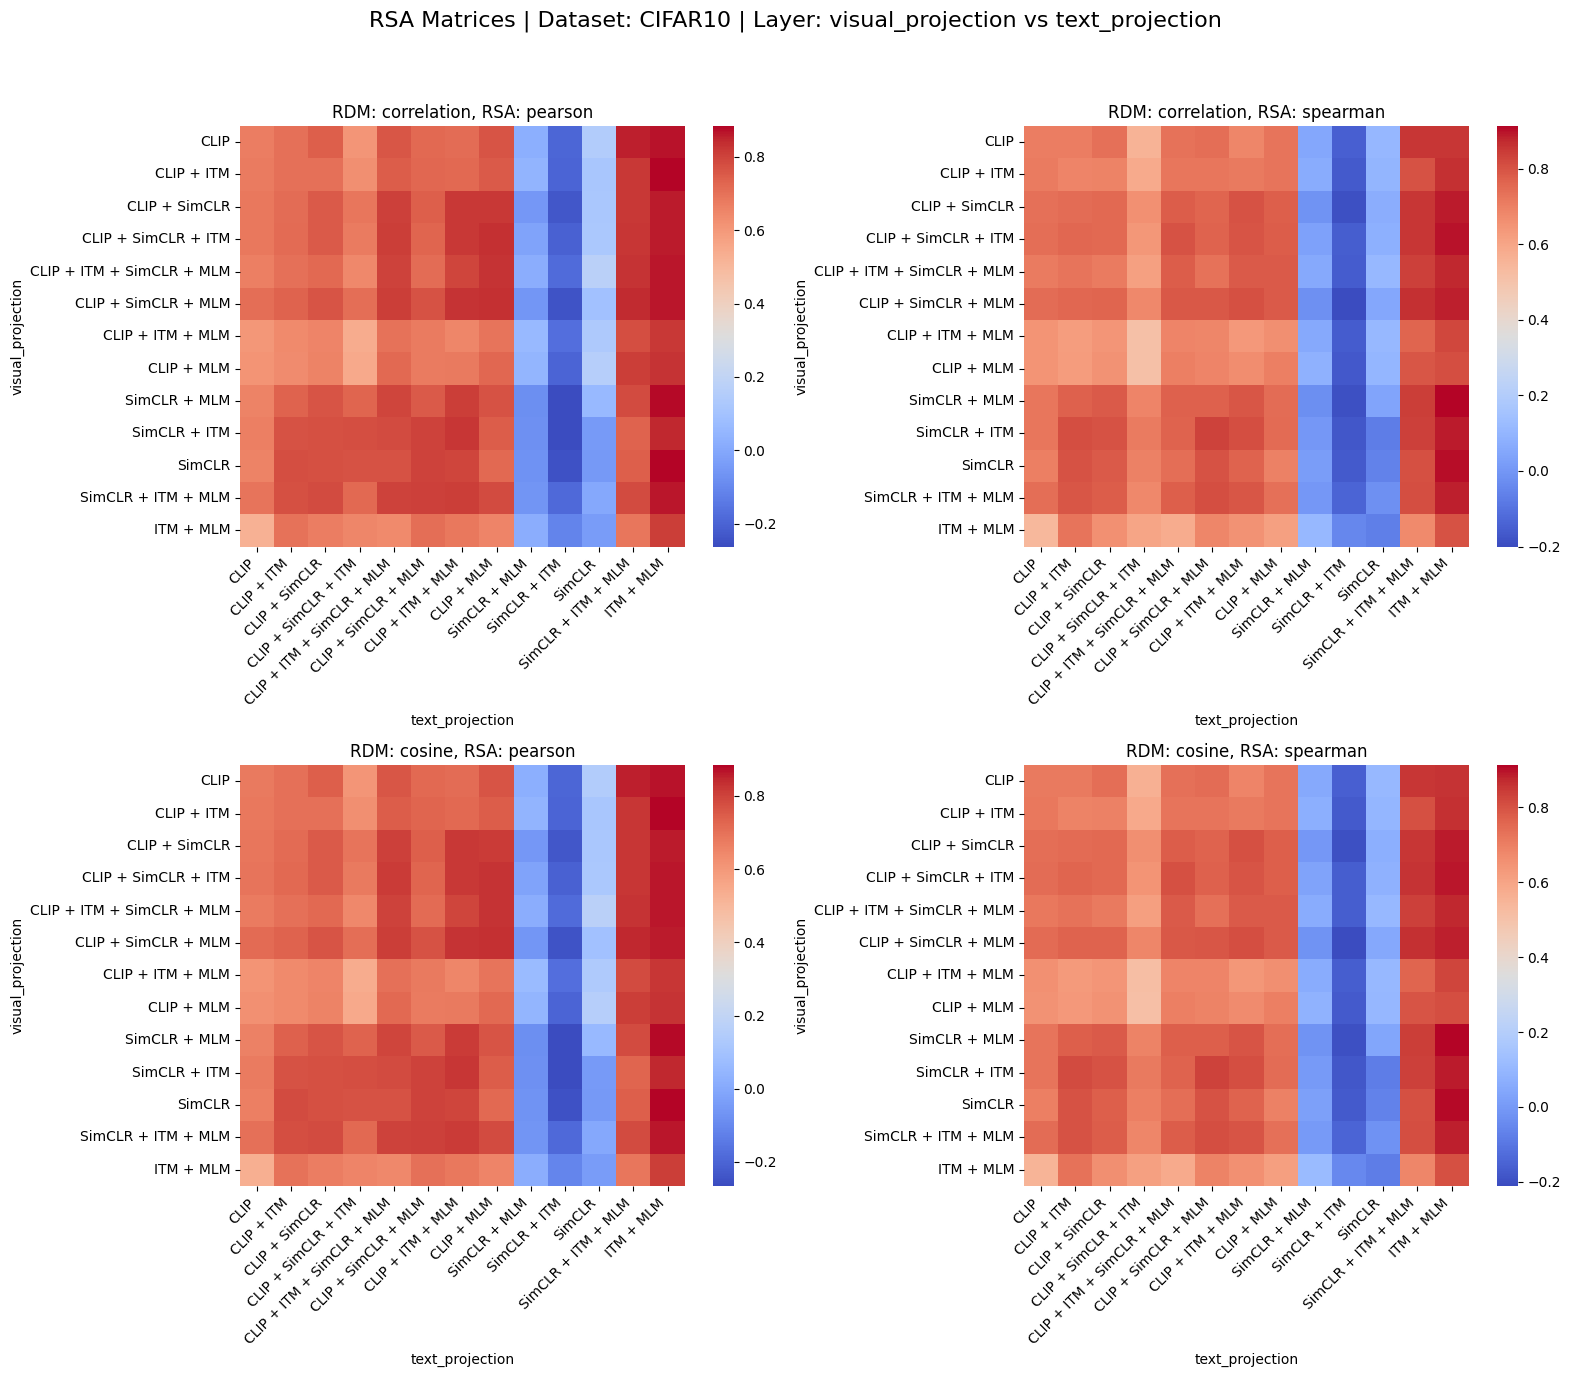

In [53]:
vision_layer = "visual_projection"
text_layer = "text_projection"
num_templates = 1

visual_representations_data = extract_layer_representations(visual_representations, vision_layer)
text_representations_data = extract_layer_representations(text_representations, layer=text_layer, num_templates=num_templates)

plot_rsa(visual_representations_data, text_representations_data, rdm_metrics=["correlation", "cosine"],
          rsa_metrics=["pearson", "spearman"],
          dataset_name=dataset_name, classnames=classnames, layer=vision_layer, layer2=text_layer)

In [83]:
import pickle

# Example: open a pickle file and load its content
pickle_file_path = "/home/phisch/multimodal/data/representations/CIFAR10/full_dataset_aug_mlm/CIFAR10-3burj4np-text_representations.pkl"
with open(pickle_file_path, "rb") as f:
    data = pickle.load(f)

print(type(data))
# Print the "templates" field for each entry in data["representations"]
for i, entry in enumerate(data["representations"]):
    print(entry["layer"])
    print(f"Entry {i} templates:", len(entry["templates"]), entry["templates"])
print(data["representations"])

<class 'dict'>
text_projection
Entry 0 templates: 1 ['{}']
text_projection
Entry 1 templates: 1 ['a photo of a {}.']
text_projection
Entry 2 templates: 18 ['a photo of a {}.', 'a blurry photo of a {}.', 'a black and white photo of a {}.', 'a low contrast photo of a {}.', 'a high contrast photo of a {}.', 'a bad photo of a {}.', 'a good photo of a {}.', 'a photo of a small {}.', 'a photo of a big {}.', 'a photo of the {}.', 'a blurry photo of the {}.', 'a black and white photo of the {}.', 'a low contrast photo of the {}.', 'a high contrast photo of the {}.', 'a bad photo of the {}.', 'a good photo of the {}.', 'a photo of the small {}.', 'a photo of the big {}.']
text_projection
Entry 3 templates: 3 ['a photo of a {}.', 'a photo of a small {}.', 'a photo of a big {}.']
text_projection
Entry 4 templates: 5 ['a photo of a {}.', 'a photo of a small {}.', 'a photo of a big {}.', 'a bad photo of a {}.', 'a good photo of a {}.']
text_projection
Entry 5 templates: 9 ['a photo of a {}.', 'a bl

## Layer-wise RSA

### Visual

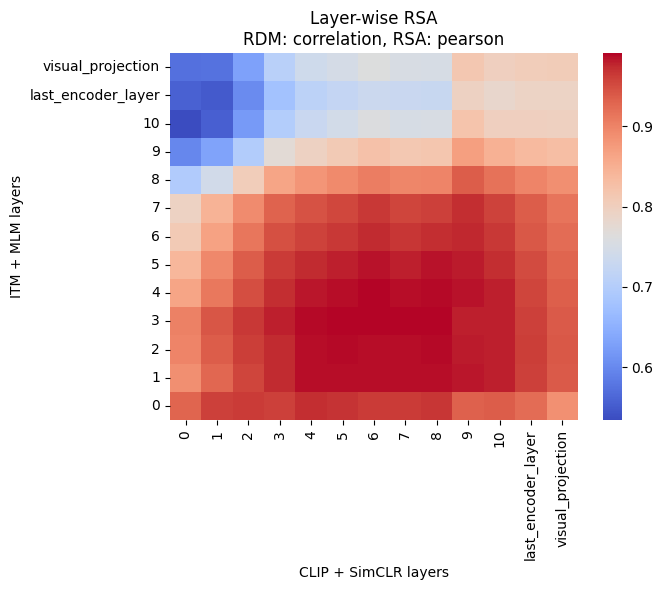

In [18]:
visual_reps_per_layer_1 = extract_all_layer_representations(visual_representations, "95ddsmmz")
visual_reps_per_layer_2 = extract_all_layer_representations(visual_representations, "mkqp8hhx")
plot_layerwise_rsa(
    reps1=visual_reps_per_layer_1, 
    reps2=visual_reps_per_layer_2, 
    xlabel="CLIP + SimCLR layers",
    ylabel="ITM + MLM layers",
    figsize=(7, 6),
    # cmap="viridis", 
    annot=False,
)

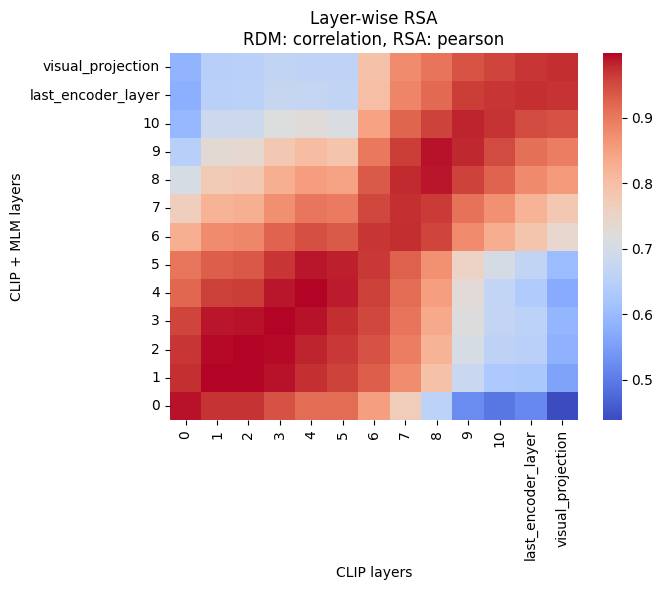

In [19]:
visual_reps_per_layer_1 = extract_all_layer_representations(visual_representations, "3burj4np")
visual_reps_per_layer_2 = extract_all_layer_representations(visual_representations, "shf56cne")
plot_layerwise_rsa(
    reps1=visual_reps_per_layer_1, 
    reps2=visual_reps_per_layer_2, 
    xlabel="CLIP layers",
    ylabel="CLIP + MLM layers",
    figsize=(7, 6),
    # cmap="viridis", 
    annot=False,
)

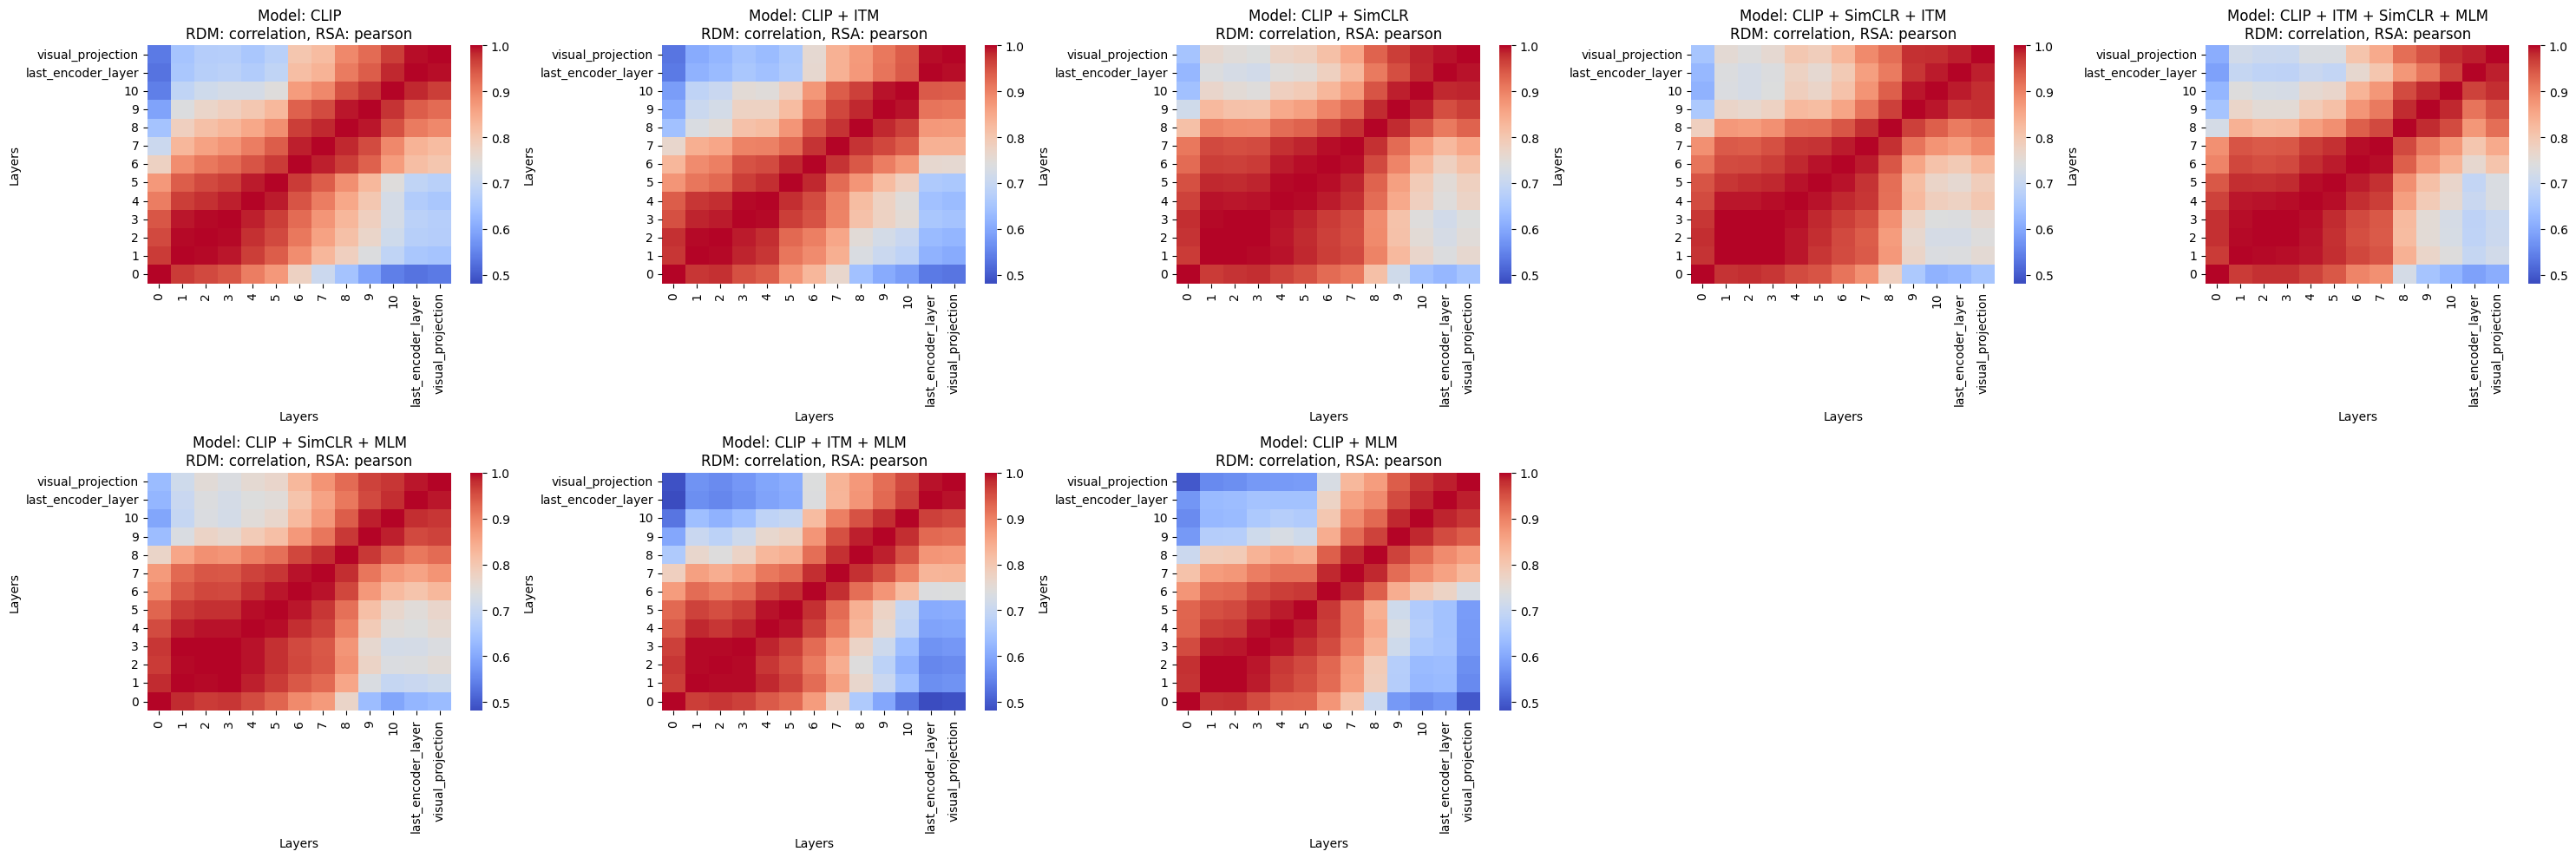

In [34]:
plot_layerwise_rsa_multiple_models(
    model_representations=visual_representations,
    model_ids=visual_representations.keys(),
    rdm_metric="correlation",
    rsa_metric="pearson",
    annot=False,
    ckpts_config_file=ckpts_config_file,
    global_vmin_vmax=True,  # Use global vmin/vmax for color scale
    clip_only=True,
)

### Text

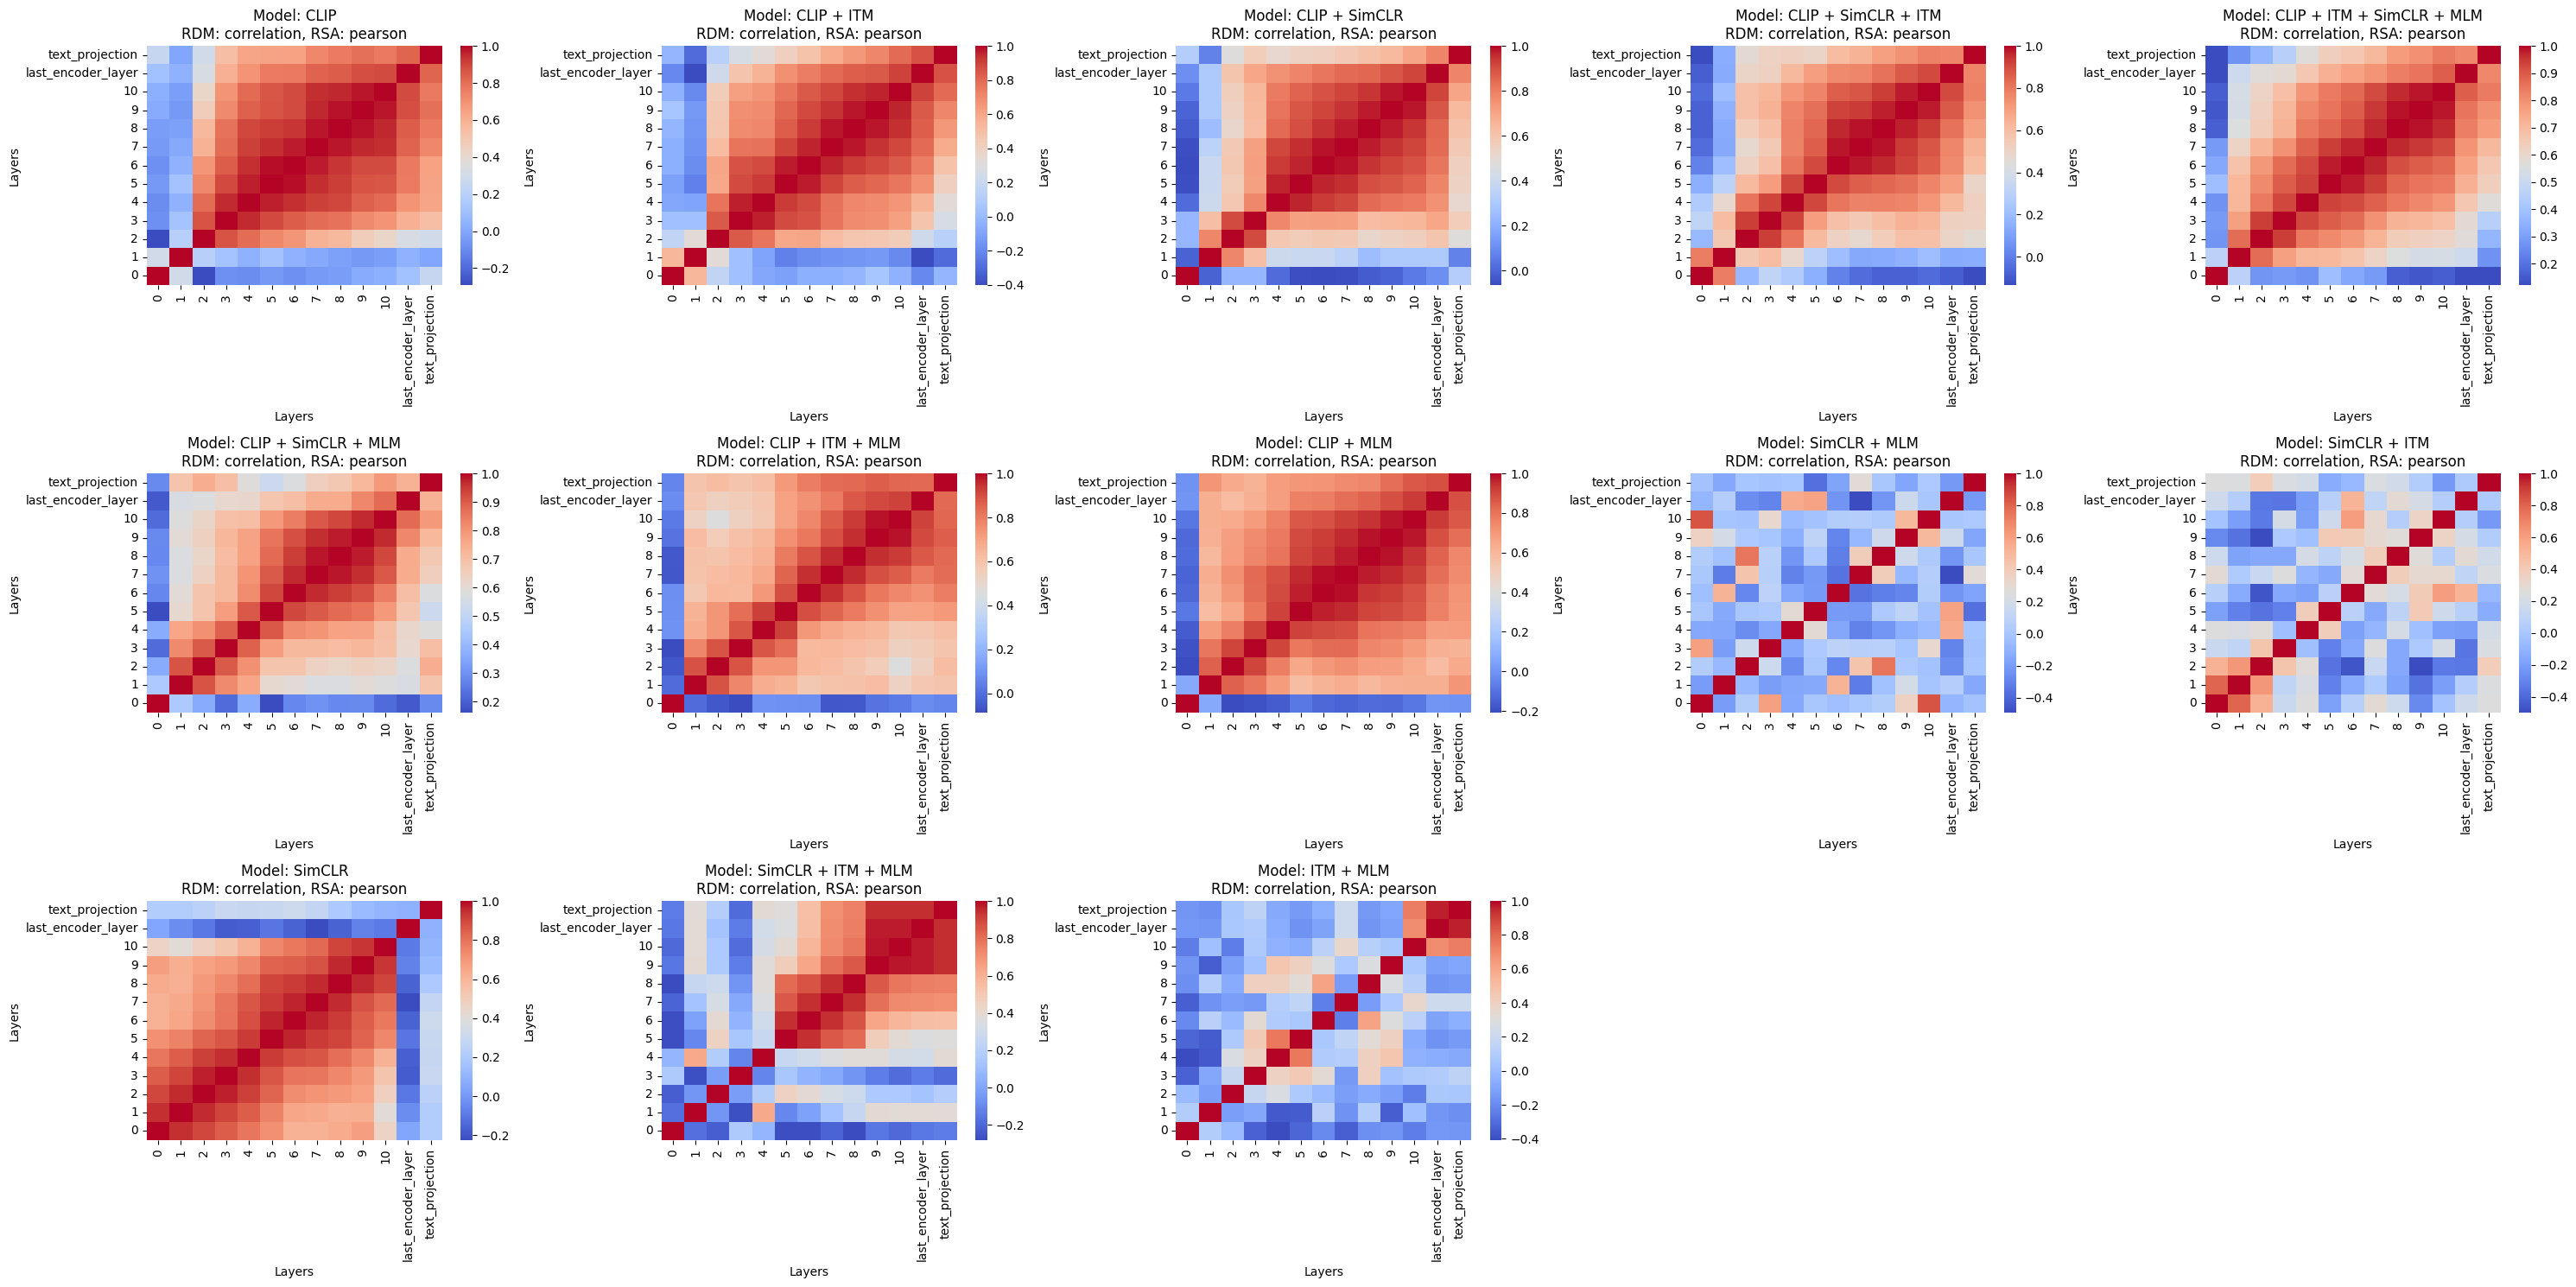

In [15]:
plot_layerwise_rsa_multiple_models(
    model_representations=text_representations,
    model_ids=text_representations.keys(),
    layers1=[i for i in range(11)]+["last_encoder_layer", "text_projection"],
    layers2=[i for i in range(11)]+["last_encoder_layer", "text_projection"],
    num_templates=1,
    rdm_metric="correlation",
    rsa_metric="pearson",
    annot=False,
    ckpts_config_file=ckpts_config_file,
)

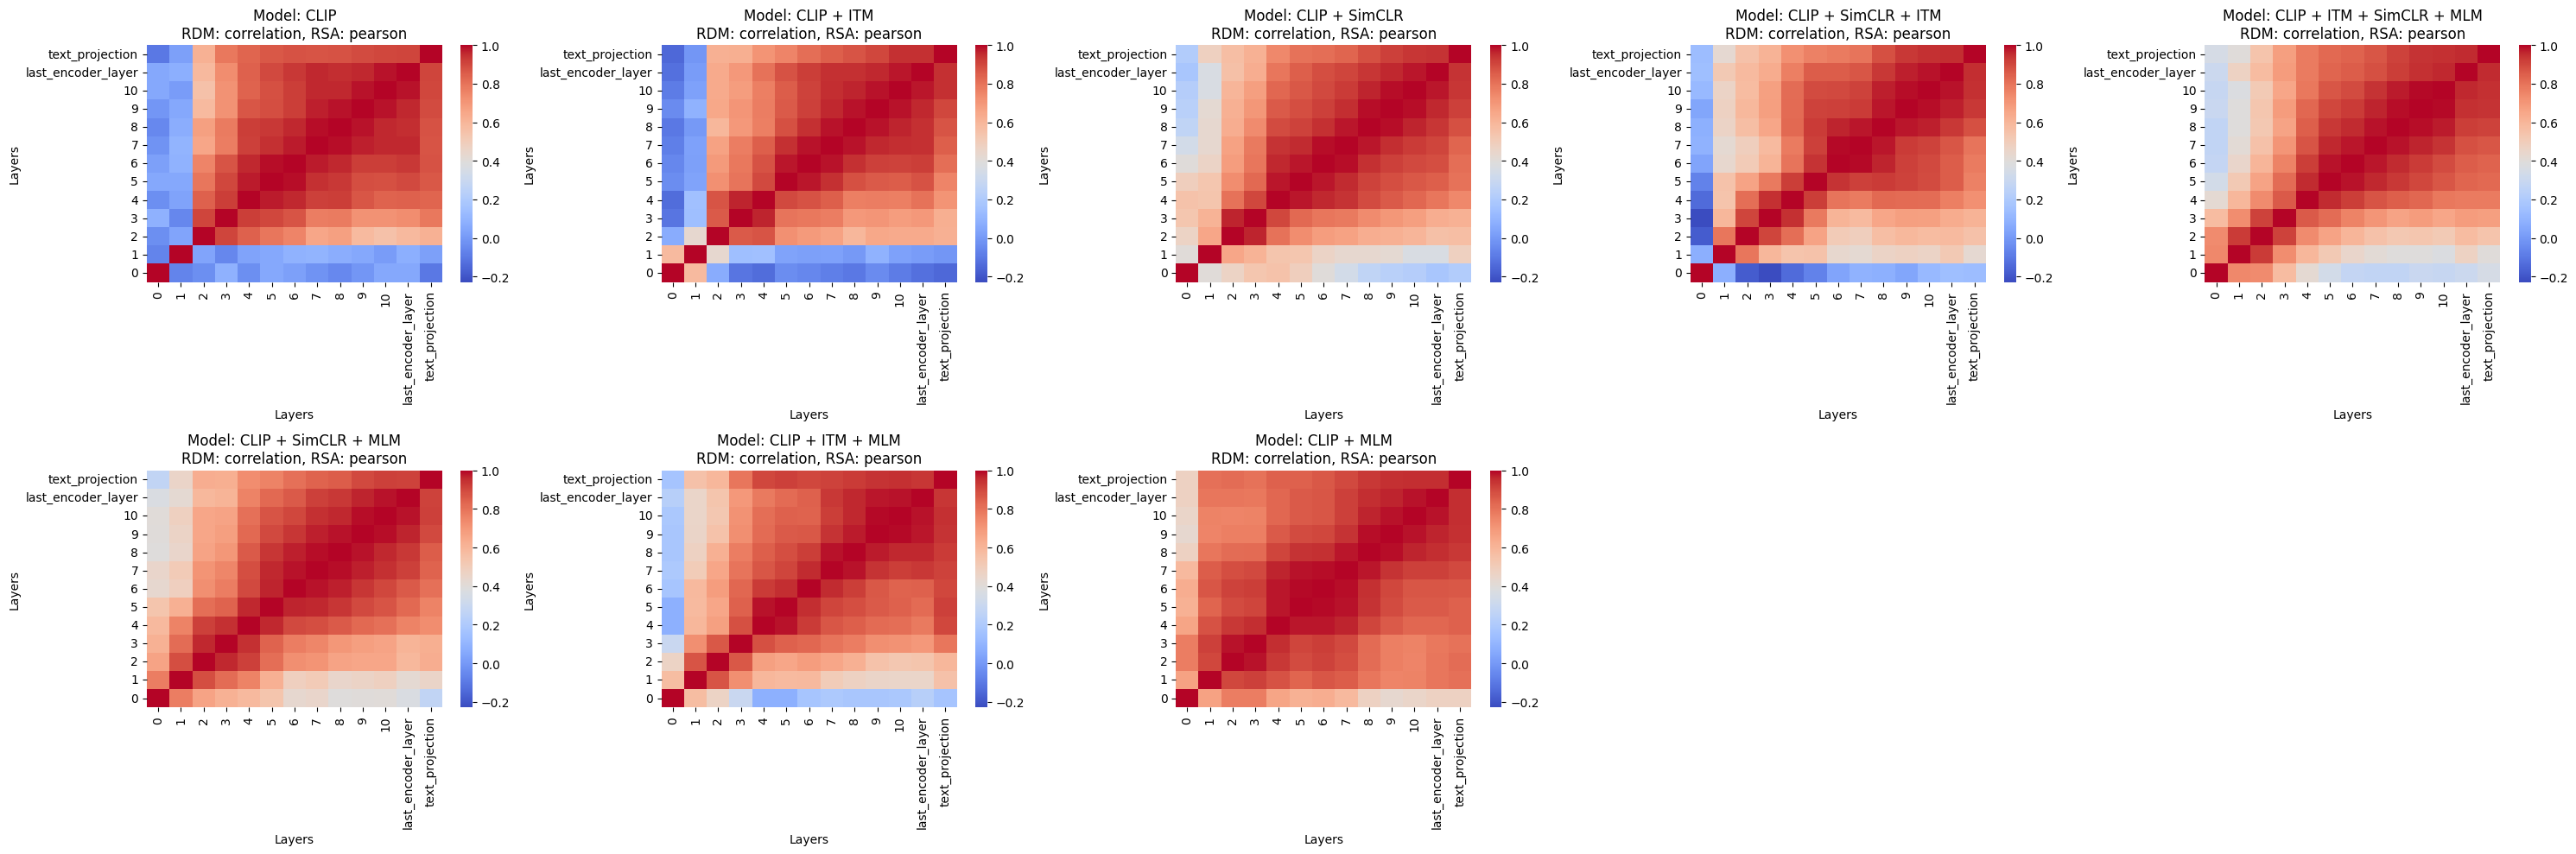

In [33]:
plot_layerwise_rsa_multiple_models(
    model_representations=text_representations,
    model_ids=text_representations.keys(),
    layers1=[i for i in range(11)]+["last_encoder_layer", "text_projection"],
    layers2=[i for i in range(11)]+["last_encoder_layer", "text_projection"],
    num_templates=9,
    rdm_metric="correlation",
    rsa_metric="pearson",
    annot=False,
    ckpts_config_file=ckpts_config_file,
    global_vmin_vmax=True,  # Use global vmin/vmax for color scale
    clip_only=True,
)

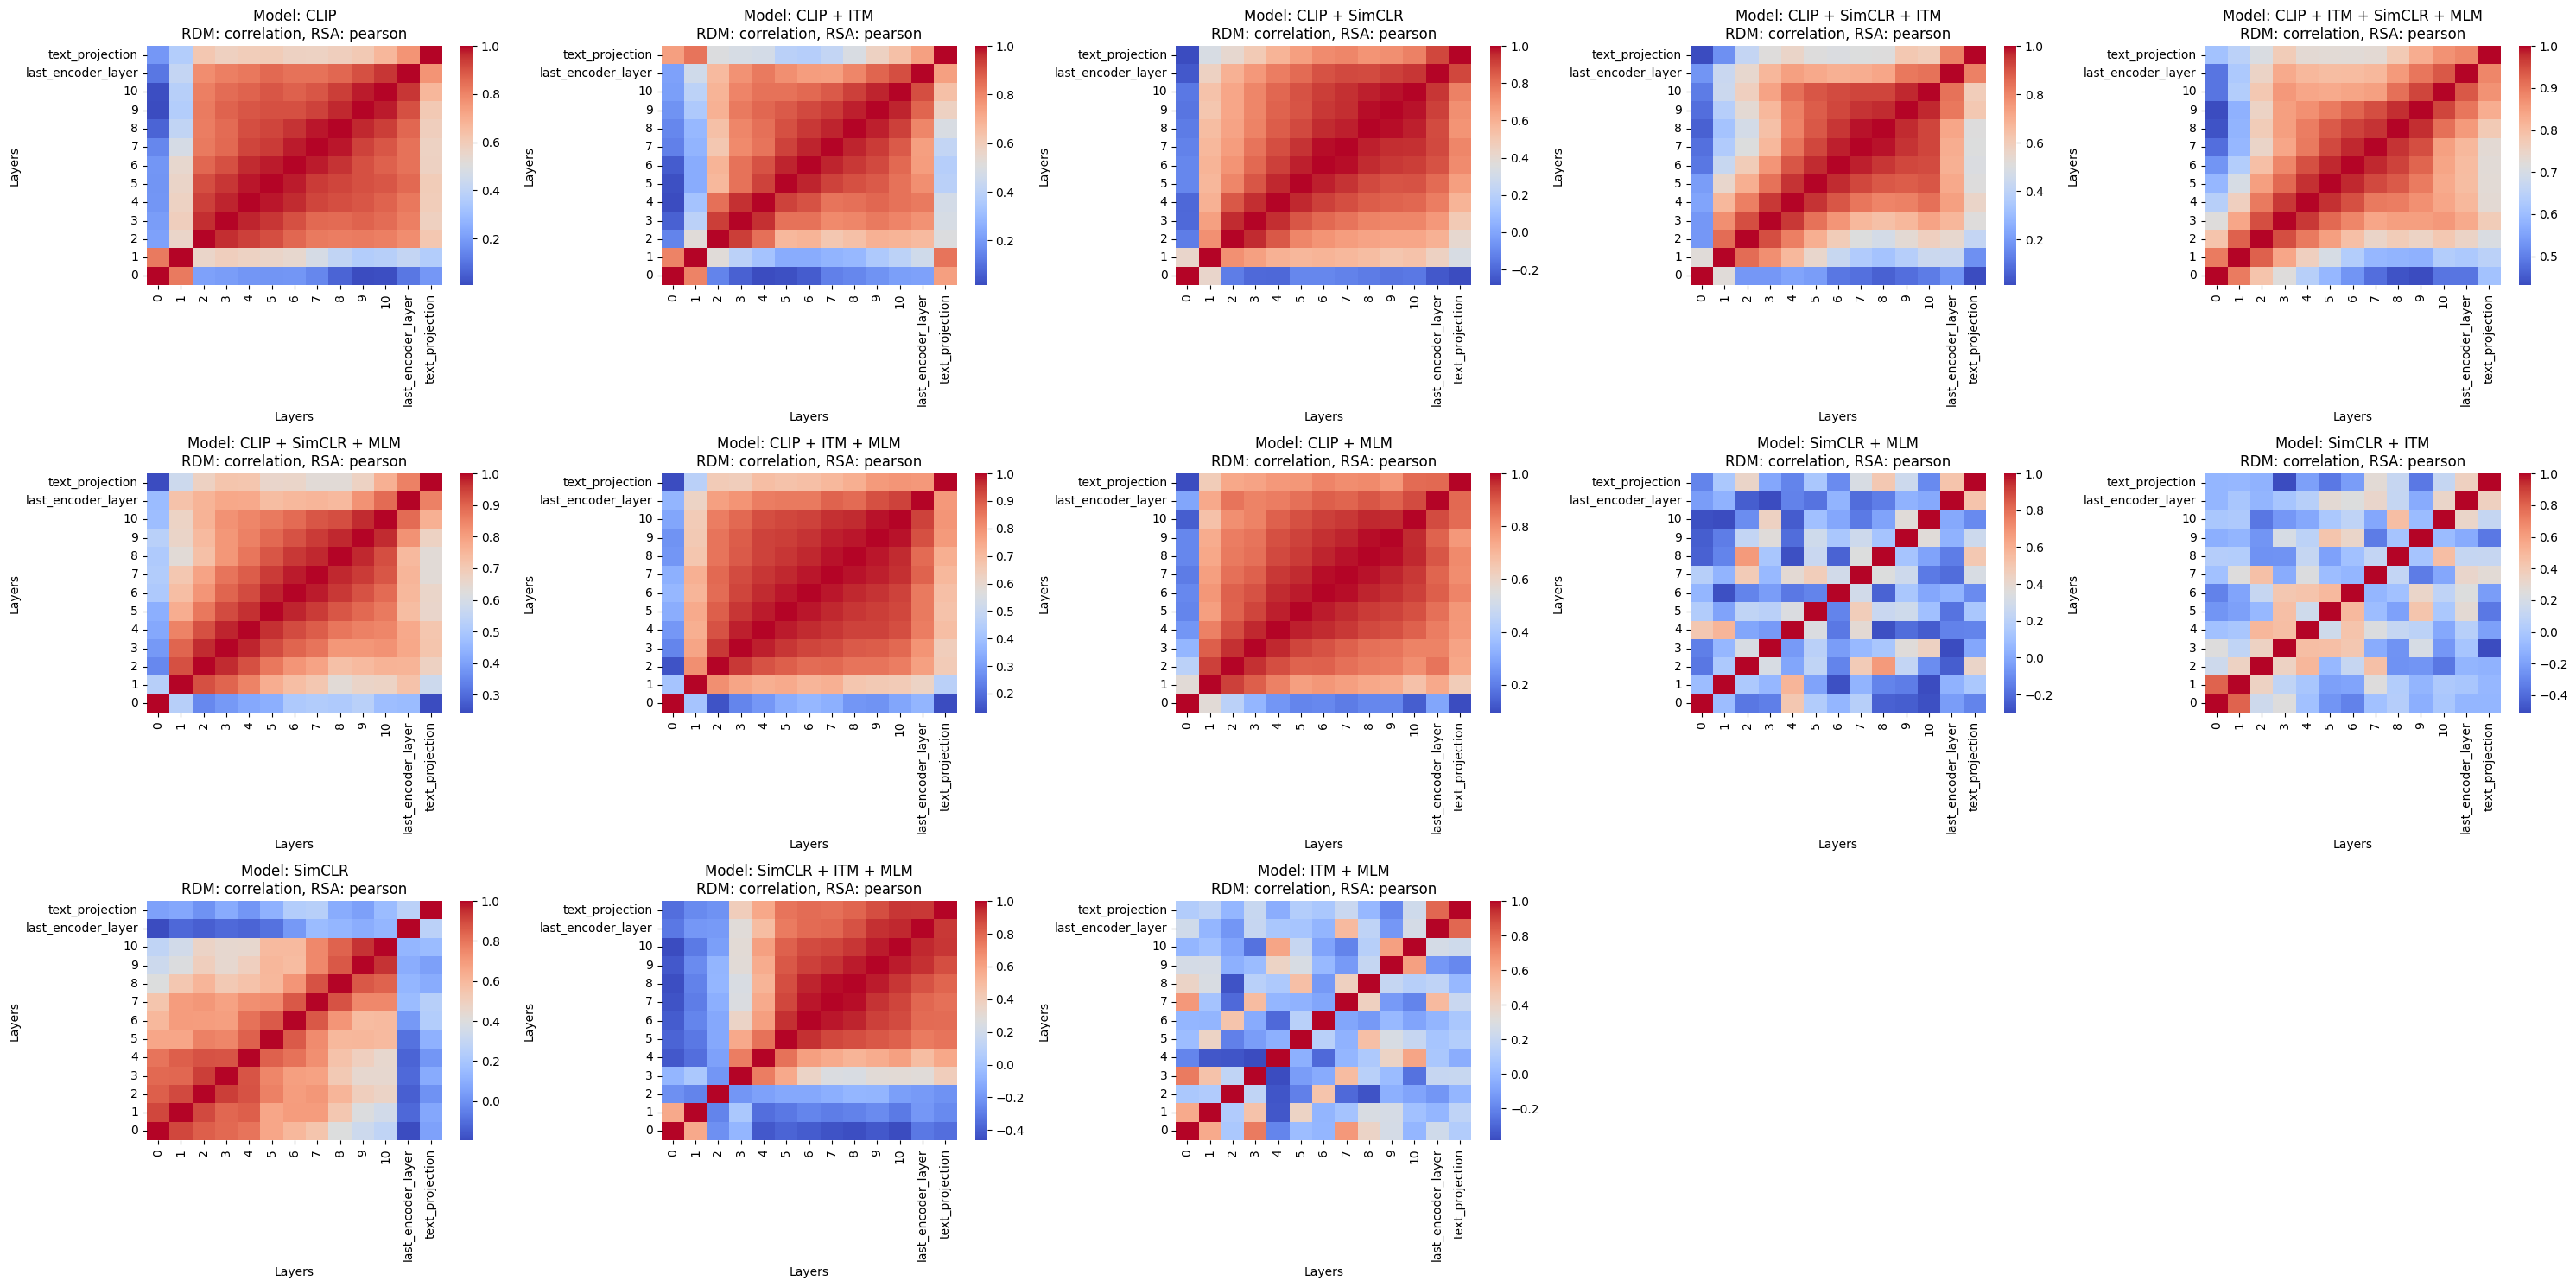

In [17]:
plot_layerwise_rsa_multiple_models(
    model_representations=text_representations,
    model_ids=text_representations.keys(),
    layers1=[i for i in range(11)]+["last_encoder_layer", "text_projection"],
    layers2=[i for i in range(11)]+["last_encoder_layer", "text_projection"],
    num_templates=0,
    rdm_metric="correlation",
    rsa_metric="pearson",
    annot=False,
    ckpts_config_file=ckpts_config_file,
)

## RSA between Layer-RSAs

In [30]:
visual_representations

{'3burj4np': {'dataset': 'CIFAR10',
  'model': '3burj4np',
  'class_names': ['airplane',
   'automobile',
   'bird',
   'cat',
   'deer',
   'dog',
   'frog',
   'horse',
   'ship',
   'truck'],
  'representations': [{'modality': 'vision',
    'layer': 'visual_projection',
    'data': array([[ 1.27337381e-01, -1.27487266e+00,  4.99394000e-01, ...,
            -1.13992676e-01,  1.30323038e-01, -2.26826727e-01],
           [-4.60895039e-02, -1.53717566e+00,  5.26895046e-01, ...,
             3.20023090e-01, -5.90227321e-02,  9.68287364e-02],
           [ 4.21205342e-01, -8.55829358e-01,  3.59362721e-01, ...,
             3.10472488e-01,  6.53530538e-01, -2.42409676e-01],
           ...,
           [ 3.00776422e-01, -9.94611323e-01,  3.15340906e-01, ...,
            -5.65047795e-03,  3.13719690e-01, -7.70199001e-01],
           [ 1.84451729e-01, -1.23705184e+00,  5.18404782e-01, ...,
            -3.13800216e-01,  2.16681466e-01, -2.31672600e-01],
           [-8.23916793e-02, -1.56125832e+

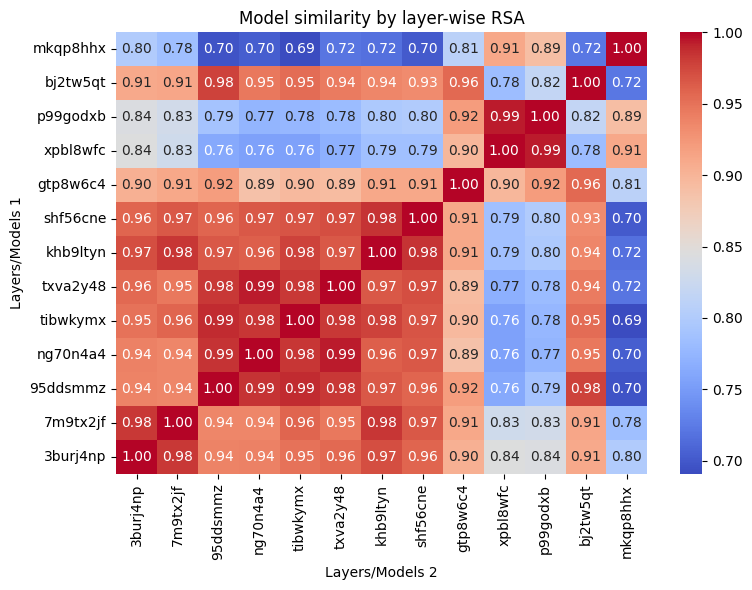

In [29]:
sim_matrix, model_names = compare_layerwise_rsa_across_models(
    model_representations=visual_representations,
    model_ids=list(visual_representations.keys()),
    layers=[i for i in range(11)] + ["last_encoder_layer", "visual_projection"],
)
plot_rsa_matrix(sim_matrix, model_names, model_names, title="Model similarity by layer-wise RSA")

## CKA

In [19]:
def load_cka_matrices_from_folder(folder_path, recursive=True, dataset_filter=None):
    """
    Enhanced version to load CKA matrices from pickle files in a folder.
    
    Args:
        folder_path (str): Path to the folder containing pickle files
        recursive (bool): Whether to search recursively in subfolders
        dataset_filter (str, optional): Only load files from this dataset (e.g., "CIFAR10")
        
    Returns:
        dict: Dictionary where keys are tuples of (model1_name, model2_name) 
              and values are dictionaries containing:
              - 'cka_matrix': the CKA matrix
              - 'dataset': the dataset name
              - 'file_path': path to the source file
    """
    cka_matrices = {}
    
    # Find all pickle files in the folder (recursively if specified)
    if recursive:
        pickle_files = glob.glob(os.path.join(folder_path, "**/*.pkl"), recursive=True)
    else:
        pickle_files = glob.glob(os.path.join(folder_path, "*.pkl"))
    
    for pickle_file in pickle_files:
        try:
            # Extract dataset name from filename if possible
            filename = os.path.basename(pickle_file)
            dataset_name = None
            
            # Parse filename format: CKA-DATASET-model1-model2.pkl
            if filename.startswith("CKA-") and filename.count("-") >= 3:
                parts = filename.replace(".pkl", "").split("-")
                dataset_name = parts[1]  # Second part after "CKA-"
                
                # Apply dataset filter if specified
                if dataset_filter and dataset_name != dataset_filter:
                    continue
            
            # Load the pickle file
            with open(pickle_file, "rb") as f:
                data = pickle.load(f)
            
            # Extract model names and CKA matrix
            model1_name = data.get('model1_name')
            model2_name = data.get('model2_name')
            cka_matrix = data.get('CKA')
            
            if model1_name and model2_name and cka_matrix is not None:
                # Use tuple of model names as key
                key = (model1_name, model2_name)
                cka_matrices[key] = {
                    'cka_matrix': cka_matrix,
                    'dataset': dataset_name or data.get('dataset1_name', 'unknown'),
                    'file_path': pickle_file,
                    'model1_layers': data.get('model1_layers', []),
                    'model2_layers': data.get('model2_layers', [])
                }
                print(f"Loaded CKA matrix for {model1_name} vs {model2_name} "
                      f"(dataset: {dataset_name}) from {os.path.basename(pickle_file)}")
            else:
                print(f"Warning: Missing required keys in {os.path.basename(pickle_file)}")
                
        except Exception as e:
            print(f"Error loading {os.path.basename(pickle_file)}: {e}")
    
    print(f"\nLoaded {len(cka_matrices)} CKA matrices total")
    return cka_matrices

In [20]:
cka_data_cifar10 = load_cka_matrices_from_folder(
    "/home/phisch/multimodal/data/CKA_layers/full_dataset_aug_mlm",
    dataset_filter="CIFAR10"
)

Loaded CKA matrix for SimCLR vs CLIP + ITM + SimCLR + MLM (dataset: CIFAR10) from CKA-CIFAR10-p99godxb-tibwkymx.pkl
Loaded CKA matrix for SimCLR + MLM vs SimCLR + MLM (dataset: CIFAR10) from CKA-CIFAR10-gtp8w6c4-gtp8w6c4.pkl
Loaded CKA matrix for SimCLR vs ITM + MLM (dataset: CIFAR10) from CKA-CIFAR10-p99godxb-mkqp8hhx.pkl
Loaded CKA matrix for SimCLR + ITM vs SimCLR + ITM (dataset: CIFAR10) from CKA-CIFAR10-xpbl8wfc-xpbl8wfc.pkl
Loaded CKA matrix for CLIP + SimCLR + MLM vs SimCLR + MLM (dataset: CIFAR10) from CKA-CIFAR10-txva2y48-gtp8w6c4.pkl
Loaded CKA matrix for ITM + MLM vs CLIP (dataset: CIFAR10) from CKA-CIFAR10-mkqp8hhx-3burj4np.pkl
Loaded CKA matrix for CLIP vs CLIP + ITM (dataset: CIFAR10) from CKA-CIFAR10-3burj4np-7m9tx2jf.pkl
Loaded CKA matrix for CLIP + MLM vs SimCLR + MLM (dataset: CIFAR10) from CKA-CIFAR10-shf56cne-gtp8w6c4.pkl
Loaded CKA matrix for CLIP + SimCLR vs CLIP + MLM (dataset: CIFAR10) from CKA-CIFAR10-95ddsmmz-shf56cne.pkl
Loaded CKA matrix for ITM + MLM vs CLI

In [21]:
def plot_cka_heatmap_for_layer(
    cka_matrices, 
    layer1_idx=None, 
    layer2_idx=None, 
    layer1_name=None, 
    layer2_name=None, 
    figsize=(10, 8), 
    cmap="magma", 
    annot=True, 
    fmt=".3f", 
    title_prefix="CKA", 
    ckpts_config_file=None,
    model_order=None,  # allow user to specify model order (list of model ids)
):
    """
    Plot a heatmap of CKA values between all models for specific layers.

    Args:
        cka_matrices (dict): Dictionary from load_cka_matrices_from_folder()
        layer1_idx (int, optional): Index of layer in model1 (if using indices)
        layer2_idx (int, optional): Index of layer in model2 (if using indices)
        layer1_name (str, optional): Name of layer in model1 (if using names)
        layer2_name (str, optional): Name of layer in model2 (if using names)
        figsize (tuple): Figure size
        cmap (str): Colormap for heatmap
        annot (bool): Whether to show values in cells
        fmt (str): Format string for annotations
        title_prefix (str): Prefix for the plot title
        ckpts_config_file (str, optional): Path to checkpoint config for model names
        model_order (list, optional): List of model ids to specify order in the heatmap

    Returns:
        np.ndarray: The CKA matrix plotted
        list: List of model names in order
    """
    import glob

    # Load checkpoint mapping if provided
    ckpt_mapping = {}
    if ckpts_config_file is not None:
        with open(ckpts_config_file, "r") as f:
            ckpt_mapping = yaml.safe_load(f)

    # Build mapping from model_id to model_name
    id_to_name = {}
    if ckpt_mapping:
        for mid, v in ckpt_mapping.items():
            id_to_name[mid] = v.get("name", mid)

    # Collect all unique model names from cka_matrices
    all_model_names = set()
    for (model1, model2) in cka_matrices.keys():
        all_model_names.add(model1)
        all_model_names.add(model2)

    # If model_order is provided (list of ids), map to model names
    if model_order is not None:
        mapped_model_names = []
        display_names = []
        for mid in model_order:
            mname = id_to_name.get(mid, mid)
            if mname in all_model_names:
                mapped_model_names.append(mname)
                display_names.append(mname)
            else:
                # Optionally, warn if not found
                pass
        all_model_names = mapped_model_names
    else:
        all_model_names = sorted(list(all_model_names))
        display_names = list(all_model_names)

    n_models = len(all_model_names)
    cka_matrix = np.full((n_models, n_models), np.nan)

    # Fill the matrix
    for (model1, model2), data in cka_matrices.items():
        cka_data = data['cka_matrix']
        model1_layers = data['model1_layers']
        model2_layers = data['model2_layers']

        # Determine which CKA value to extract
        if layer1_idx is not None and layer2_idx is not None:
            if (layer1_idx < len(model1_layers) and layer2_idx < len(model2_layers) and
                layer1_idx < cka_data.shape[0] and layer2_idx < cka_data.shape[1]):
                cka_value = cka_data[layer1_idx, layer2_idx]
            else:
                continue
        elif layer1_name is not None and layer2_name is not None:
            try:
                layer1_idx_found = model1_layers.index(layer1_name)
                layer2_idx_found = model2_layers.index(layer2_name)
                cka_value = cka_data[layer1_idx_found, layer2_idx_found]
            except (ValueError, IndexError):
                continue
        else:
            raise ValueError("Must specify either layer indices or layer names")

        # Find positions in the matrix
        if model1 in all_model_names and model2 in all_model_names:
            model1_idx = all_model_names.index(model1)
            model2_idx = all_model_names.index(model2)
            # Fill both symmetric positions
            cka_matrix[model1_idx, model2_idx] = cka_value
            cka_matrix[model2_idx, model1_idx] = cka_value

    # Create the plot
    plt.figure(figsize=figsize)
    mask = np.isnan(cka_matrix)
    sns.heatmap(
        cka_matrix,
        annot=annot,
        fmt=fmt,
        cmap=cmap,
        xticklabels=display_names,
        yticklabels=display_names,
        mask=mask,
        cbar_kws={'label': 'CKA Similarity'},
        square=True
    )

    # Create title
    if layer1_name and layer2_name:
        layer_info = f"Layer: {layer1_name} vs {layer2_name}"
    elif layer1_idx is not None and layer2_idx is not None:
        layer_info = f"Layer: {layer1_idx} vs {layer2_idx}"
    else:
        layer_info = "Specific Layer"

    plt.title(f"{title_prefix} Similarity Matrix\n{layer_info}")
    plt.xlabel("Models")
    plt.ylabel("Models")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return cka_matrix, display_names

def plot_cka_heatmap_multiple_layers(cka_matrices, layer_pairs=None, layer_indices=None,
                                   figsize_per_plot=(6, 5), n_cols=3, cmap="coolwarm", 
                                   annot=False, ckpts_config_file=None):
    """
    Plot multiple CKA heatmaps for different layer combinations.
    
    Args:
        cka_matrices (dict): Dictionary from load_cka_matrices_from_folder()
        layer_pairs (list): List of tuples (layer1_name, layer2_name)
        layer_indices (list): List of tuples (layer1_idx, layer2_idx)
        figsize_per_plot (tuple): Size of each subplot
        n_cols (int): Number of columns in subplot grid
        cmap (str): Colormap for heatmaps
        annot (bool): Whether to show values in cells
        ckpts_config_file (str, optional): Path to checkpoint config for model names
    """
    if layer_pairs is None and layer_indices is None:
        raise ValueError("Must specify either layer_pairs or layer_indices")
    
    pairs_to_plot = layer_pairs if layer_pairs else layer_indices
    n_plots = len(pairs_to_plot)
    n_cols = min(n_cols, n_plots)
    n_rows = (n_plots + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, 
                            figsize=(figsize_per_plot[0]*n_cols, figsize_per_plot[1]*n_rows))
    axes = np.array(axes).reshape(-1)
    
    for idx, pair in enumerate(pairs_to_plot):
        ax = axes[idx]
        plt.sca(ax)  # Set current axis
        
        if layer_pairs:
            layer1_name, layer2_name = pair
            cka_matrix, model_names = plot_cka_heatmap_for_layer(
                cka_matrices, 
                layer1_name=layer1_name, 
                layer2_name=layer2_name,
                figsize=(1, 1),  # Will be ignored due to subplot
                cmap=cmap,
                annot=annot,
                title_prefix="",
                ckpts_config_file=ckpts_config_file
            )
            ax.set_title(f"{layer1_name} vs {layer2_name}")
        else:
            layer1_idx, layer2_idx = pair
            cka_matrix, model_names = plot_cka_heatmap_for_layer(
                cka_matrices,
                layer1_idx=layer1_idx,
                layer2_idx=layer2_idx,
                figsize=(1, 1),  # Will be ignored due to subplot
                cmap=cmap,
                annot=annot,
                title_prefix="",
                ckpts_config_file=ckpts_config_file
            )
            ax.set_title(f"Layer {layer1_idx} vs {layer2_idx}")
    
    # Hide unused subplots
    for i in range(n_plots, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

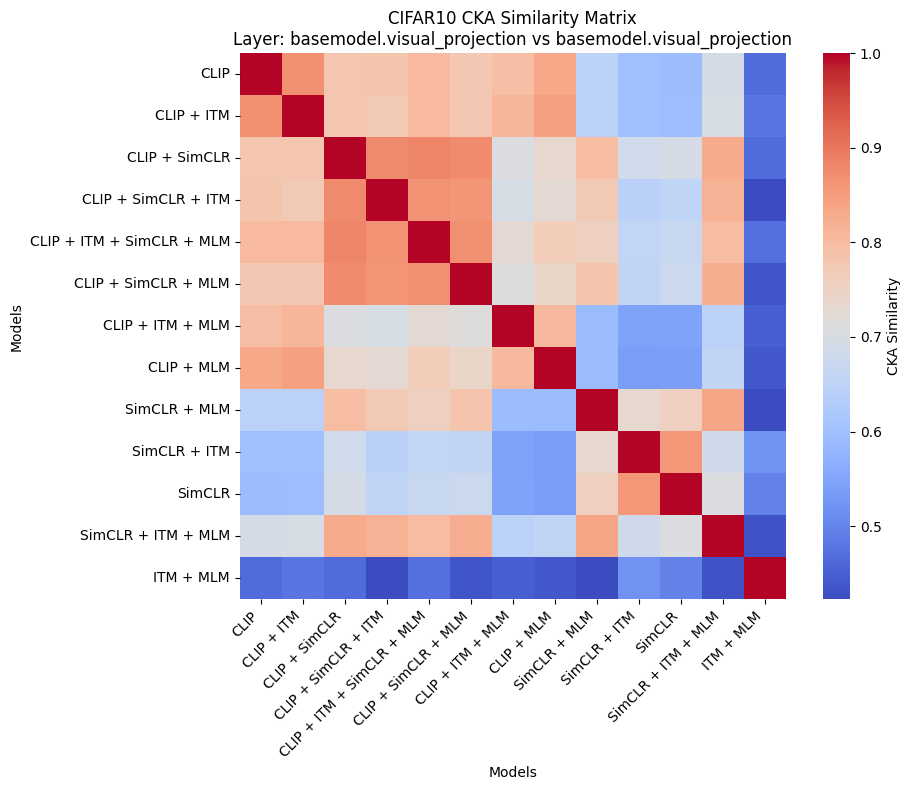

(array([[0.99999994, 0.86797428, 0.78034478, 0.78172547, 0.80167842,
         0.77889413, 0.79686093, 0.83390492, 0.64547116, 0.59805417,
         0.59106863, 0.69320232, 0.46441263],
        [0.86797428, 1.        , 0.77916533, 0.77341366, 0.80331397,
         0.77903008, 0.81164378, 0.8446157 , 0.6452989 , 0.5988518 ,
         0.59232408, 0.69651943, 0.47823921],
        [0.78034478, 0.77916533, 0.99999994, 0.87819493, 0.88497293,
         0.87438661, 0.70673597, 0.73498821, 0.79724413, 0.68273401,
         0.69448888, 0.8304351 , 0.46364734],
        [0.78172547, 0.77341366, 0.87819493, 1.00000012, 0.86674076,
         0.8611297 , 0.69773847, 0.72827834, 0.77312052, 0.64166045,
         0.65456402, 0.81796604, 0.42451942],
        [0.80167842, 0.80331397, 0.88497293, 0.86674076, 0.99999994,
         0.87006241, 0.72818416, 0.76537532, 0.75627095, 0.65773547,
         0.66729039, 0.80052161, 0.47071135],
        [0.77889413, 0.77903008, 0.87438661, 0.8611297 , 0.87006241,
         0.

In [24]:
# Plot CKA for specific layer names (e.g., projection layers)
plot_cka_heatmap_for_layer(
    cka_data_cifar10,
    layer1_name="basemodel.visual_projection", #"basemodel.vision_model.encoder.layer.11", #
    layer2_name="basemodel.visual_projection", #"basemodel.vision_model.encoder.layer.11", #
    ckpts_config_file=ckpts_config_file,
    title_prefix="CIFAR10 CKA",
    annot=False,
    model_order=model_order,
    cmap="coolwarm"
)

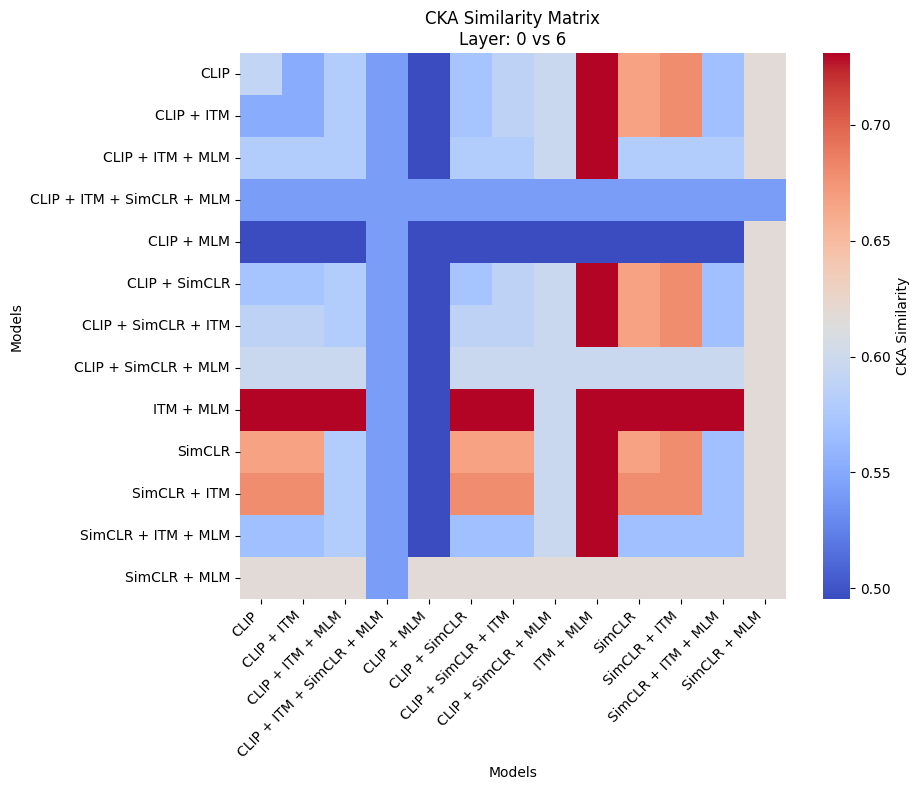

(array([[0.59117508, 0.55164897, 0.57918656, 0.54167622, 0.49537259,
         0.57111216, 0.58743715, 0.5968349 , 0.73096132, 0.66658896,
         0.67925578, 0.56728917, 0.61772805],
        [0.55164897, 0.55164897, 0.57918656, 0.54167622, 0.49537259,
         0.57111216, 0.58743715, 0.5968349 , 0.73096132, 0.66658896,
         0.67925578, 0.56728917, 0.61772805],
        [0.57918656, 0.57918656, 0.57918656, 0.54167622, 0.49537259,
         0.57918656, 0.57918656, 0.5968349 , 0.73096132, 0.57918656,
         0.57918656, 0.57918656, 0.61772805],
        [0.54167622, 0.54167622, 0.54167622, 0.54167622, 0.54167622,
         0.54167622, 0.54167622, 0.54167622, 0.54167622, 0.54167622,
         0.54167622, 0.54167622, 0.54167622],
        [0.49537259, 0.49537259, 0.49537259, 0.54167622, 0.49537259,
         0.49537259, 0.49537259, 0.49537259, 0.49537259, 0.49537259,
         0.49537259, 0.49537259, 0.61772805],
        [0.57111216, 0.57111216, 0.57918656, 0.54167622, 0.49537259,
         0.

In [34]:
# Plot CKA for specific layer indices
plot_cka_heatmap_for_layer(
    cka_data_cifar10,
    layer1_idx=0,  # Last layer of model1
    layer2_idx=6,  # Last layer of model2
    ckpts_config_file=ckpts_config_file,
    annot=False,
)

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def plot_cka_heatmap(cka_data, title="CKA Heatmap"):
    # Extract unique model names
    model_names = set()
    for k in cka_data.keys():
        if isinstance(k, tuple):
            model_names.update(k)
        else:
            # If keys are strings like "modelA-modelB"
            model_names.update(k.split('-'))
    model_names = sorted(model_names)
    name_to_idx = {name: i for i, name in enumerate(model_names)}
    n = len(model_names)
    # Initialize matrix
    cka_matrix = np.zeros((n, n))
    # Fill matrix
    for k, v in cka_data.items():
        if isinstance(k, tuple):
            i, j = name_to_idx[k[0]], name_to_idx[k[1]]
        else:
            i, j = [name_to_idx[x] for x in k.split('-')]
        cka_matrix[i, j] = v
        cka_matrix[j, i] = v  # Assume symmetry
    # Plot
    plt.figure(figsize=(8, 6))
    im = plt.imshow(cka_matrix, cmap='viridis', vmin=0, vmax=1)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(n), model_names, rotation=45, ha='right')
    plt.yticks(range(n), model_names)
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [25]:
plot_cka_heatmap(cka_data_cifar10, title="CKA between CIFAR-10 Models")

TypeError: float() argument must be a string or a number, not 'dict'

In [30]:
# Plot comprehensive CKA heatmap showing all model-to-model layer comparisons
comprehensive_matrix, model_order, layer_names = plot_comprehensive_cka_heatmap(
    cka_data_cifar10, 
    ckpts_config_file=ckpts_config_file,
    figsize=(20, 18),
    title="Comprehensive CKA Matrix: All Models and Layers (CIFAR-10)"
)

AttributeError: 'tuple' object has no attribute 'split'

In [39]:
def plot_simple_comprehensive_cka_heatmap(
    cka_data, 
    ckpts_config_file, 
    figsize=(16, 14), 
    cmap="RdYlBu_r", 
    clip_only=None,
    exclude_pooling_layer=False,
    model_order=None,  # allow user to specify model order (list of model ids)
):
    """
    Simpler version that handles CKA data where each entry is already a full matrix.
    Rotates each CKA matrix so that (0,0) is at the lower left.
    Optionally only plots models with 'CLIP' in their name.
    Optionally excludes the second to last row & column (e.g., pooling layer) from each CKA matrix.
    Optionally specify model order (as model ids, mapped to names via ckpt config).
    """
    import yaml
    with open(ckpts_config_file, 'r') as file:
        ckpts_config = yaml.safe_load(file)

    # Build mapping from model_id to model_name
    id_to_name = {}
    if ckpts_config:
        for mid, v in ckpts_config.items():
            id_to_name[mid] = v.get("name", mid)

    # Gather all model names present in the CKA data
    all_model_names = set()
    for key in cka_data.keys():
        model1, model2 = key
        all_model_names.add(model1)
        all_model_names.add(model2)

    # Filter for CLIP models if requested
    if clip_only is not None:
        if clip_only:
            all_model_names = {m for m in all_model_names if "clip" in m.lower()}
        else:
            all_model_names = {m for m in all_model_names if not "clip" in m.lower()}

    # If model_order is provided (list of ids), map to model names
    if model_order is not None:
        mapped_model_names = []
        for mid in model_order:
            mname = id_to_name.get(mid, mid)
            if mname in all_model_names:
                mapped_model_names.append(mname)
        model_order_names = mapped_model_names
    else:
        model_order_names = sorted(all_model_names)

    n_models = len(model_order_names)
    if n_models == 0:
        print("No models with the specified criteria found.")
        return None

    sample_key = list(cka_data.keys())[0]
    sample_matrix = cka_data[sample_key]["cka_matrix"]
    if exclude_pooling_layer:
        idxs = [i for i in range(sample_matrix.shape[0]) if i != sample_matrix.shape[0] - 2]
        n_layers = sample_matrix.shape[0] - 1
    else:
        idxs = None
        n_layers = sample_matrix.shape[0]

    total_size = n_models * n_layers
    comprehensive_matrix = np.zeros((total_size, total_size))

    for i, model1 in enumerate(model_order_names):
        for j, model2 in enumerate(model_order_names):
            key1 = (model1, model2)
            key2 = (model2, model1)

            if key1 in cka_data:
                cka_matrix = cka_data[key1]["cka_matrix"]
            elif key2 in cka_data:
                cka_matrix = cka_data[key2]["cka_matrix"].T
            else:
                cka_matrix = np.eye(sample_matrix.shape[0]) if i == j else np.zeros((sample_matrix.shape[0], sample_matrix.shape[0]))

            # Exclude pooling layer if requested
            if exclude_pooling_layer:
                # cka_matrix = cka_matrix.copy()
                cka_matrix = np.delete(cka_matrix, sample_matrix.shape[0] - 2, axis=0)
                cka_matrix = np.delete(cka_matrix, sample_matrix.shape[0] - 2, axis=1)

            # Flip vertically to move (0,0) to lower left
            cka_matrix = np.flipud(cka_matrix)

            start_i, end_i = i * n_layers, (i + 1) * n_layers
            start_j, end_j = j * n_layers, (j + 1) * n_layers
            comprehensive_matrix[start_i:end_i, start_j:end_j] = cka_matrix

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(comprehensive_matrix, cmap=cmap, vmin=0, vmax=1)
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('CKA Similarity', rotation=270, labelpad=15)
    for i in range(1, n_models):
        pos = i * n_layers - 0.5
        ax.axhline(y=pos, color='black', linewidth=2)
        ax.axvline(x=pos, color='black', linewidth=2)
    model_positions = [i * n_layers + n_layers // 2 for i in range(n_models)]
    model_names = [ckpts_config.get(mid, {}).get('name', mid) for mid in model_order if id_to_name.get(mid, mid) in model_order_names] if model_order is not None else [ckpts_config.get(m, {}).get('name', m) for m in model_order_names]
    ax.set_xticks(model_positions)
    ax.set_xticklabels(model_names, rotation=45, ha='right')
    ax.set_yticks(model_positions)
    ax.set_yticklabels(model_names)
    layer_positions = list(range(0, total_size, n_layers // 4)) if n_layers > 4 else list(range(total_size))
    ax.set_xticks(layer_positions, minor=True)
    ax.set_yticks(layer_positions, minor=True)
    ax.grid(True, which='minor', alpha=0.3)
    ax.set_title(f"Comprehensive CKA Matrix ({n_models} models, {n_layers} layers each)", fontsize=14)
    ax.set_xlabel('Models and Layers', fontsize=12)
    ax.set_ylabel('Models and Layers', fontsize=12)
    plt.tight_layout()

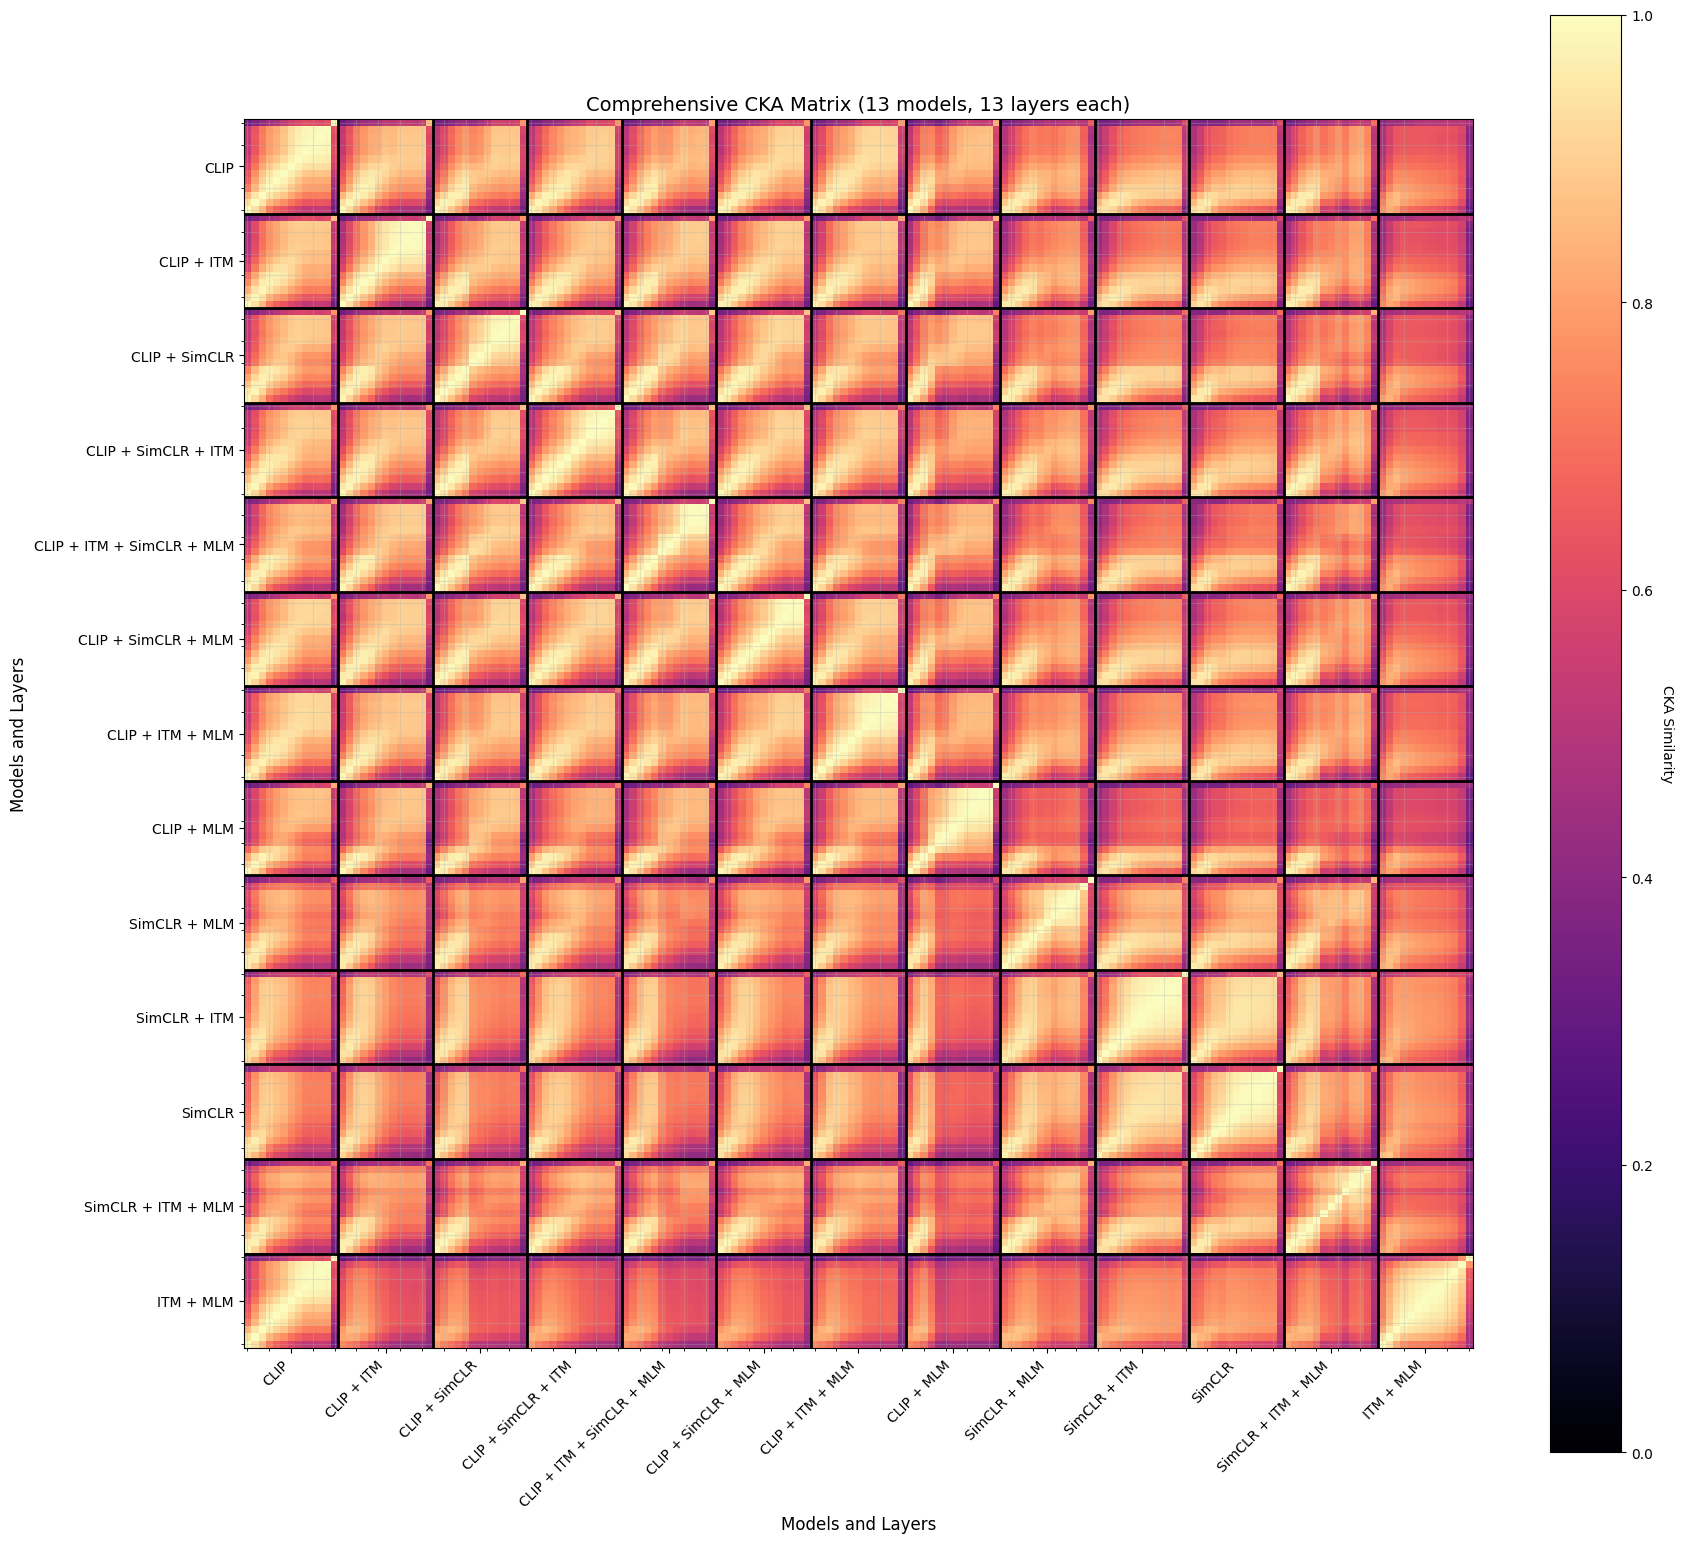

In [40]:
# Test the simpler version (use this if the first function doesn't work with your data structure)
comprehensive_matrix_simple = plot_simple_comprehensive_cka_heatmap(
    cka_data_cifar10, 
    ckpts_config_file=ckpts_config_file,
    figsize=(18, 16),
    cmap="magma",
    # clip_only=True,
    exclude_pooling_layer=True,
    model_order=model_order,
)

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
import seaborn as sns

def plot_comprehensive_cka_heatmap(cka_data, ckpts_config_file, figsize=(16, 14), 
                                 cmap='RdYlBu_r', annot=False, fmt='.2f',
                                 title="Comprehensive CKA Matrix"):
    """
    Plot all CKA matrices between all models in a single comprehensive heatmap.
    
    Parameters:
    - cka_data: Dictionary with model pair keys and CKA matrices as values
    - ckpts_config_file: Path to checkpoint config file for model names
    - figsize: Figure size tuple
    - cmap: Colormap for the heatmap
    - annot: Whether to annotate cells with values
    - fmt: Format for annotations
    - title: Title for the plot
    """
    
    # Load model configuration to get proper model names
    import yaml
    with open(ckpts_config_file, 'r') as file:
        ckpts_config = yaml.safe_load(file)
    
    # Get all unique model names from the data
    all_models = set()
    for key in cka_data.keys():
        model1, model2 = key.split('_vs_')
        all_models.add(model1)
        all_models.add(model2)
    
    # Sort models for consistent ordering
    model_order = sorted(all_models)
    
    # Get layer information from one of the CKA matrices
    sample_key = list(cka_data.keys())[0]
    sample_matrix = cka_data[sample_key]
    
    # Determine the structure - assuming square matrices for layer comparisons
    if isinstance(sample_matrix, dict):
        # If the matrix is a dictionary of layer pairs
        layer_names = sorted(set([layer for layers in sample_matrix.keys() for layer in layers]))
        n_layers = len(layer_names)
    else:
        # If the matrix is a numpy array
        n_layers = sample_matrix.shape[0]
        layer_names = [f"Layer_{i}" for i in range(n_layers)]
    
    n_models = len(model_order)
    total_size = n_models * n_layers
    
    # Initialize the comprehensive matrix
    comprehensive_matrix = np.zeros((total_size, total_size))
    
    # Fill the comprehensive matrix
    for i, model1 in enumerate(model_order):
        for j, model2 in enumerate(model_order):
            # Get the CKA matrix for this model pair
            key1 = f"{model1}_vs_{model2}"
            key2 = f"{model2}_vs_{model1}"
            
            if key1 in cka_data:
                cka_matrix = cka_data[key1]
            elif key2 in cka_data:
                cka_matrix = cka_data[key2]
                if isinstance(cka_matrix, np.ndarray):
                    cka_matrix = cka_matrix.T  # Transpose if needed
            else:
                # If no data available, fill with zeros or NaN
                cka_matrix = np.zeros((n_layers, n_layers))
            
            # Handle different matrix formats
            if isinstance(cka_matrix, dict):
                # Convert dictionary format to matrix
                matrix_vals = np.zeros((n_layers, n_layers))
                for (layer1, layer2), val in cka_matrix.items():
                    idx1 = layer_names.index(layer1)
                    idx2 = layer_names.index(layer2)
                    matrix_vals[idx1, idx2] = val
                cka_matrix = matrix_vals
            
            # Place the matrix in the comprehensive matrix
            start_i = i * n_layers
            end_i = (i + 1) * n_layers
            start_j = j * n_layers
            end_j = (j + 1) * n_layers
            
            comprehensive_matrix[start_i:end_i, start_j:end_j] = cka_matrix
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot the heatmap
    im = ax.imshow(comprehensive_matrix, cmap=cmap, aspect='equal', vmin=0, vmax=1)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('CKA Similarity', rotation=270, labelpad=20)
    
    # Add model boundaries
    for i in range(1, n_models):
        pos = i * n_layers - 0.5
        ax.axhline(y=pos, color='black', linewidth=2)
        ax.axvline(x=pos, color='black', linewidth=2)
    
    # Create tick labels
    model_ticks = []
    model_labels = []
    layer_ticks = []
    layer_labels = []
    
    for i, model in enumerate(model_order):
        # Get clean model name
        model_name = ckpts_config.get(model, {}).get('name', model)
        model_center = i * n_layers + n_layers / 2 - 0.5
        model_ticks.append(model_center)
        model_labels.append(model_name)
        
        # Add layer ticks for this model
        for j, layer in enumerate(layer_names):
            layer_pos = i * n_layers + j
            layer_ticks.append(layer_pos)
            layer_labels.append(f"{model_name[:8]}_{layer[-3:]}")  # Abbreviated labels
    
    # Set ticks and labels
    ax.set_xticks(model_ticks)
    ax.set_xticklabels(model_labels, rotation=45, ha='right')
    ax.set_yticks(model_ticks)
    ax.set_yticklabels(model_labels)
    
    # Add secondary ticks for layers (smaller)
    ax2 = ax.secondary_xaxis('top')
    ax2.set_xticks(layer_ticks)
    ax2.set_xticklabels(layer_labels, rotation=90, fontsize=8)
    
    ax3 = ax.secondary_yaxis('right')
    ax3.set_yticks(layer_ticks)
    ax3.set_yticklabels(layer_labels, fontsize=8)
    
    # Add annotations if requested
    if annot:
        for i in range(total_size):
            for j in range(total_size):
                value = comprehensive_matrix[i, j]
                if value > 0:  # Only annotate non-zero values
                    ax.text(j, i, format(value, fmt), ha='center', va='center',
                           fontsize=6, color='white' if value < 0.5 else 'black')
    
    # Set title and labels
    ax.set_title(title, fontsize=16, pad=20)
    ax.set_xlabel('Models (Layers)', fontsize=12)
    ax.set_ylabel('Models (Layers)', fontsize=12)
    
    # Add a text box explaining the structure
    textstr = f'Matrix shows CKA similarity between all layers of {n_models} models\n'
    textstr += f'Each model has {n_layers} layers\n'
    textstr += f'Black lines separate different models'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    plt.show()
    
    return comprehensive_matrix, model_order, layer_names